# Lighthouse Indicium

# 0.0 Planejamento da Solução (IOT)

## Input (Entrada)

**1. Problema de Negócio**
* Precificar os carros do cliente o mais próximo aos valores do mercado

**2. Conjunto de Dados**
* Base de dados de um marketplace de compra e venda

## Output (Saída)

**1. Predição dos preços dos carros**
* Lista com: id_carro | preço
    
**2. Relatório das variáveis (features)**
* Análise das principais estatísticas descritivas com visualização

**3. Análise Exploratória dos Dados (EDA)**
* 3 hipóteses de negócio
* Perguntas feitas pelo cliente
    - Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?
    - Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?
    - Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

## Tasks (Tarefas)

**1. Predição dos preços dos carros**
* Desenvolver modelo a partir da base de dados para predição dos preços dos carros.
    
**2. Relatório das variáveis (features)**
* Análise do comportamento de cada variável (média, mediana, distribuição, etc)

**3. Análise Exploratória dos Dados (EDA)**
* 3 hipóteses de negócio
    - Mapa mental para brainstorm e criação de hipóteses
* Perguntas feitas pelo cliente
    - Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?
        - Quais as principais condições para o estado ser melhor? Preço?
    - Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?
         - Quais as principais condições do veículo/estado para ser melhor? Quilometragem, preço, revisão?
    - Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?
        - Análise dos carros com garantia de fábrica por estado.

# 0.0 IMPORTS

In [164]:
import re
import pandas   as pd
import numpy    as np
import seaborn  as sns
import xgboost  as xgb
import lightgbm as lgbm

from matplotlib import pyplot as plt
from scipy      import stats as ss

from boruta                  import BorutaPy
from sklearn.model_selection import train_test_split
from IPython.core.display    import HTML
from IPython.display         import Image
from sklearn.preprocessing   import MinMaxScaler, LabelEncoder
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import KFold
from catboost                import CatBoostRegressor
from feature_engine.encoding import CountFrequencyEncoder
from category_encoders       import TargetEncoder

import warnings

## 0.1 Helper Functions

In [165]:
warnings.filterwarnings("ignore")

def descriptive_analysis(num_attributes):
    '''
    Function to perform descriptive analysis on the
    numerical features.
    Parameters
    ----------
    num_attributes: dataframe
        Dataframe with int or float values.
        
    Returns
    -------
    The function returns a dataframe containing the 
    mean, median, standard deviation, mininum, maximum,
    range, skewness and kurtosis for each column.
    '''
    # Tendência Central - média, mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # Concate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
    
    return m


def ml_error(model_name, y, yhat):
    '''
    Function to calculate MAE, MAPE and RMSE.
    Parameters
    ----------
    model_name: string
        Name for the model.
    y: array
        List of values.
    yhat: array
        List of values predicted by the model.
    Returns
    -------
    Returns a dataframe containing the metrics MAE, MAPE and RMSE calculated.
    '''
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])



def cross_validation(x, y, model_name, model, kfold=10):
    '''
    Function to perform 10 Folds Cross-Validation.
    Parameters
    ----------
    x: array, dataframe
        This is the matrix of features.
    y: array, dataframe
        This is the target variable.
    model_name: string
        Name for the model.
    model: class
        Model for cross-validation.
    kfold: int, default=10
        Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dataframe containing the metrics
    MAE, MAPE and RMSE means for the validation.
    '''
    mae_list = []
    mape_list = []
    rmse_list = []
    
    cols_selected = ['identificacao', 'hodometro', 'ano_modelo','cilindradas',
                     'endereco', 'tipo', 'combustivel', 'cor', 'cambio']
    
    X_selected = x[cols_selected]
    
    kf = KFold(n_splits=kfold)

    for train_index, test_index in kf.split(x, y):
        X_train_fold = X_selected.iloc[train_index]
        y_train_fold = y.iloc[train_index]

        # validation dataset
        X_test_fold = X_selected[cols_selected].iloc[test_index]
        y_test_fold = y.iloc[test_index]
        
        
        # TRAIN-TEST PREPARATION
        # TRAIN
        # ano_modelo
        mms_modelo = MinMaxScaler()
        X_train_fold['ano_modelo'] = mms_modelo.fit_transform(X_train_fold[['ano_modelo']].to_numpy())

        # hodometro
        mms_hodometro = MinMaxScaler()
        X_train_fold['hodometro'] = mms_hodometro.fit_transform(X_train_fold[['hodometro']].to_numpy())
        #identificacao, cor, endereco, cilindradas, combustivel
        
        encoderc = CountFrequencyEncoder(encoding_method='frequency',
                                        variables=['endereco', 'combustivel'],
                                        ignore_format=True,
                                        unseen='encode')

        encodert = TargetEncoder(cols=['identificacao', 'cor', 'cilindradas'])

        # fit the encoders
        encoderc.fit(X_train_fold)
        encodert.fit(X_train_fold, y_train_fold.values.ravel())

        # transform
        X_train_fold = encoderc.transform(X_train_fold)
        X_train_fold = encodert.transform(X_train_fold)
        

        # tipo
        le_tipo = LabelEncoder()
        X_train_fold['tipo'] = le_tipo.fit_transform(X_train_fold[['tipo']])
        
        # cambio
        le_cambio = LabelEncoder()
        X_train_fold['cambio'] = le_cambio.fit_transform(X_train_fold['cambio'])
        
        # TEST
        # ano_modelo
        X_test_fold['ano_modelo'] = mms_modelo.transform(X_test_fold[['ano_modelo']].to_numpy())

        # hodometro
        X_test_fold['hodometro'] = mms_hodometro.transform(X_test_fold[['hodometro']].to_numpy())
        
        #identificacao, cor, endereco, cilindradas, combustivel
        # transform
        X_test_fold = encoderc.transform(X_test_fold)

        X_test_fold = encodert.transform(X_test_fold)

        # cambio
        X_test_fold['cambio'] = le_cambio.transform(X_test_fold['cambio'])
        
        # tipo
        X_test_fold['tipo'] = le_tipo.transform(X_test_fold[['tipo']])
        
        
        # model
        m = model.fit(X_train_fold, y_train_fold.values.ravel())

        # prediction
        yhat = m.predict(X_test_fold)
        
        # performance
        m_result = ml_error(model_name, np.expm1(y_test_fold), np.expm1(yhat))

        # store performance of each kfold interaction
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list),
                                                                                                 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list),
                                                                                                   2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list),
                                                                                                   2).astype(str)},            
                        index=[0])



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False )
    pd.set_option('display.float_format', '{:.4f}'.format)
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [12]:
df_raw = pd.read_csv('../data/raw/cars_train.csv', encoding='utf16', sep='\t')

In [13]:
df_raw.sample(3)

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco
8596,206768332741350187402745708908185949250,8.0,TOYOTA,HILUX,2.8 SRX 4X4 CD 16V DIESEL 4P AUTOMÁTICO,2017,2017.0,28651.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,216963.601610
17761,224441426530275068640640559439686292161,8.0,BMW,M 235i,3.0 I6 TURBO GASOLINA 2P AUTOMÁTICO,2013,2015.0,28230.0,Automática,2,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,346582.147380
14121,161701314367971392903398553049921991030,8.0,VOLKSWAGEN,GOLF,2.0 TSI GTI 16V TURBO GASOLINA 4P AUTOMÁTICO,2013,2013.0,73140.0,Automática,4,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN,125155.427515


# 1.0 DESCRIÇÃO DOS DADOS

In [14]:
df1 = df_raw.copy()

## 1.1 Rename Columns

Reduzindo nome das colunas e retirando acentos para facilitar aplicações futuras.

In [15]:
df1 = df1.rename(columns = {'ano_de_fabricacao': 'ano_fabricacao',
                            'entrega_delivery': 'delivery',
                            'dono_aceita_troca': 'aceita_troca',
                            'veiculo_único_dono': 'unico_dono',
                            'ipva_pago': 'ipva',
                            'veiculo_licenciado': 'licenciado',
                            'garantia_de_fábrica': 'garantia_fabrica',
                            'revisoes_dentro_agenda': 'revisoes_agenda',
                            'veiculo_alienado': 'alienado'})

## 1.2 Data Dimensions

In [16]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 29584
Number of Cols: 29


## 1.3 Data Types

Análise inicial dos tipos de cada feature.

In [17]:
df1.dtypes

id                          object
num_fotos                  float64
marca                       object
modelo                      object
versao                      object
ano_fabricacao               int64
ano_modelo                 float64
hodometro                  float64
cambio                      object
num_portas                   int64
tipo                        object
blindado                    object
cor                         object
tipo_vendedor               object
cidade_vendedor             object
estado_vendedor             object
anunciante                  object
delivery                      bool
troca                         bool
elegivel_revisao              bool
aceita_troca                object
unico_dono                  object
revisoes_concessionaria     object
ipva                        object
licenciado                  object
garantia_fabrica            object
revisoes_agenda             object
alienado                   float64
preco               

## 1.4 Check NA

Conferindo valores nulos em cada feature.

In [18]:
df1.isna().sum()

id                             0
num_fotos                    177
marca                          0
modelo                         0
versao                         0
ano_fabricacao                 0
ano_modelo                     0
hodometro                      0
cambio                         0
num_portas                     0
tipo                           0
blindado                       0
cor                            0
tipo_vendedor                  0
cidade_vendedor                0
estado_vendedor                0
anunciante                     0
delivery                       0
troca                          0
elegivel_revisao               0
aceita_troca                7662
unico_dono                 19161
revisoes_concessionaria    20412
ipva                        9925
licenciado                 13678
garantia_fabrica           25219
revisoes_agenda            23674
alienado                   29584
preco                          0
dtype: int64

## 1.5 Descriptive Statistical

In [36]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1 Numerical Attributes

In [37]:
descriptive_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,8.0000,21.0000,13.0000,10.3238,NaN,3.4873,1.0014,-0.6510
1,ano_fabricacao,1985.0000,2022.0000,37.0000,2016.7586,2018.0000,4.0624,-2.4938,9.1891
2,ano_modelo,1997.0000,2023.0000,26.0000,2017.8090,2018.0000,2.6739,-0.4986,-0.5225
3,hodometro,100.0000,390065.0000,389965.0000,58430.5921,57434.0000,32561.2190,0.5909,1.1946
4,num_portas,2.0000,4.0000,2.0000,3.9407,4.0000,0.3384,-5.5450,28.7976
5,alienado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,preco,9869.9506,1359812.8923,1349942.9417,133023.8799,114355.7970,81661.4920,2.1490,10.9749


### 1.5.2 Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                         29584
marca                         40
modelo                       457
versao                      1916
cambio                         7
tipo                           7
blindado                       2
cor                            7
tipo_vendedor                  2
cidade_vendedor              575
estado_vendedor               25
anunciante                     4
delivery                       2
troca                          2
elegivel_revisao               1
aceita_troca                   2
unico_dono                     2
revisoes_concessionaria        2
ipva                           2
licenciado                     2
garantia_fabrica               2
revisoes_agenda                2
dtype: int64

#### Marca

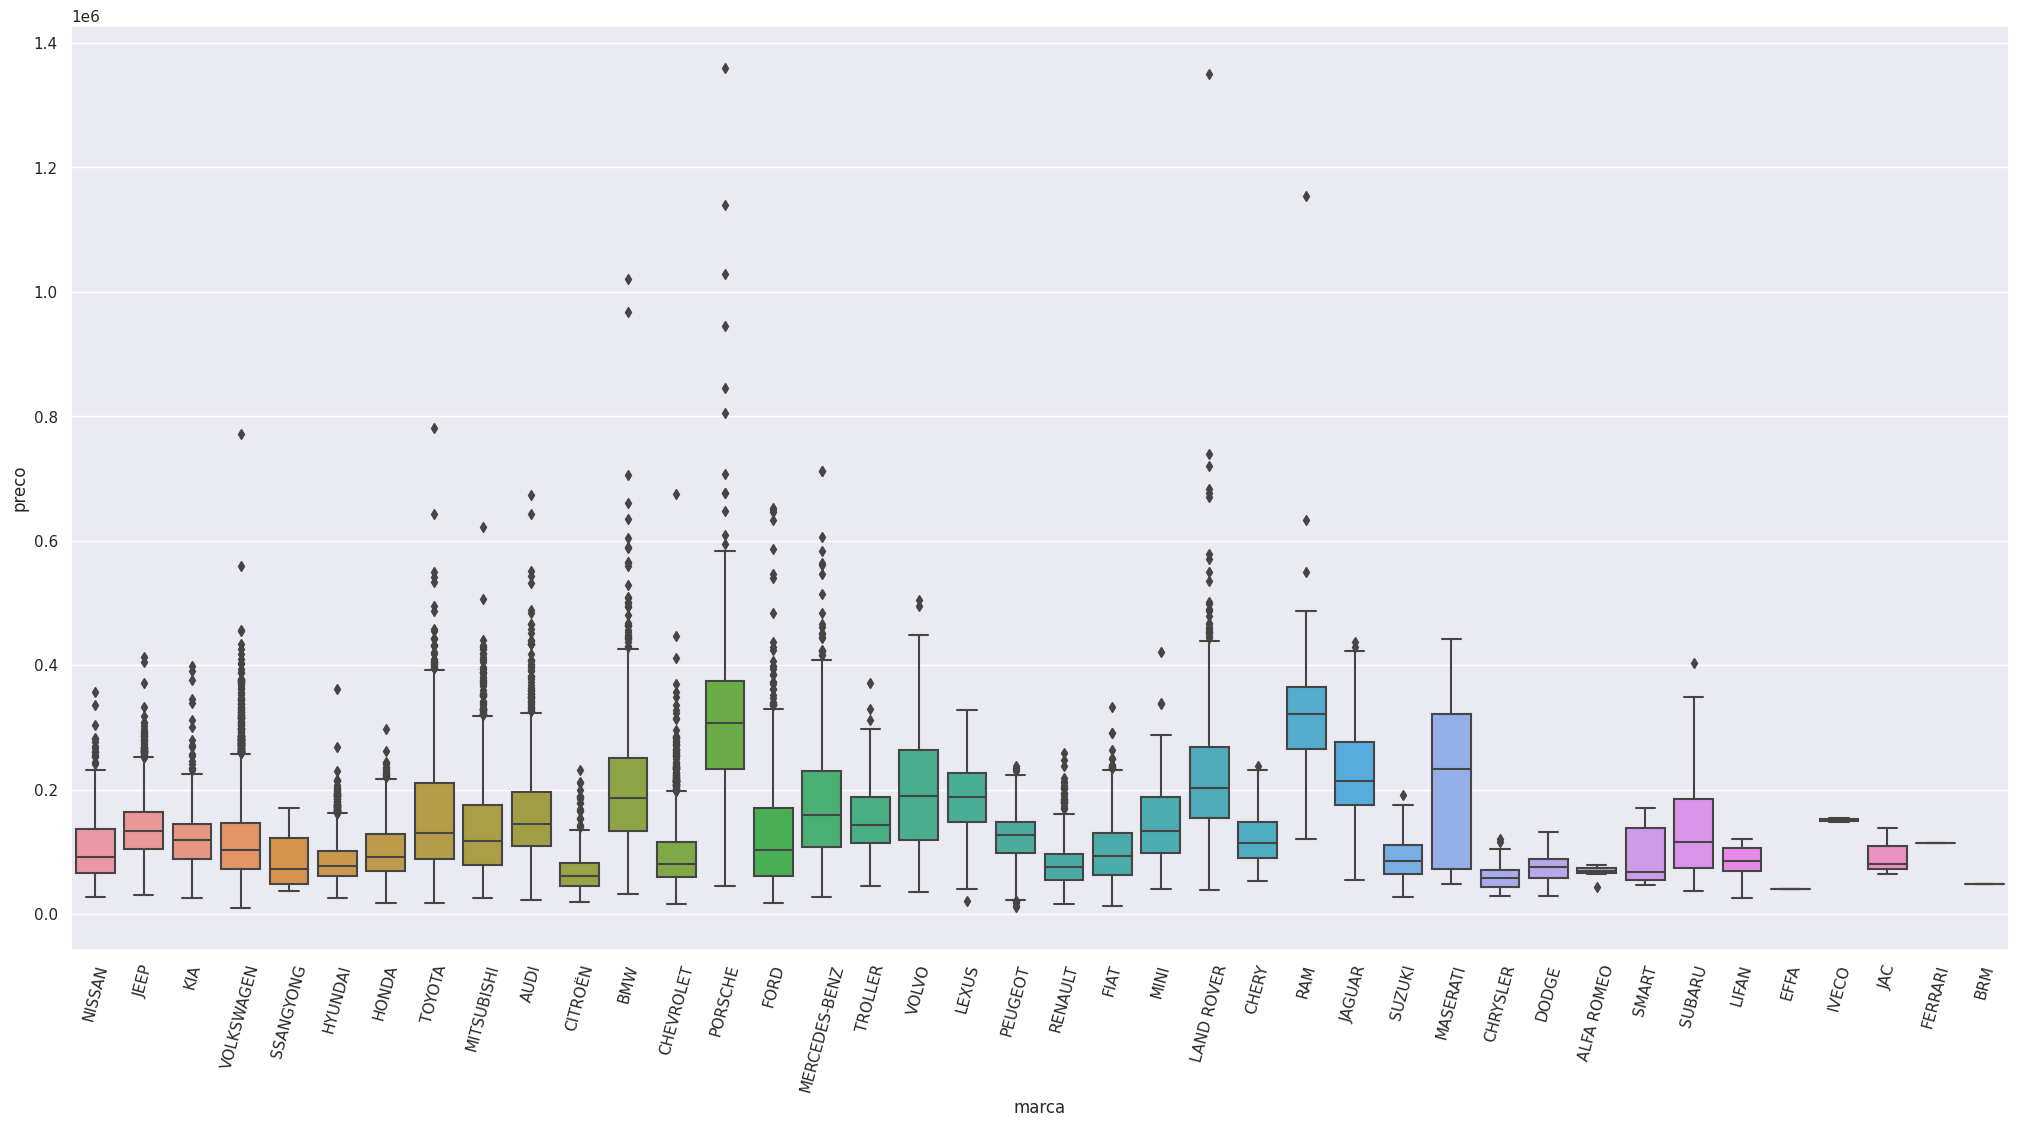

In [16]:
sns.boxplot(x='marca', y='preco', data=df1)
plt.xticks(rotation=75);

#### Cambio

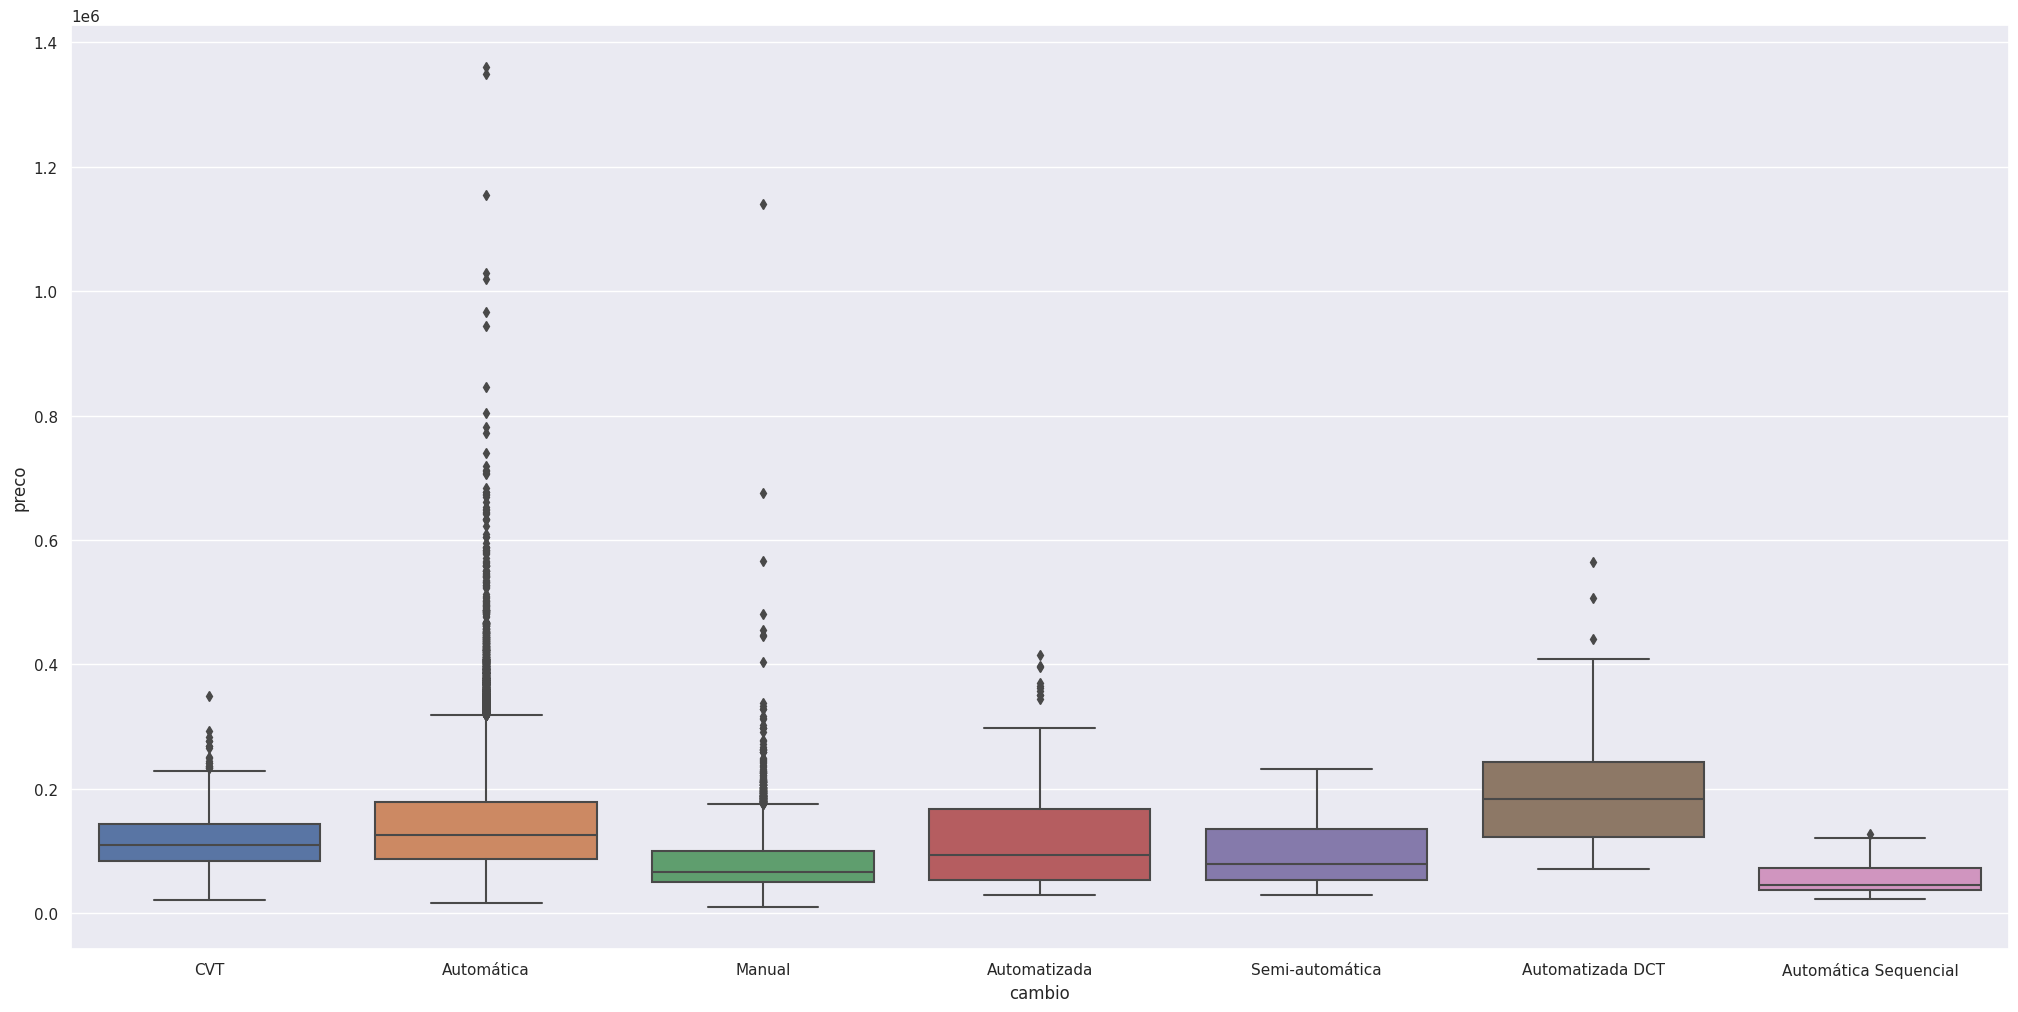

In [24]:
sns.boxplot(x='cambio', y='preco', data=df1);

#### Tipo

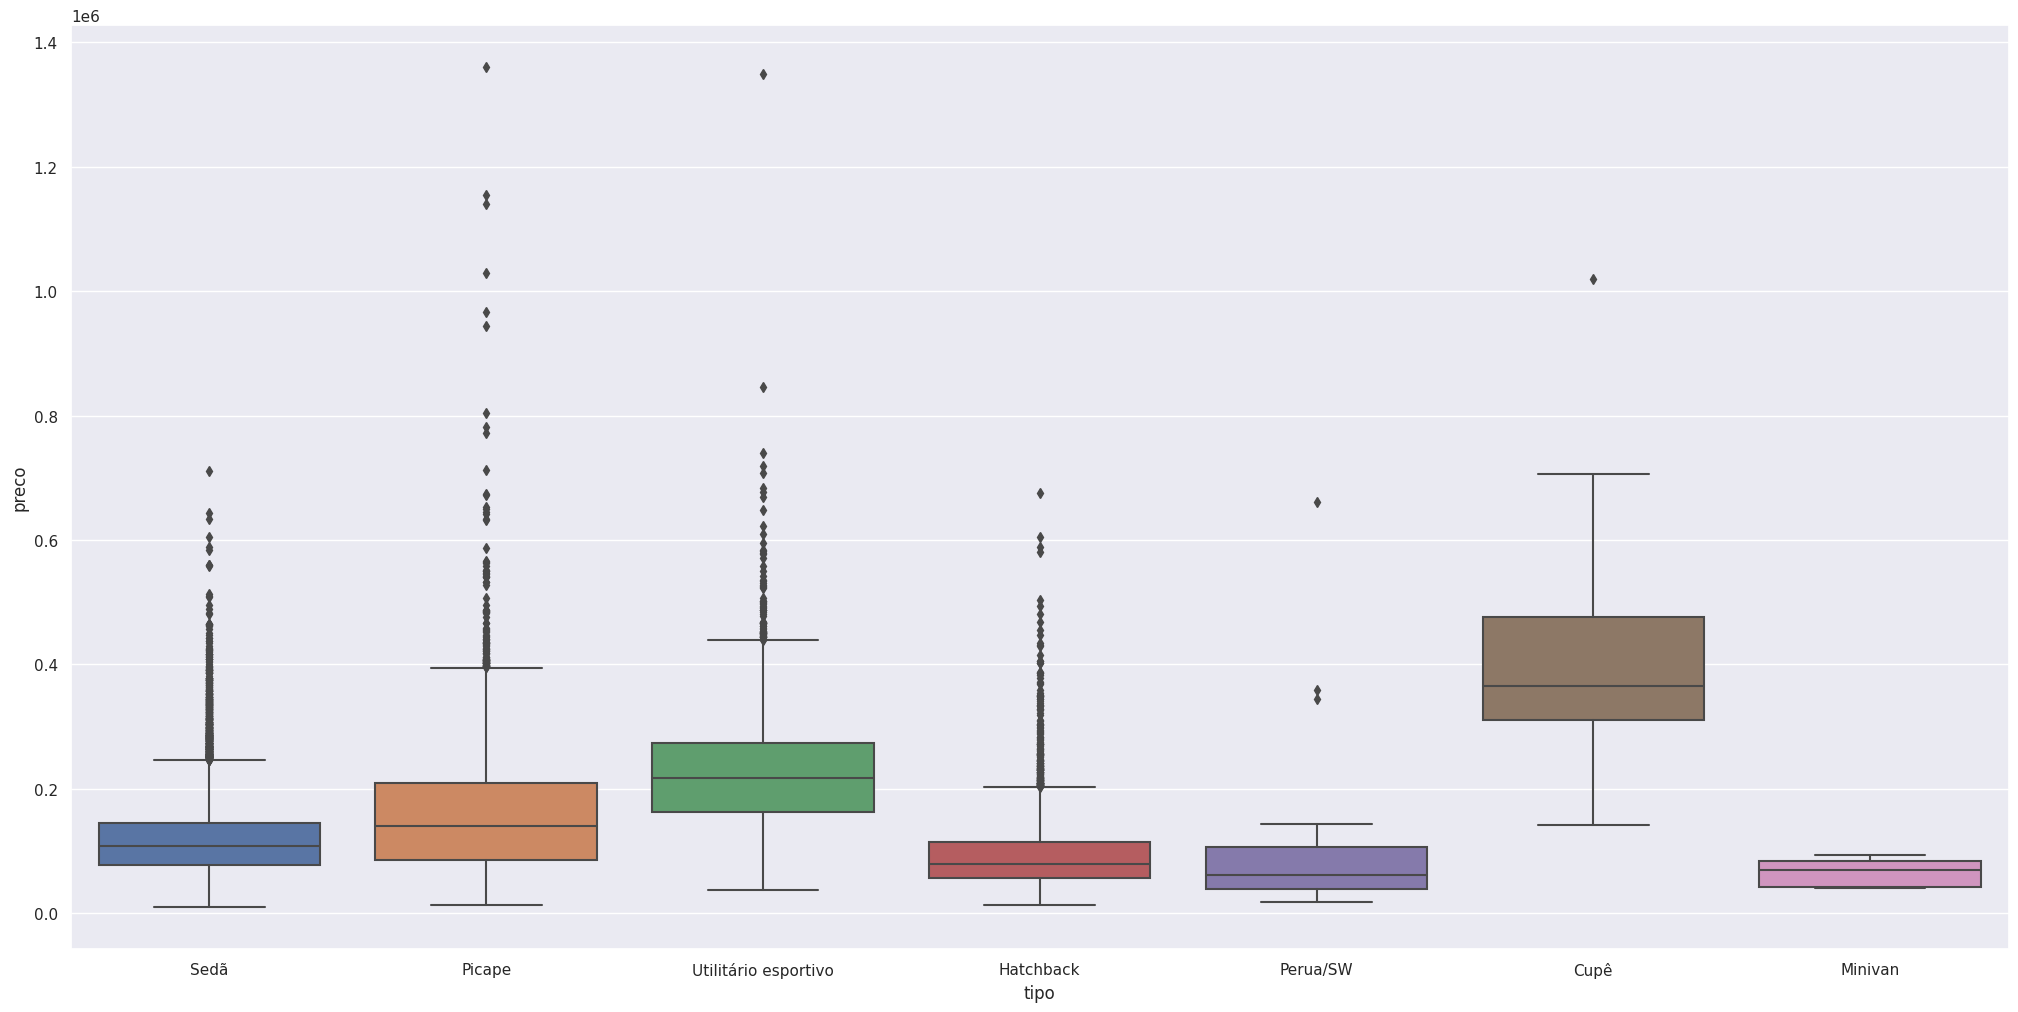

In [23]:
sns.boxplot(x='tipo', y='preco', data=df1);

#### Cor

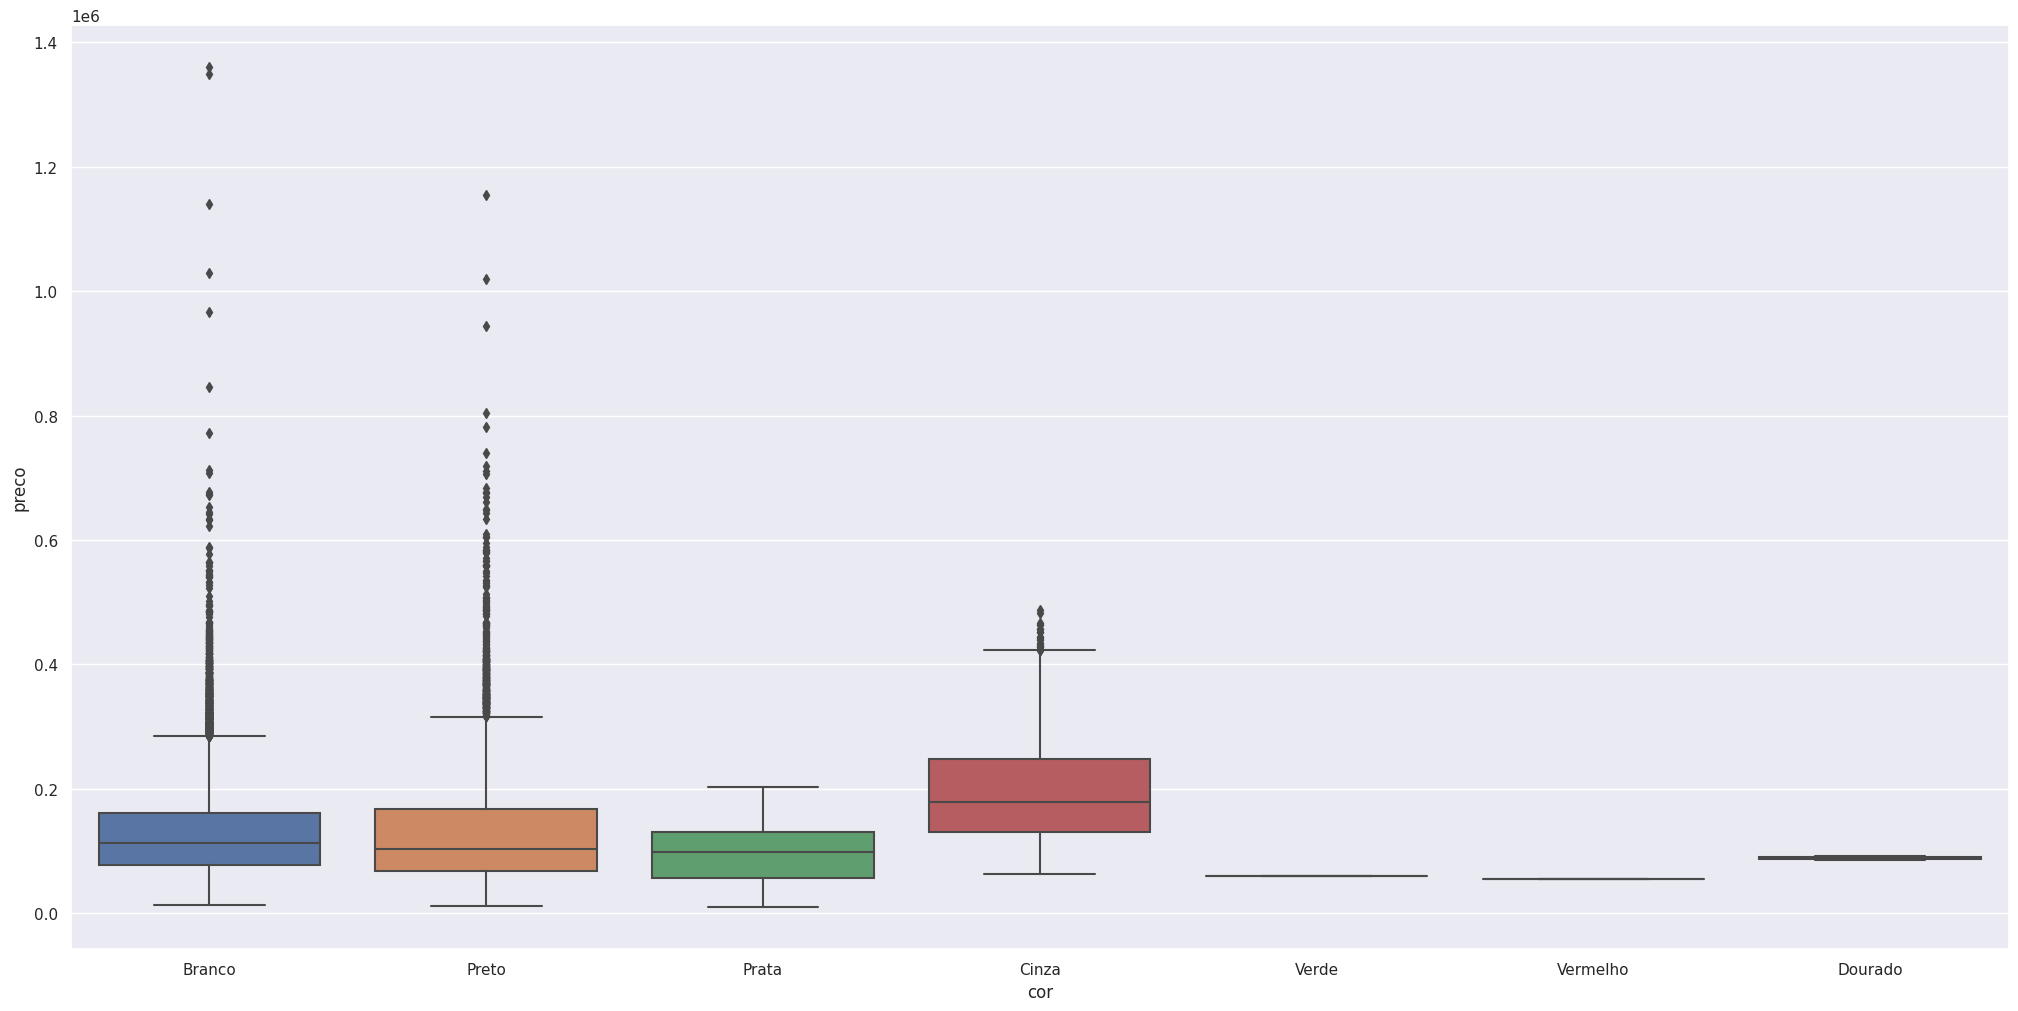

In [26]:
sns.boxplot(x='cor', y='preco', data=df1);

#### Estado

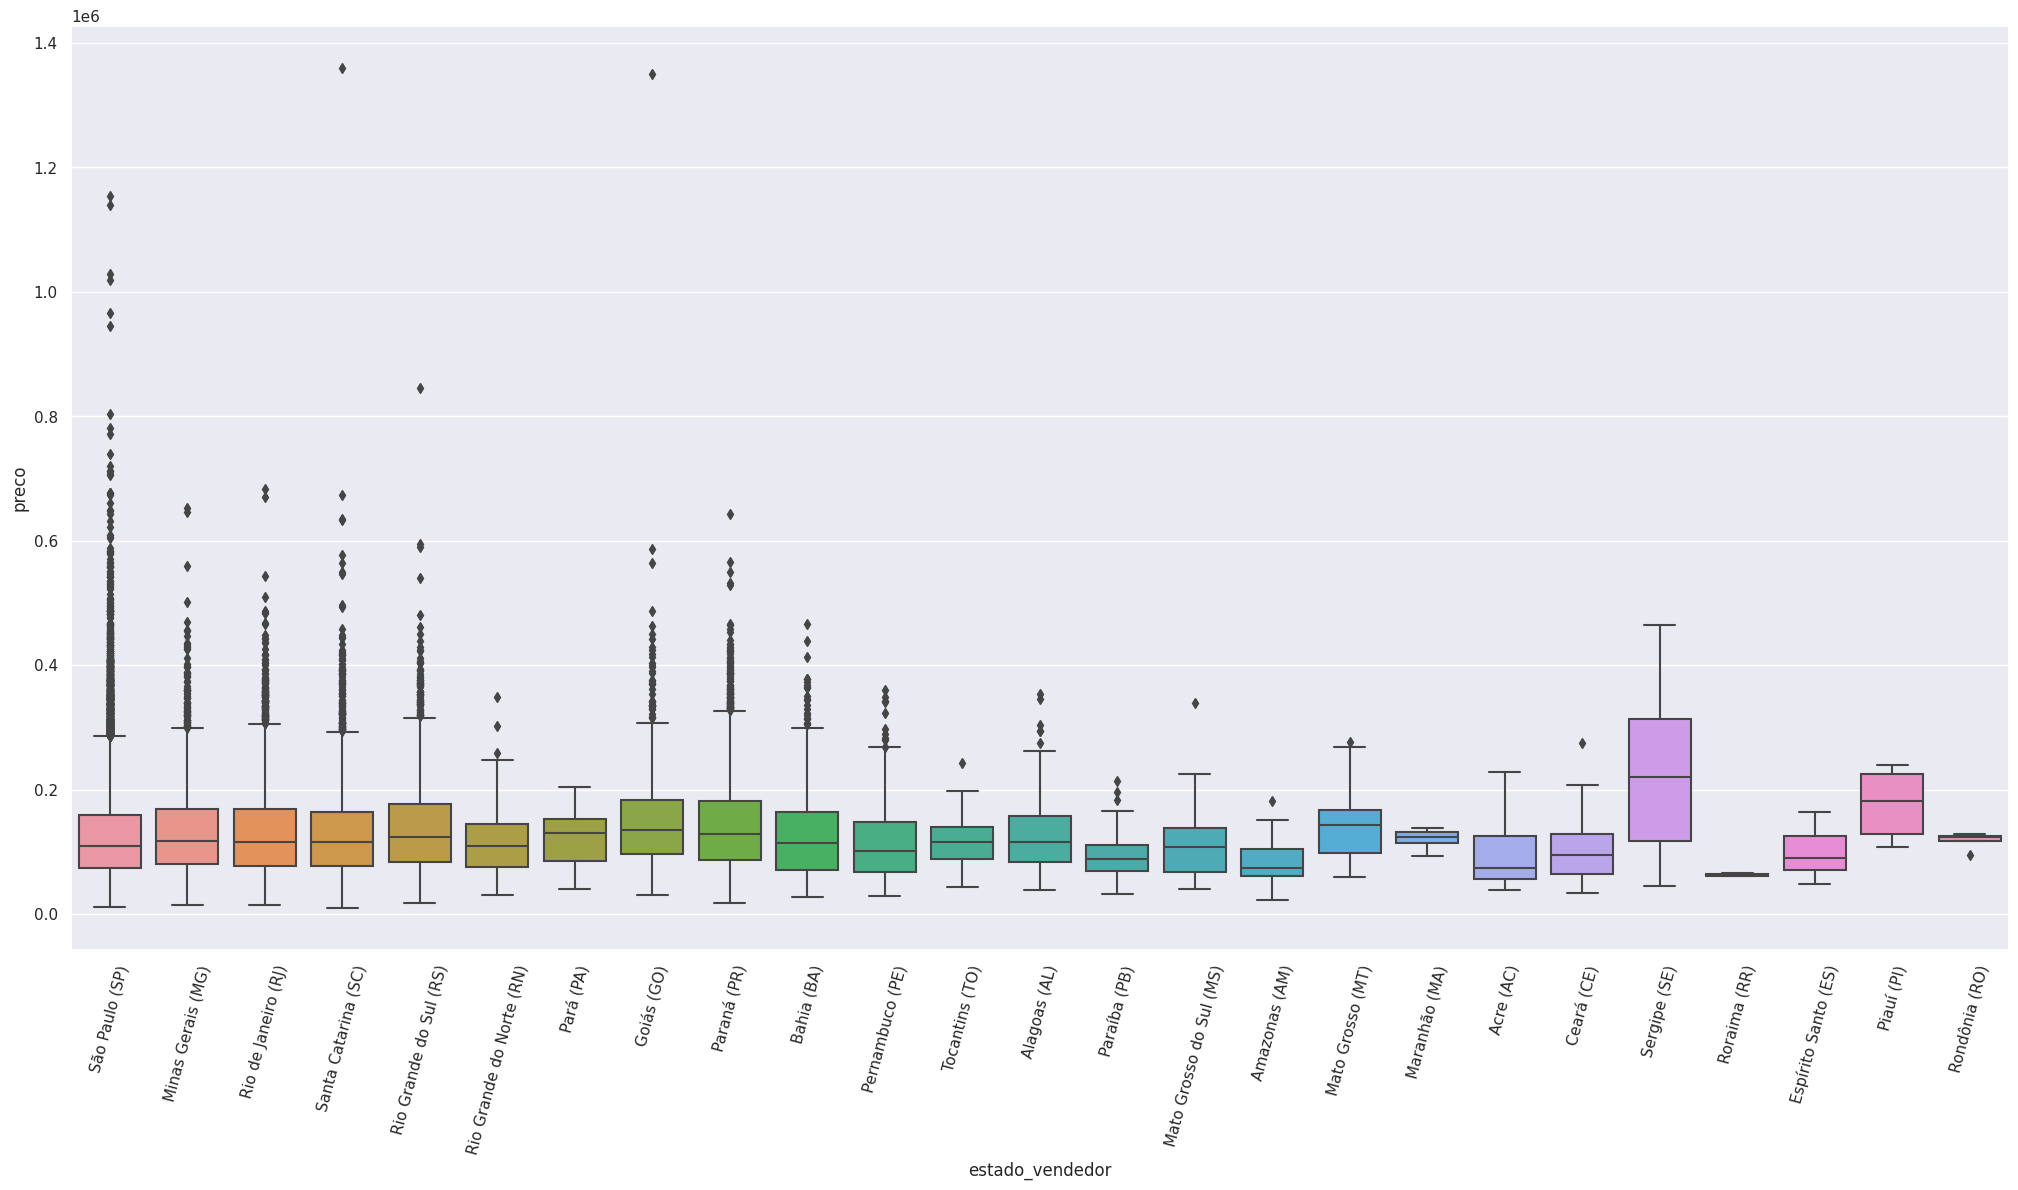

In [28]:
sns.boxplot(x='estado_vendedor', y='preco', data=df1)
plt.xticks(rotation=75);

#### Anunciante

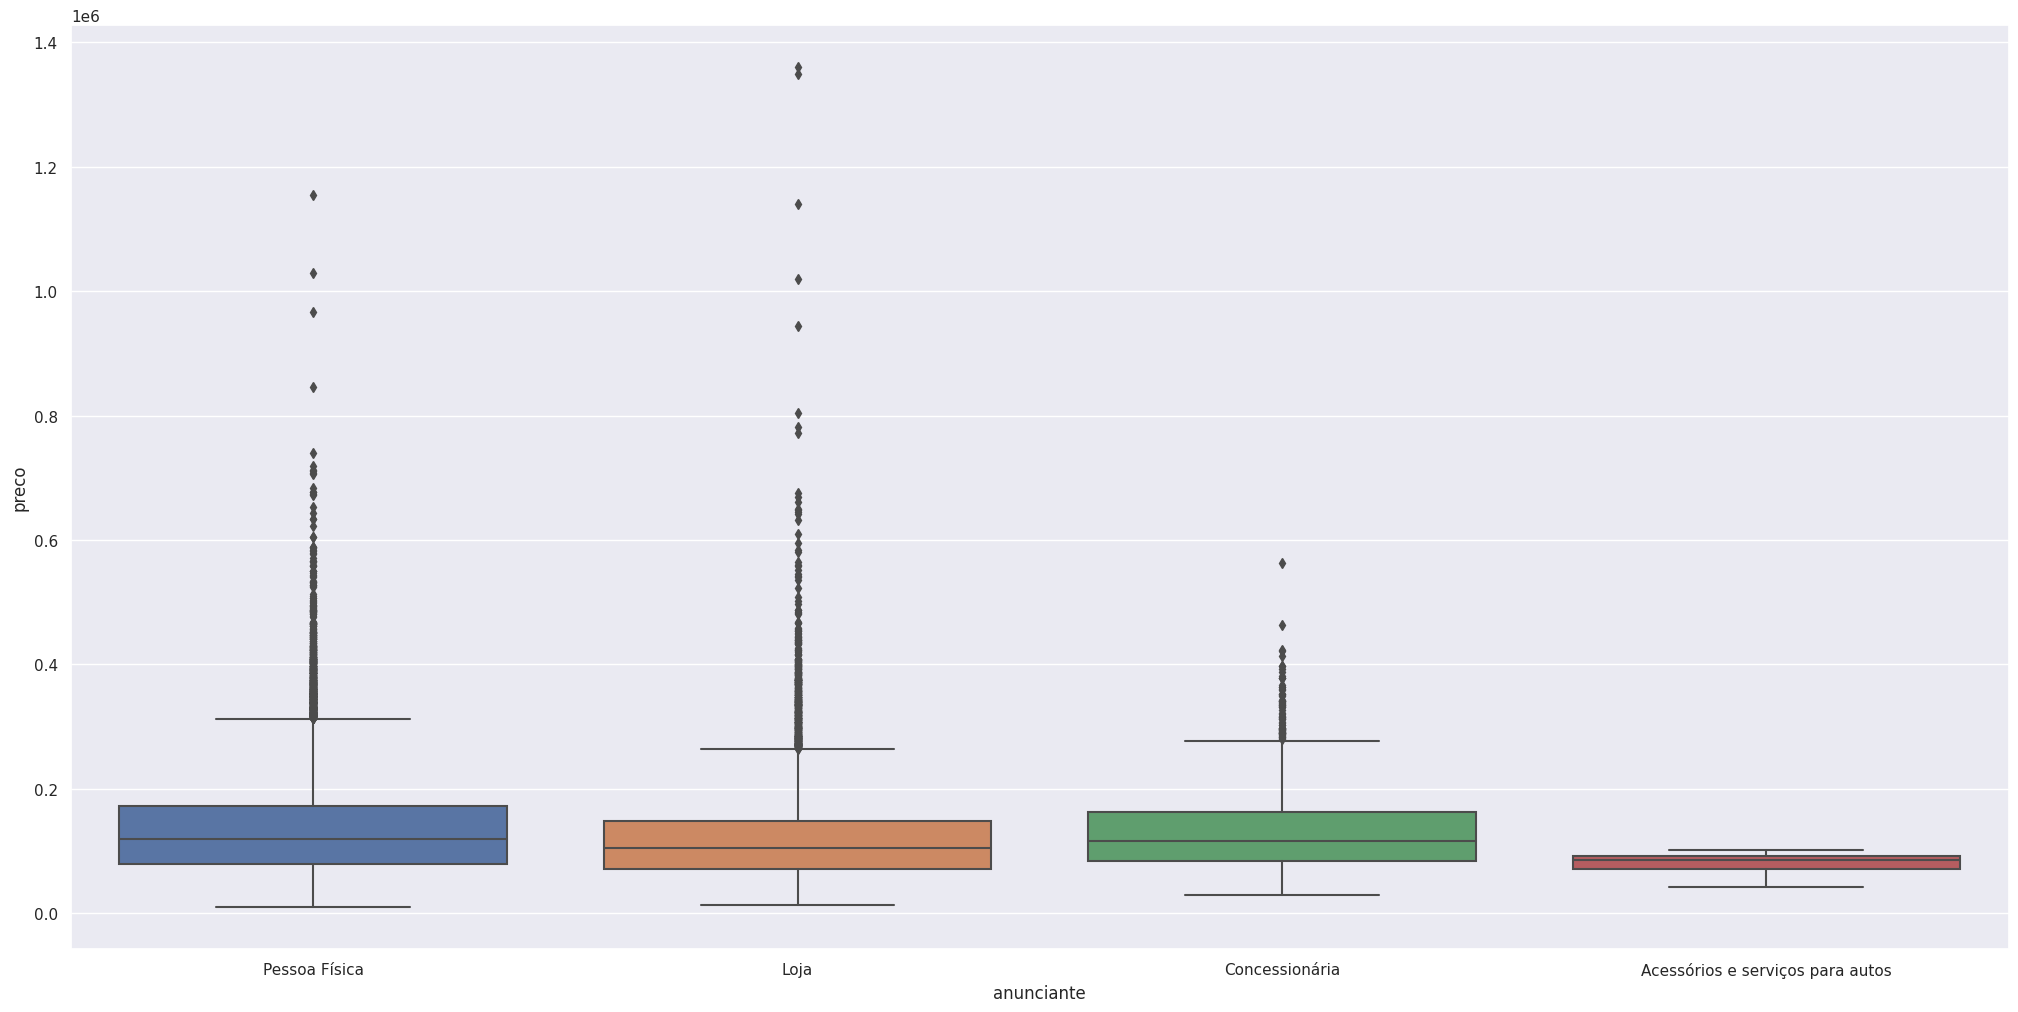

In [38]:
sns.boxplot(x='anunciante', y='preco', data=df1);

#### Outros

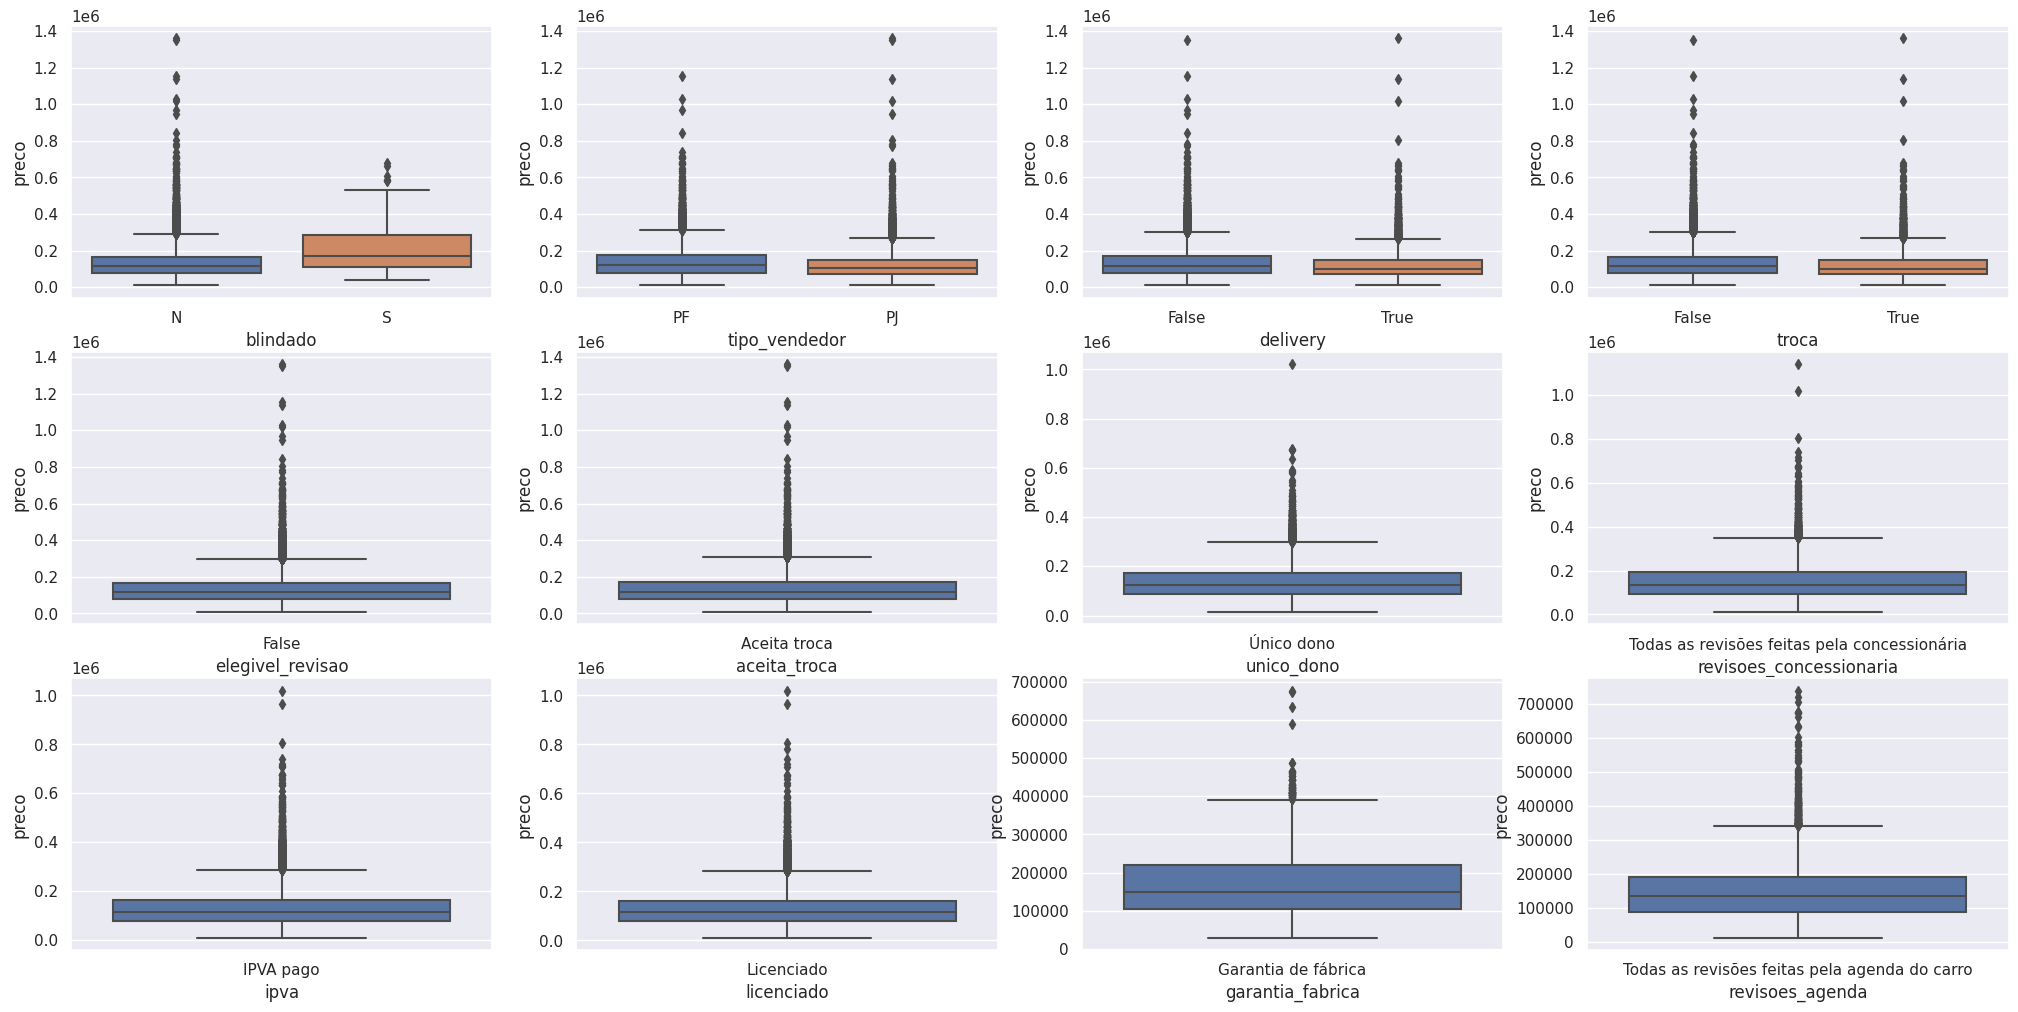

In [44]:
list_features = ['blindado', 'tipo_vendedor', 'delivery', 'troca', 'elegivel_revisao', 'aceita_troca',
                 'unico_dono', 'revisoes_concessionaria', 'ipva', 'licenciado', 'garantia_fabrica', 'revisoes_agenda']

for index, feature in enumerate(list_features, start=1):
    plt.subplot(3, 4, index)
    sns.boxplot(x=feature, y='preco', data=df1)

# 2.0 FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

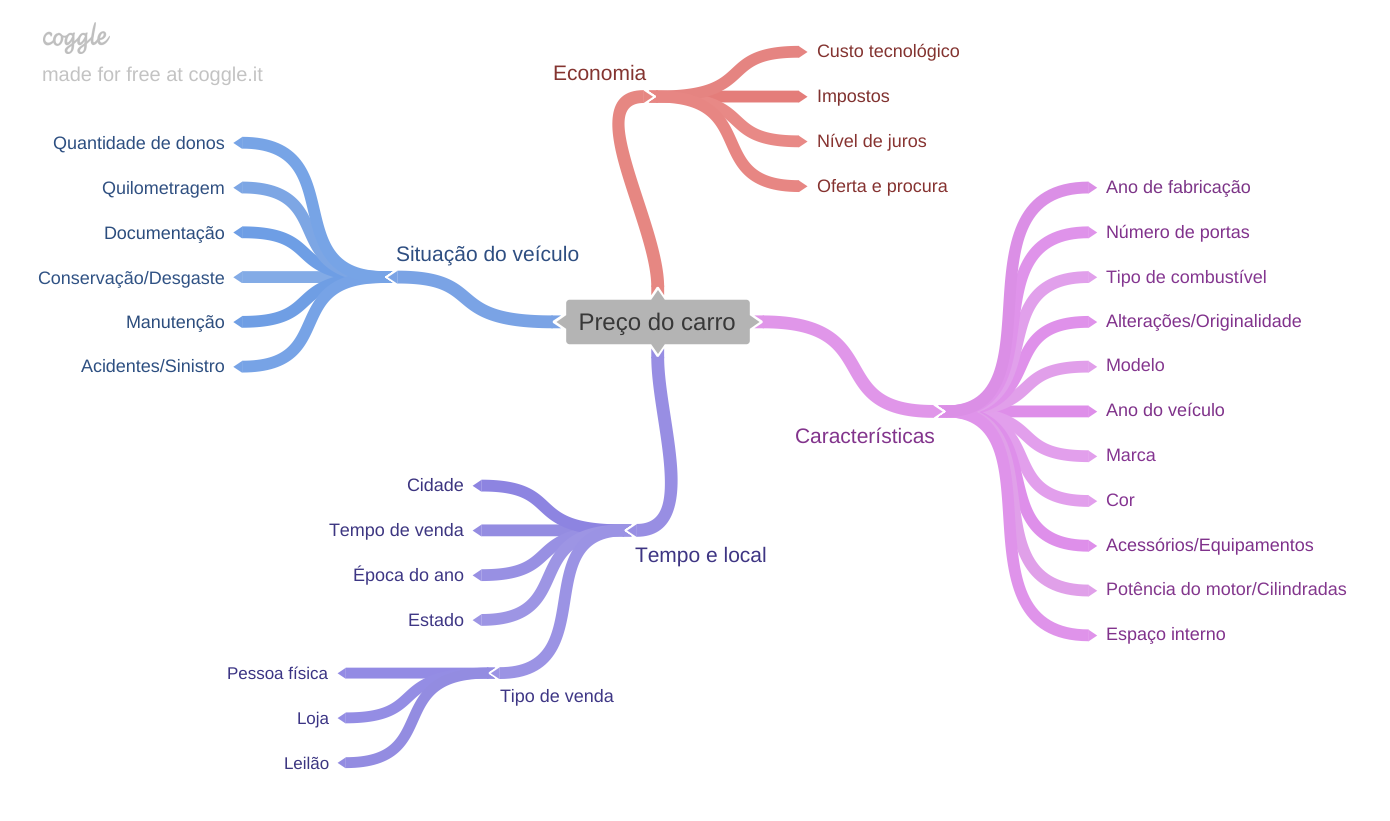

In [23]:
Image('../reports/figures/mind_map.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses de Características

**1.** Carros com mais portas são mais caros.

**2.** Carros com motores flex são mais caros.

**3.** Carros sem alterações são mais caros.

**4.** Carros com ano de fabricação mais recentes são mais caros.

**5.** Carros com modelos mais recentes são mais caros.

**6.** Carros brancos são mais caros.

**7.** Carros com maiores cilindradas são mais caros.

**8.** Carros com acessórios são mais caros.

### 2.2.2 Hipóteses de Tempo e Local

**1.** O preço dos veículos é maior no Sudeste.

**2.** O preço dos caros é maior no começo do ano.

**3.** Caros vendidos por lojas são mais caros.

### 2.2.3 Hipóteses de Situação do veículo

**1.** Carros com donos únicos são mais caros.

**2.** Carros com mais quilometragem são mais baratos.

**3.** Carros com documentação vencida são mais baratos.

**4.** Carros com acidentes previos são mais baratos.

**5.** Carros sem manutenção são mais baratos.

## 2.4 Feature Engineering

In [24]:
# número de fotos
# Número de fotos faltantes serão considerados 0
df2['num_fotos'].fillna(0, inplace=True)

# extraindo features com regular expression

df2['identificacao'] = df2['marca'] + '-' + df2['modelo']

# cilindradas
df2['cilindradas'] = df2['versao'].apply(lambda x: re.search(r'(\d\.\d)', x).group(1) if re.search('(\d\.\d)', x) else 'na')

# combustivel
df2['combustivel'] = df2['versao'].apply(lambda x: 'gasolina' if re.search('GASOLINA', x)
                                         else 'flex' if re.search('FLEX', x)
                                         else 'diesel' if re.search('DIESEL', x)
                                         else 'etanol' if re.search('ETANOL', x)
                                         else 'eletrico' if re.search('ELÉTRICO', x)
                                         else 'outro')
                                         
# turbo
df2['turbo'] = df2['versao'].apply(lambda x: True if re.search('TURBO', x)
                                   else False)                                         

# Preenchendo valores faltantes
# Todos os valores faltantes foram considerados False
# troca
df2['aceita_troca'] = df2['aceita_troca'].apply(lambda x: False if pd.isna(x) else True)

# unico dono
df2['unico_dono'] = df2['unico_dono'].apply(lambda x: False if pd.isna(x) else True)

# revisoes concessionaria
df2['revisoes_concessionaria'] = df2['revisoes_concessionaria'].apply(lambda x: False if pd.isna(x) else True)

# ipva
df2['ipva'] = df2['ipva'].apply(lambda x: False if pd.isna(x) else True)

# licenciado
df2['licenciado'] = df2['licenciado'].apply(lambda x: False if pd.isna(x) else True)

# garantia de fabrica
df2['garantia_fabrica'] = df2['garantia_fabrica'].apply(lambda x: False if pd.isna(x) else True)

# revisoes agenda
df2['revisoes_agenda'] = df2['revisoes_agenda'].apply(lambda x: False if pd.isna(x) else True)

df2['endereco'] = df2['cidade_vendedor'] + '-' + df2['estado_vendedor']

### 2.4.1 Conferindo Cidades e Estados

Há no dataset cidades com estados incorretos, para isso é necessário verificar se as cidades realmente pertencem ao estado informado.

In [25]:
df2.loc[9802]

id                         100782370360602513820631340414980252519
num_fotos                                                      8.0
marca                                                         FIAT
modelo                                                        TORO
versao                        2.0 16V TURBO DIESEL VOLCANO 4WD AT9
ano_fabricacao                                                2019
ano_modelo                                                  2019.0
hodometro                                                  45523.0
cambio                                                  Automática
num_portas                                                       4
tipo                                                        Picape
blindado                                                         N
cor                                                         Branco
tipo_vendedor                                                   PF
cidade_vendedor                                       Bady Bas

Utilizando uma API podemos verificar as informações para cada combinação.

In [74]:
from __future__ import print_function
import time
import cloudmersive_validate_api_client
from cloudmersive_validate_api_client.rest import ApiException
from pprint import pprint

In [75]:
# Configure API key authorization: Apikey
configuration = cloudmersive_validate_api_client.Configuration()
configuration.api_key['Apikey'] = 'KEY'

In [108]:
# create an instance of the API class
api_instance = cloudmersive_validate_api_client.AddressApi(cloudmersive_validate_api_client.ApiClient(configuration))
input = cloudmersive_validate_api_client.ValidateCityRequest() # ValidateCityRequest | Input parse request

try:
    # Validate a City and State/Province combination, get location information about it
    api_response = api_instance.address_validate_city({"City": "Bady Bassitt",
                                                       "StateOrProvince": "São Paulo (SP)",
                                                       "CountryFullName": "Brazil"})
    pprint(api_response)
except ApiException as e:
    print("Exception when calling AddressApi->address_validate_city: %s\n" % e)

{'city': 'Bady Bassitt',
 'latitude': -20.9178969,
 'longitude': -49.4517911,
 'state_or_province': 'SP',
 'valid_city': True}


*A cidade Bady Bassitt não fica no estado do Rio de Janeiro.*

Por questões de tempo e limite de requisições permitidas na API, essa informação não será corrigida e análisada agora.

# 3.0 FILTRAGEM DE VARIÁVEIS

In [26]:
df2.to_csv('../data/interim/dataset_features.csv', index=False)

df3 = pd.read_csv('../data/interim/dataset_features.csv')

## 3.1 Filtragem das Linhas

Não serão descartadas linhas nesse momento.

## 3.2 Seleção das Colunas

As features *'elegivel_revisao'* e *'alienado'* serão removidas por não apresentarem variação nos dados.

In [27]:
cols_drop = ['elegivel_revisao', 'alienado']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_fabricacao',
       'ano_modelo', 'hodometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'anunciante', 'delivery', 'troca', 'aceita_troca', 'unico_dono',
       'revisoes_concessionaria', 'ipva', 'licenciado', 'garantia_fabrica',
       'revisoes_agenda', 'preco', 'identificacao', 'cilindradas',
       'combustivel', 'turbo', 'endereco'],
      dtype='object')

In [29]:
df3.to_csv('../data/interim/dataset_selected.csv', index=False)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [6]:
df4 = df3.copy()

## 4.1 Análise Univariada

In [10]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64'])

### 4.1.1 Response Variable

/tmp/ipykernel_21255/1990598275.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['preco'])


<AxesSubplot: xlabel='preco', ylabel='Density'>

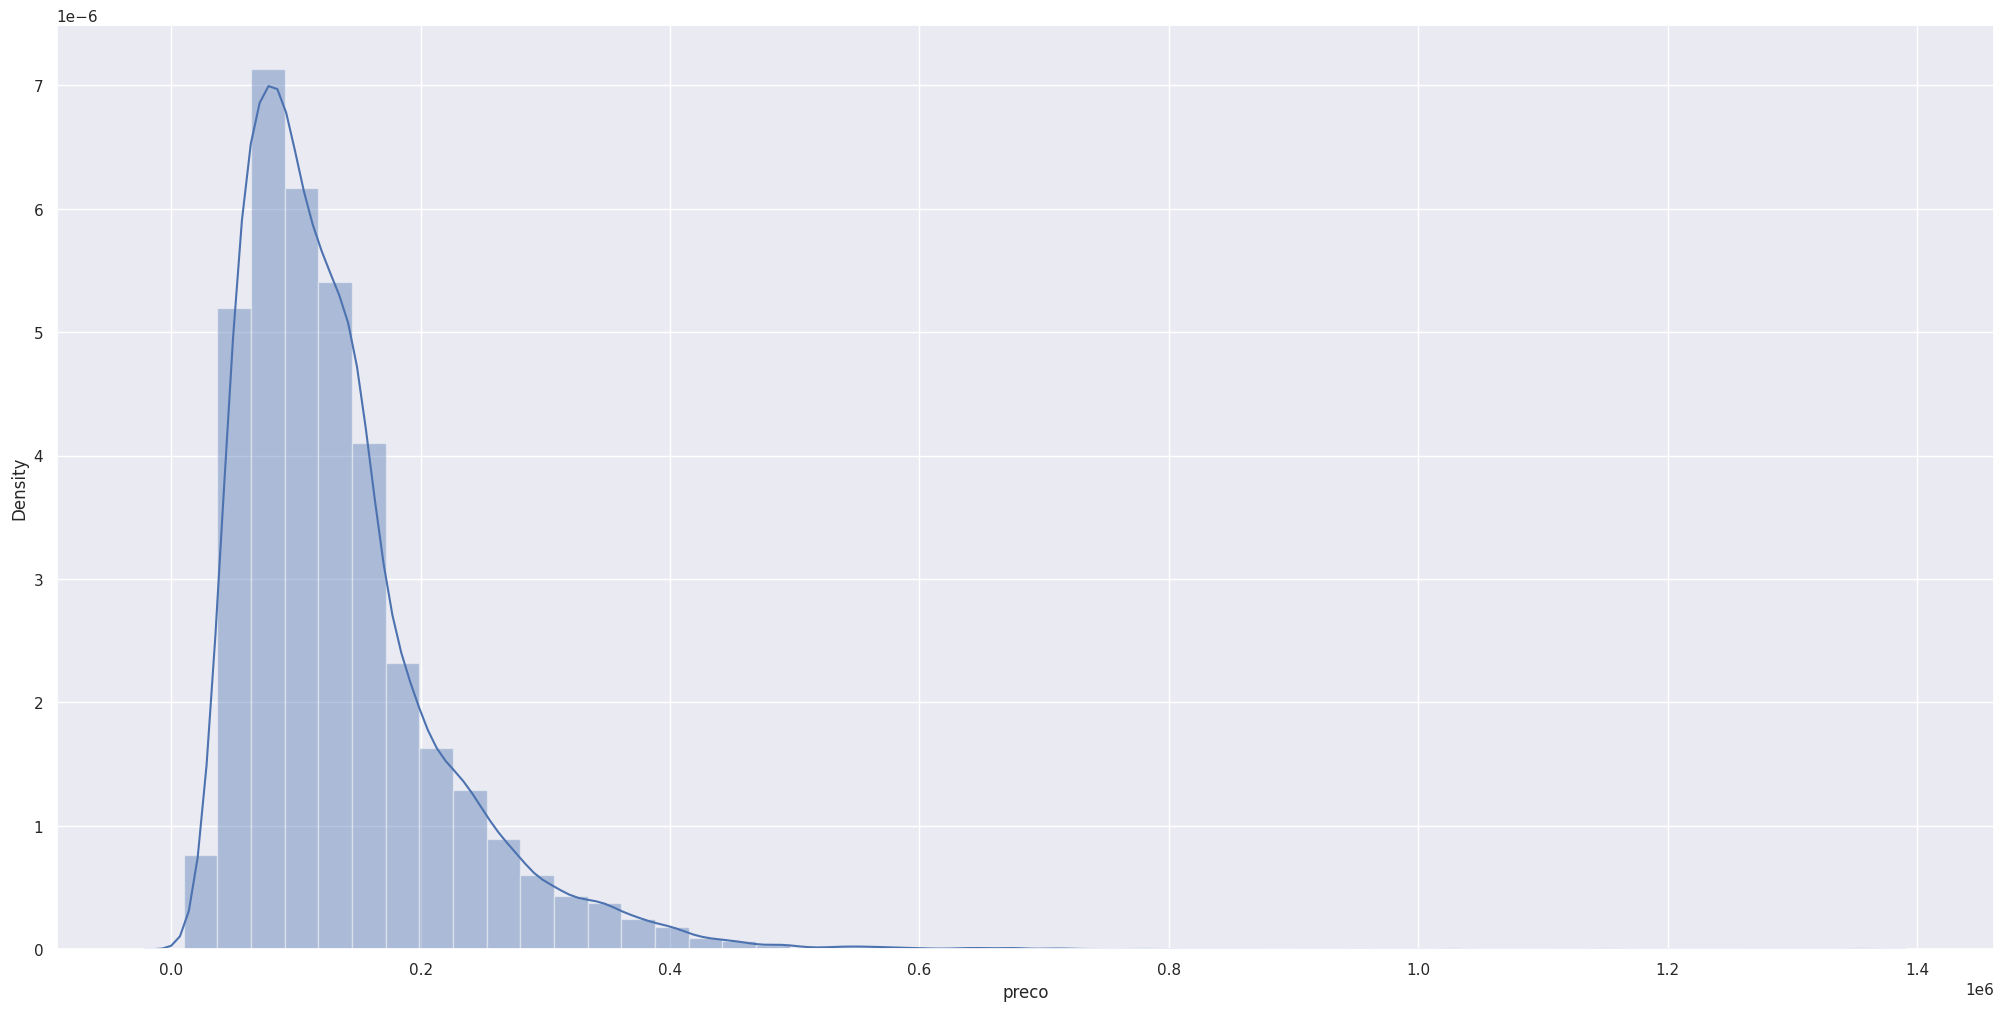

In [190]:
sns.distplot(df4['preco'])

### 4.1.2 Numerical Variable

In [191]:
descriptive_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.0000,21.0000,21.0000,10.2621,8.0000,3.5668,0.8371,-0.3903
1,ano_fabricacao,1985.0000,2022.0000,37.0000,2016.7586,2018.0000,4.0624,-2.4938,9.1891
2,ano_modelo,1997.0000,2023.0000,26.0000,2017.8090,2018.0000,2.6739,-0.4986,-0.5225
3,hodometro,100.0000,390065.0000,389965.0000,58430.5921,57434.0000,32561.2190,0.5909,1.1946
4,num_portas,2.0000,4.0000,2.0000,3.9407,4.0000,0.3384,-5.5450,28.7976
5,preco,9869.9506,1359812.8923,1349942.9417,133023.8799,114355.7970,81661.4920,2.1490,10.9749


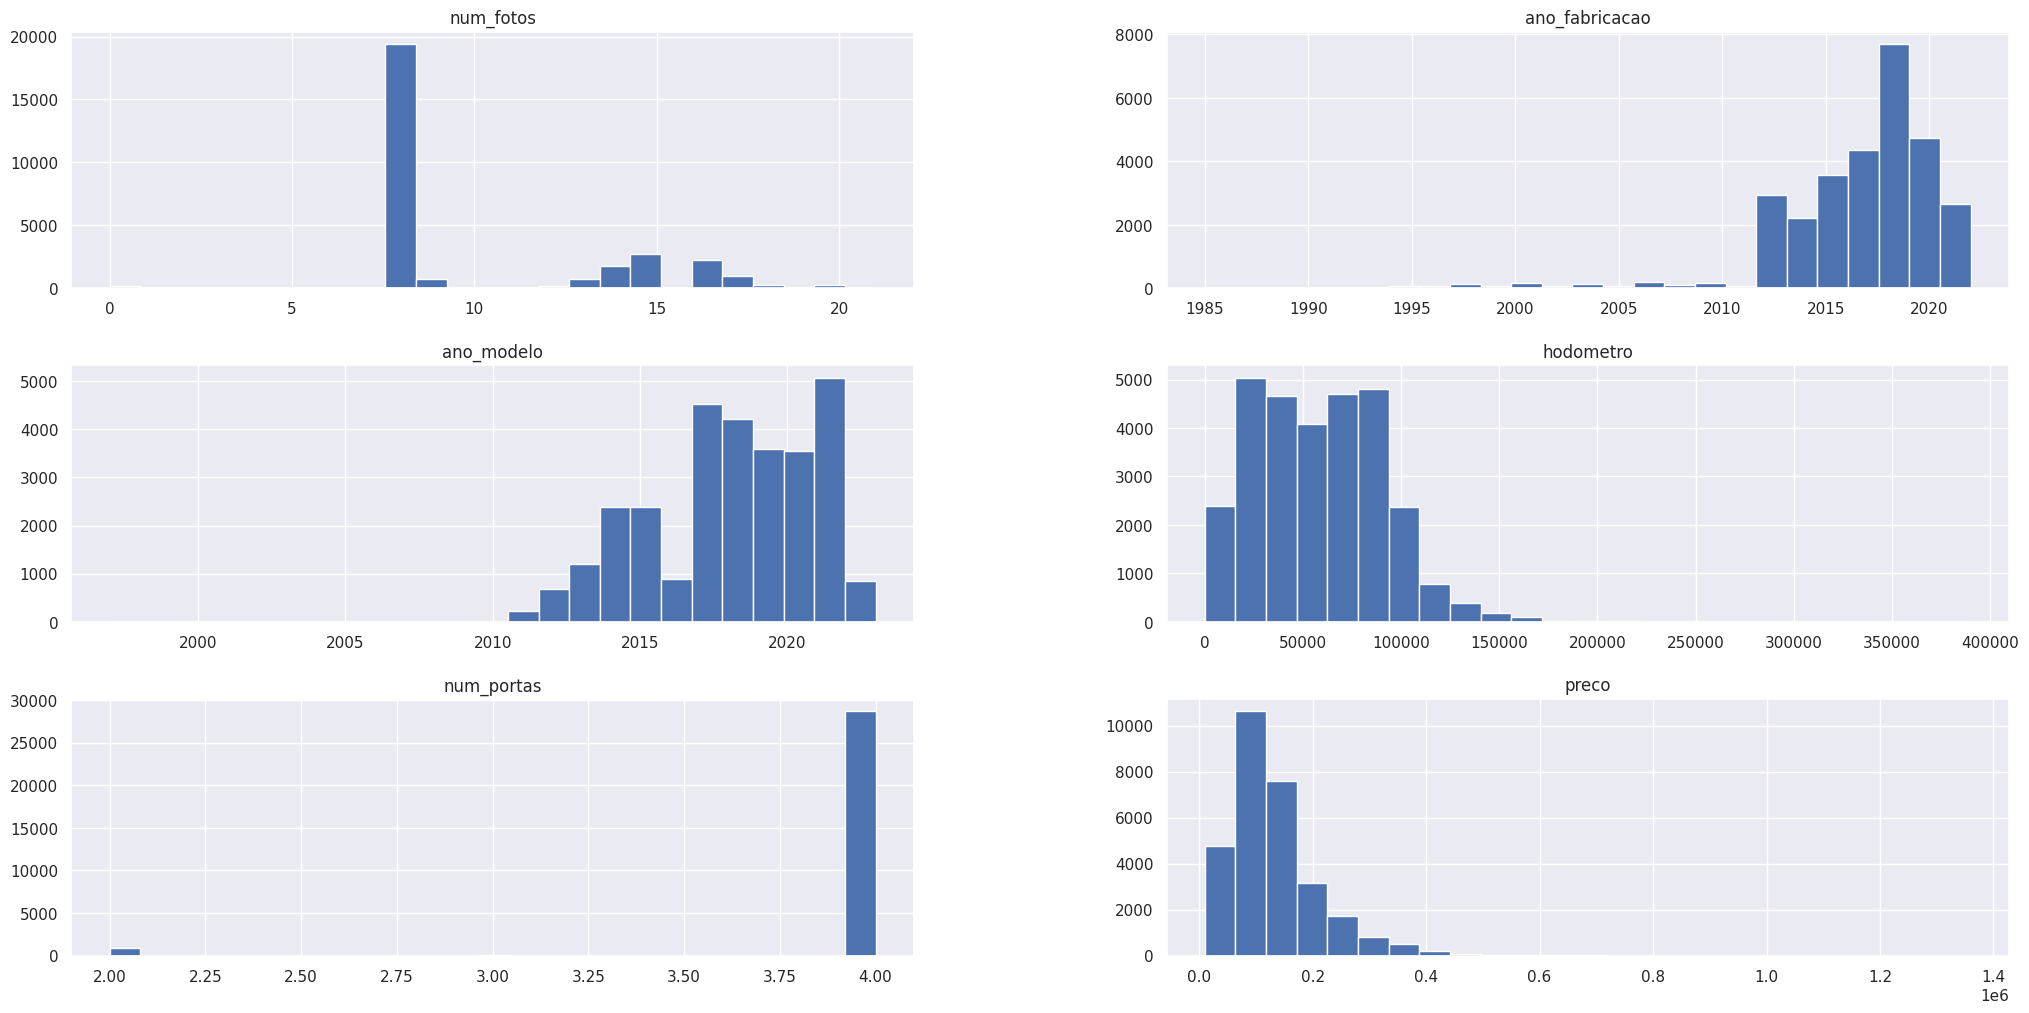

In [192]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

#### Marca

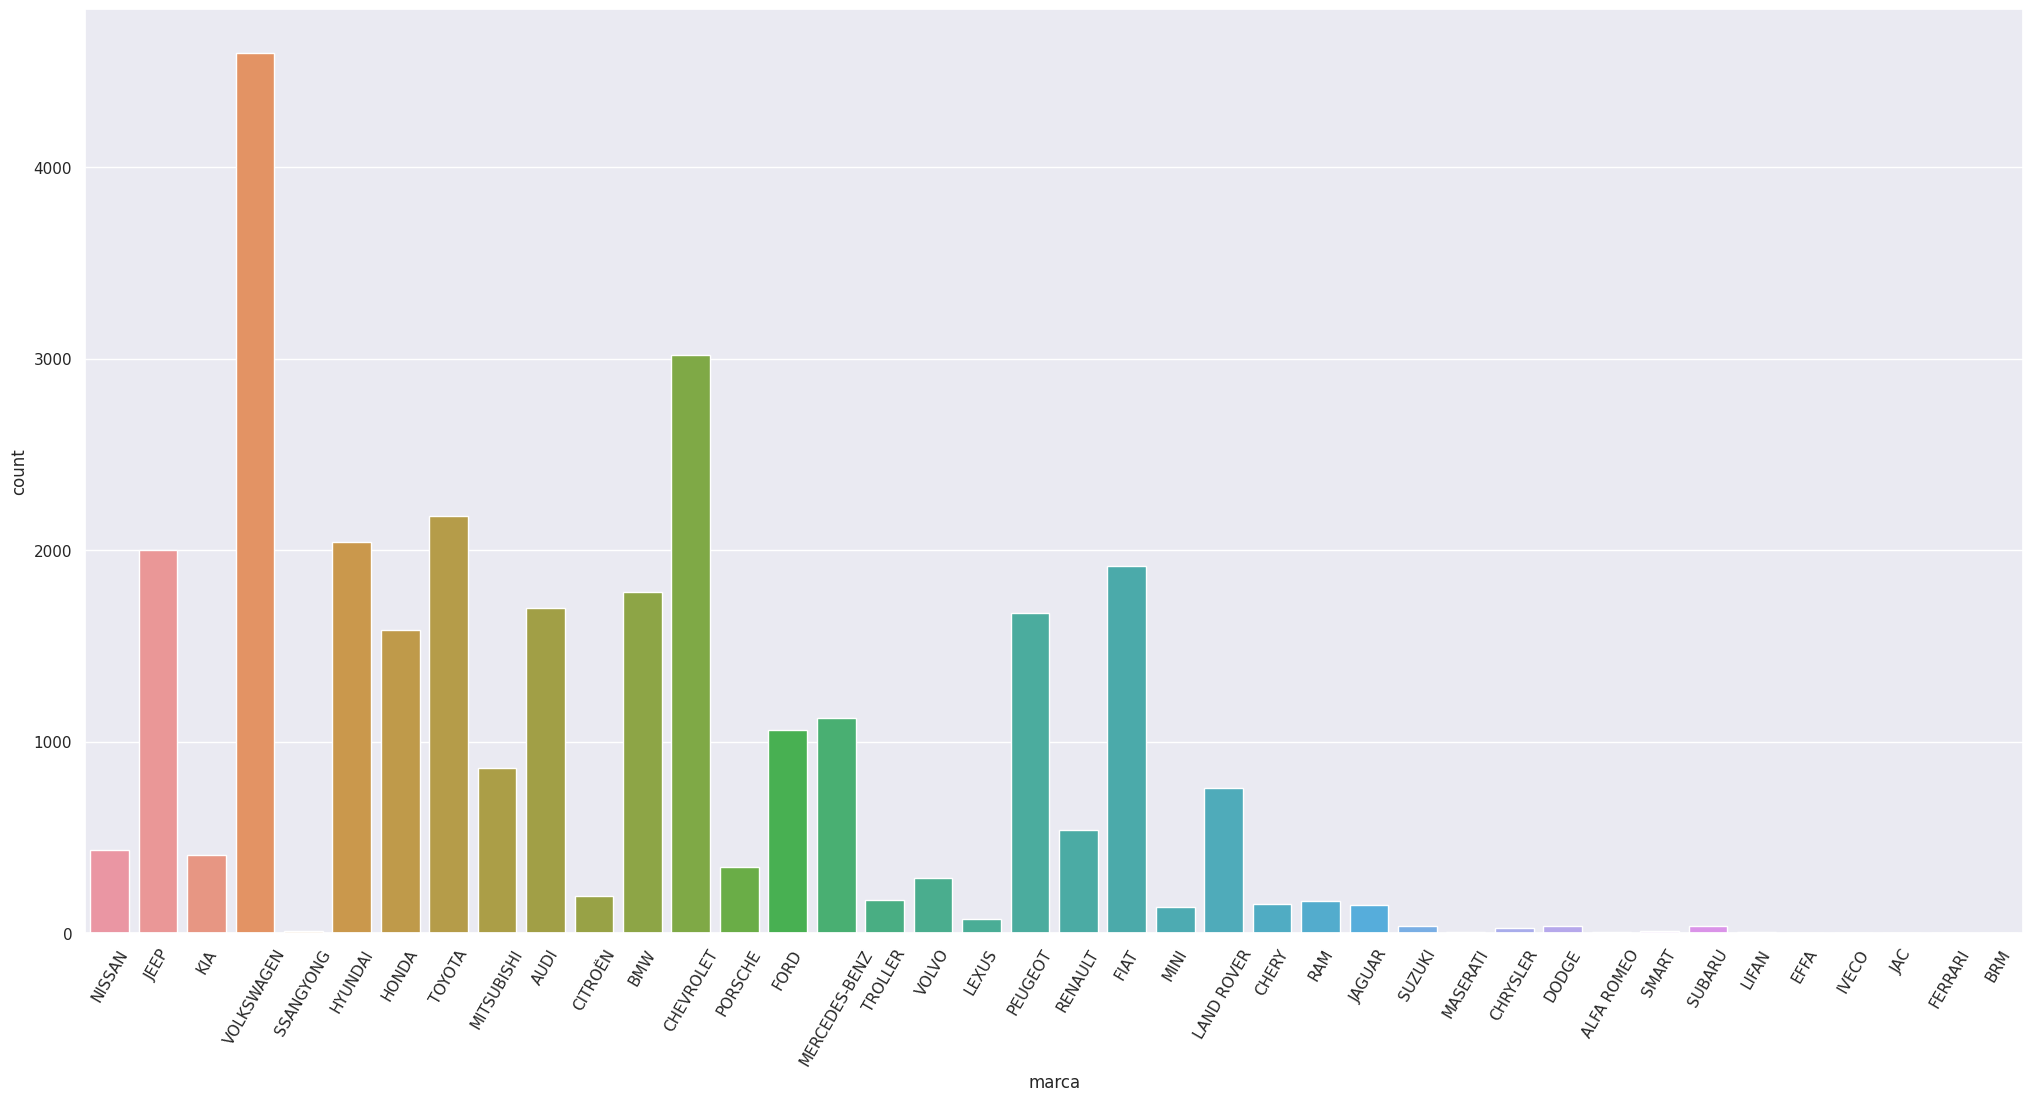

In [194]:
sns.countplot(x=df4['marca'])
plt.xticks(rotation=60);

#### Cambio

<AxesSubplot: xlabel='cambio', ylabel='count'>

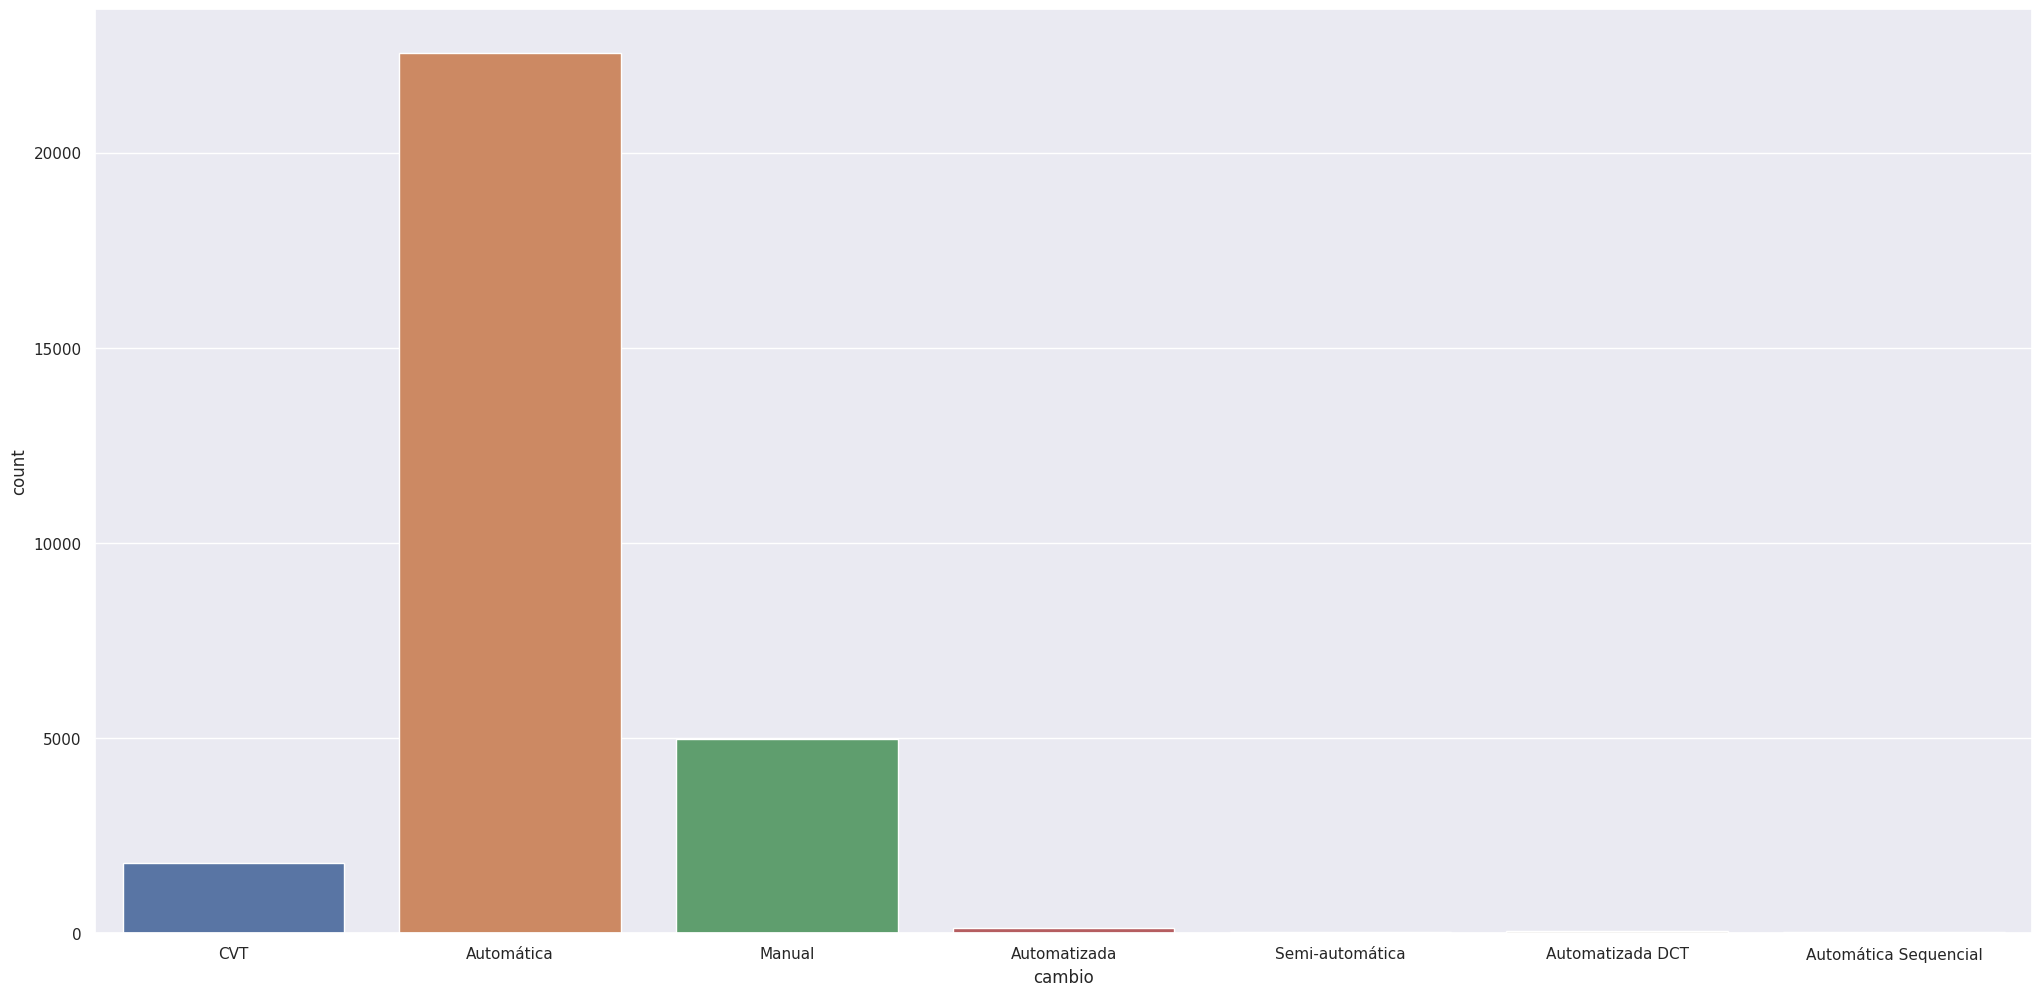

In [213]:
sns.countplot(x=df4['cambio']);

#### Estado

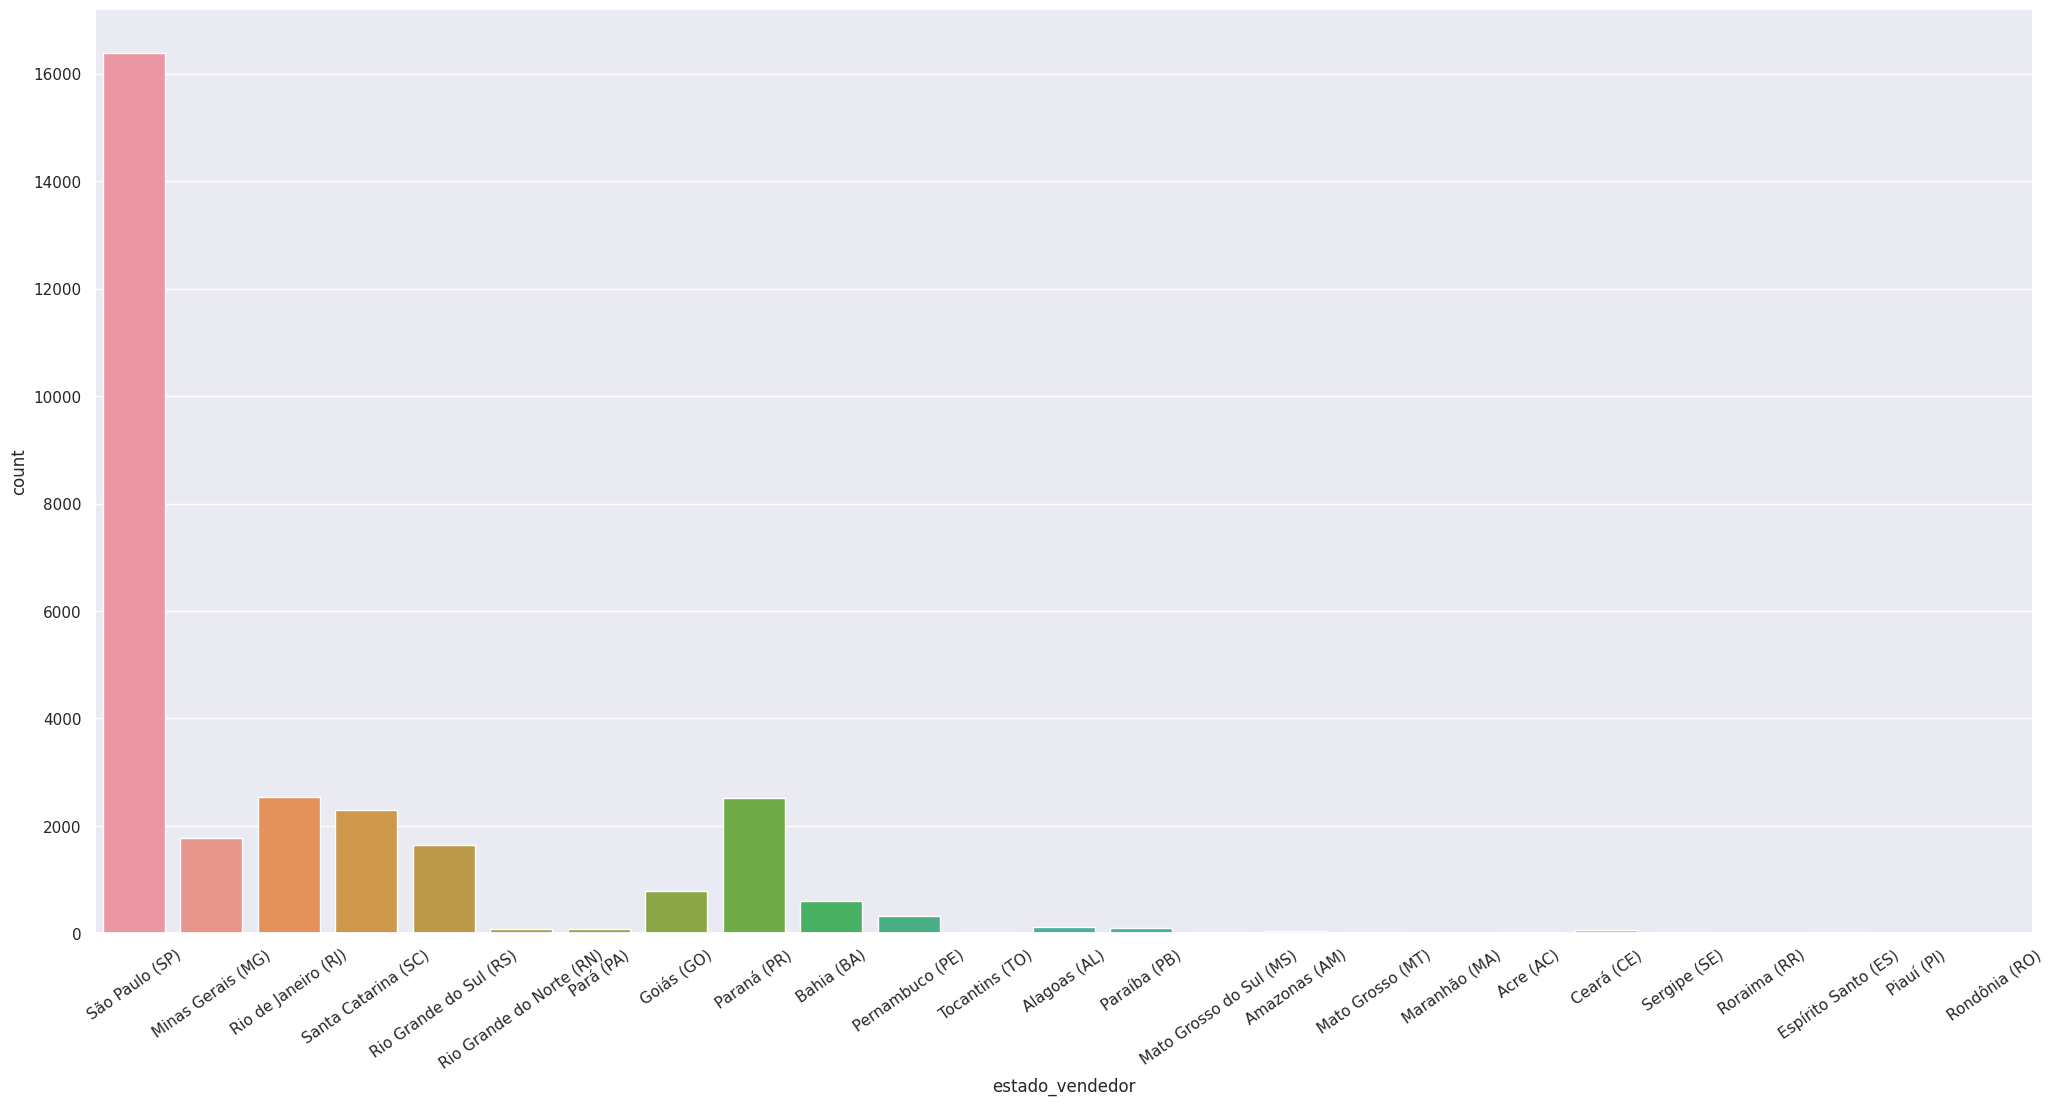

In [236]:
sns.countplot(x=df4['estado_vendedor'])
plt.xticks(rotation=35);

#### Cilindradas

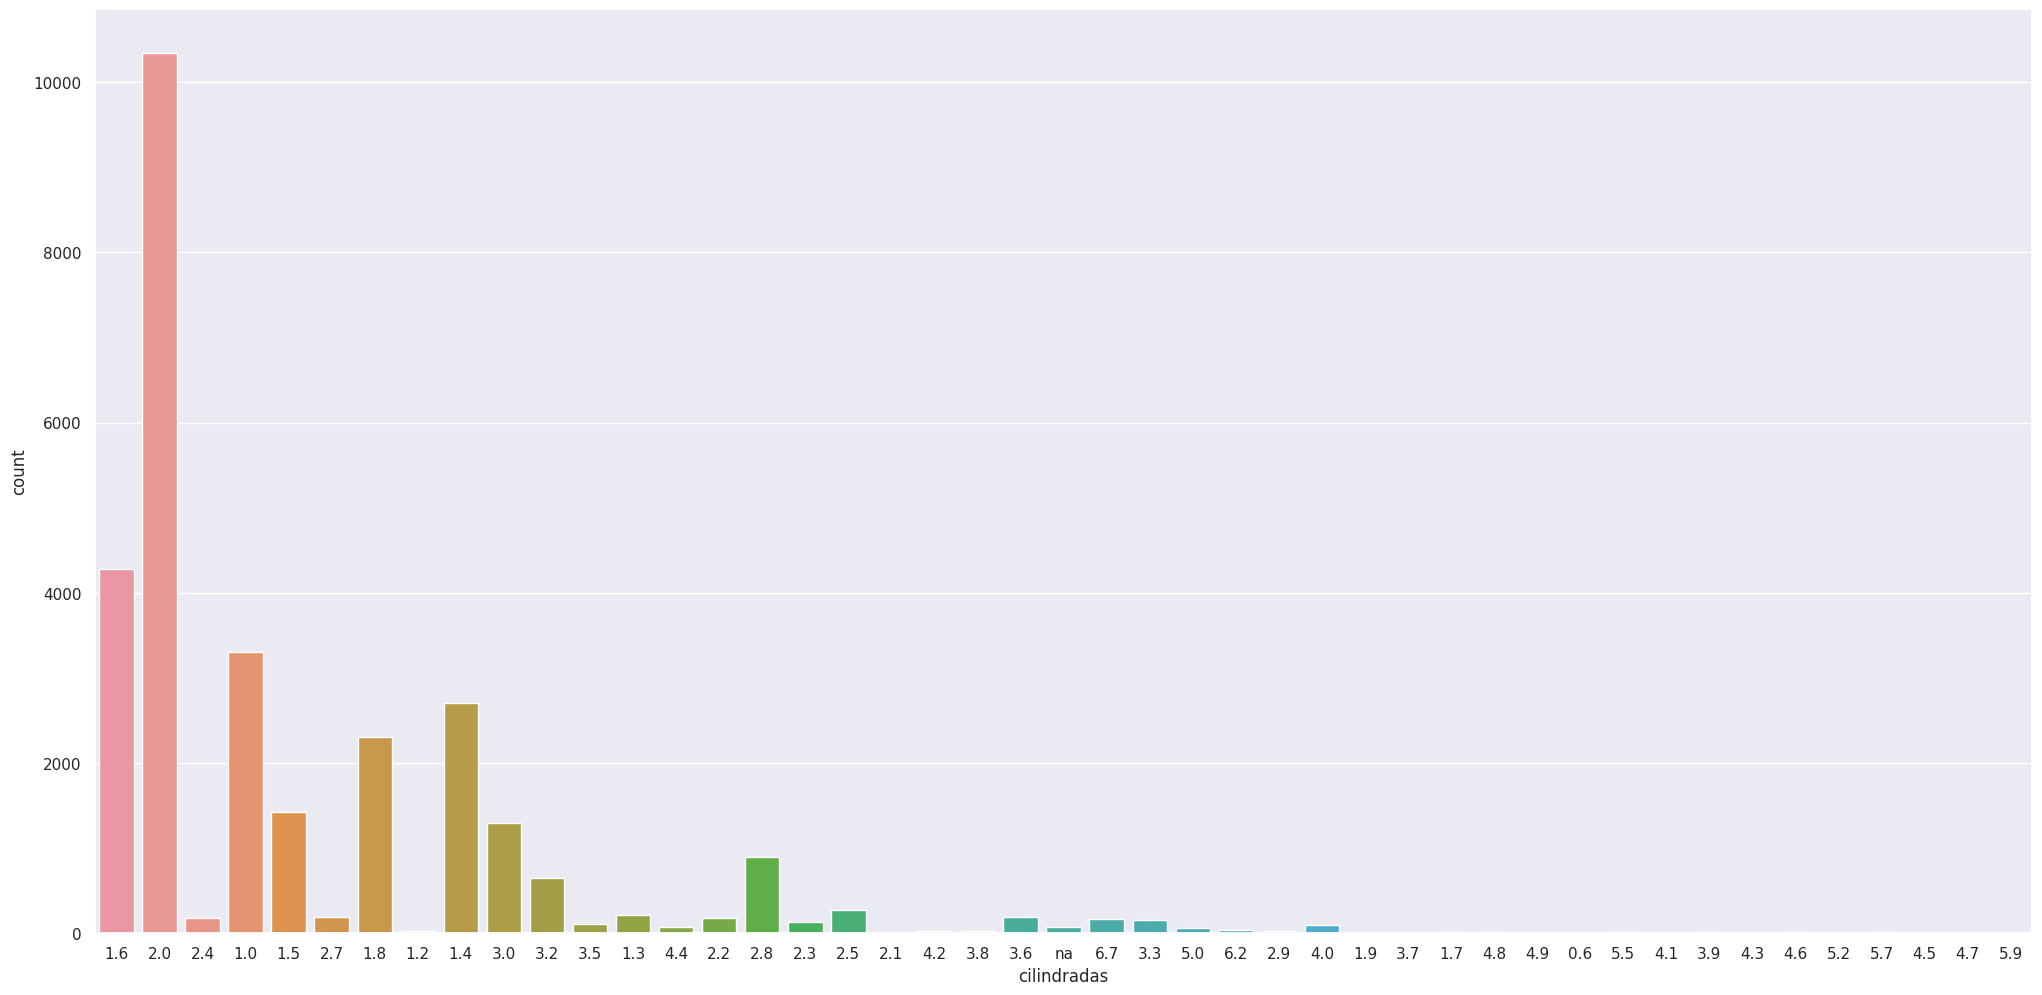

In [240]:
sns.countplot(x=df4['cilindradas']);

#### Combustível

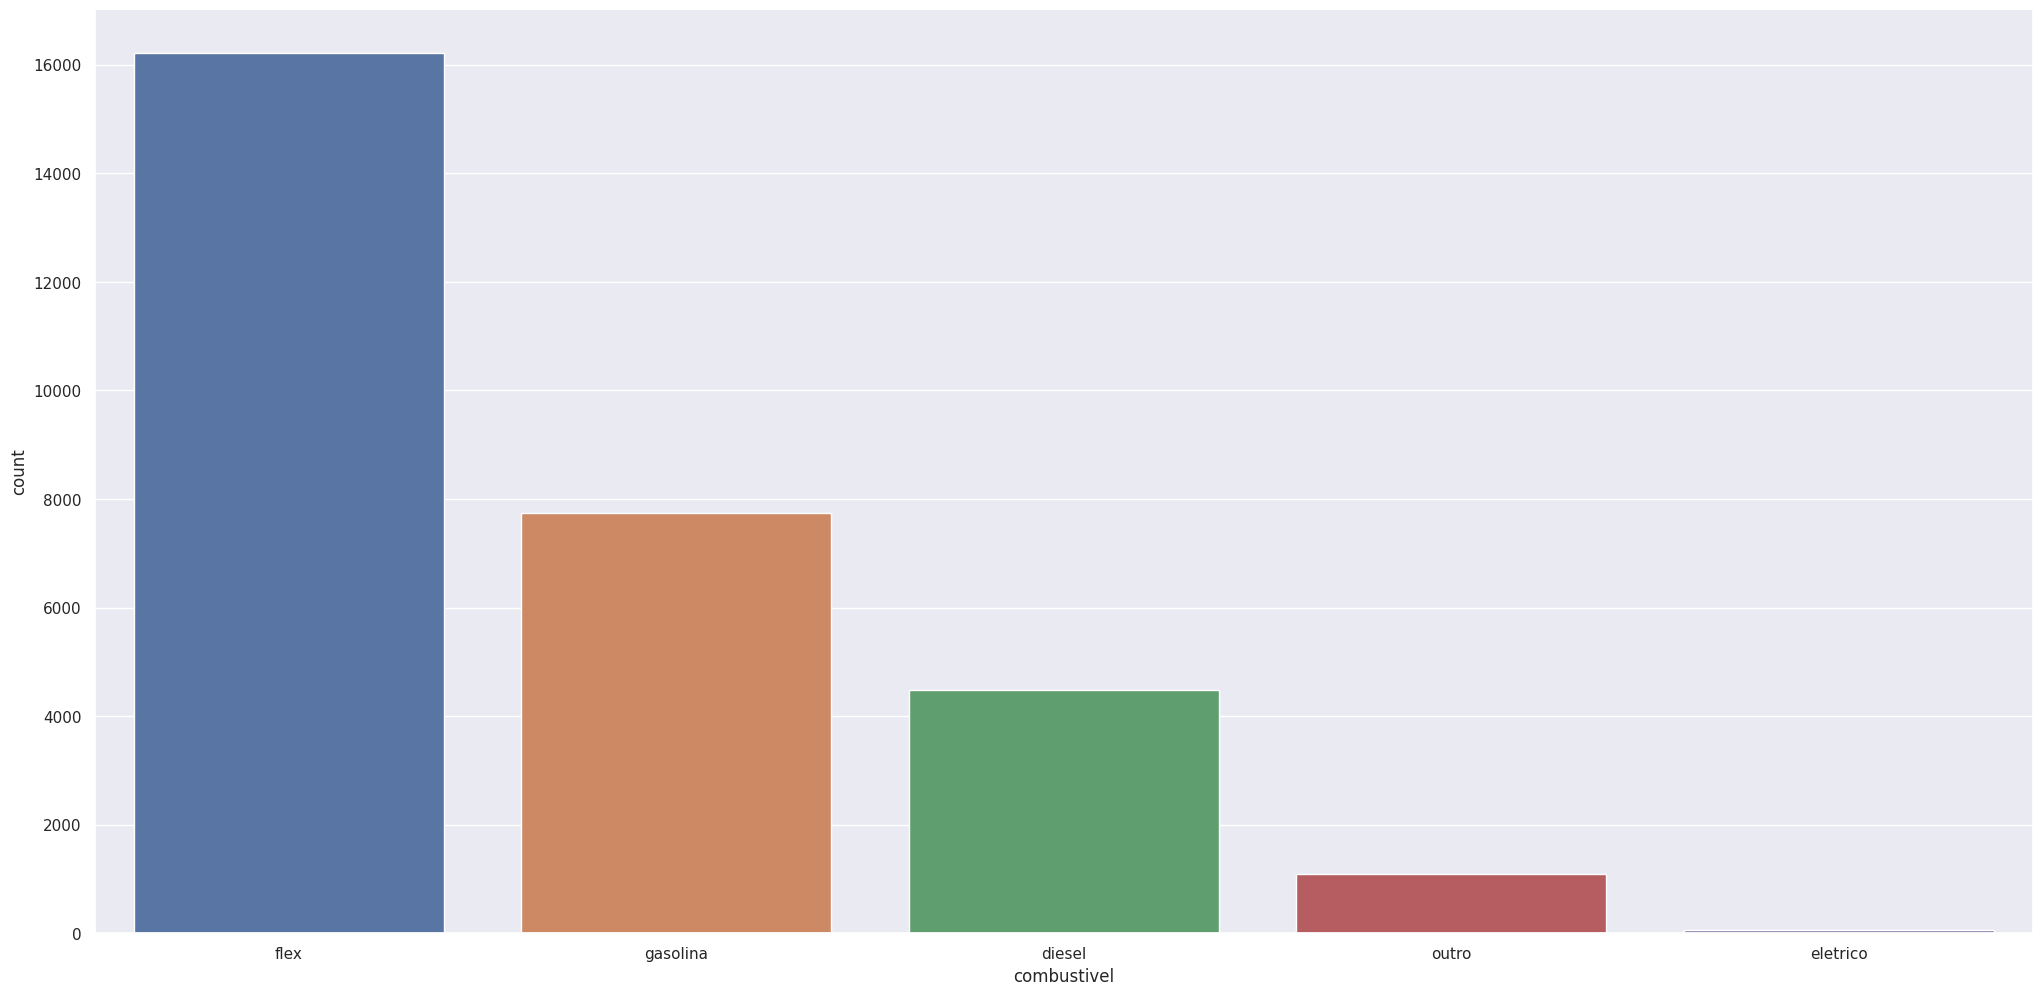

In [242]:
sns.countplot(x=df4['combustivel']);

#### Cambio, Tipo, Cor e Anunciante

In [233]:
features = ['cambio', 'tipo', 'cor', 'anunciante']

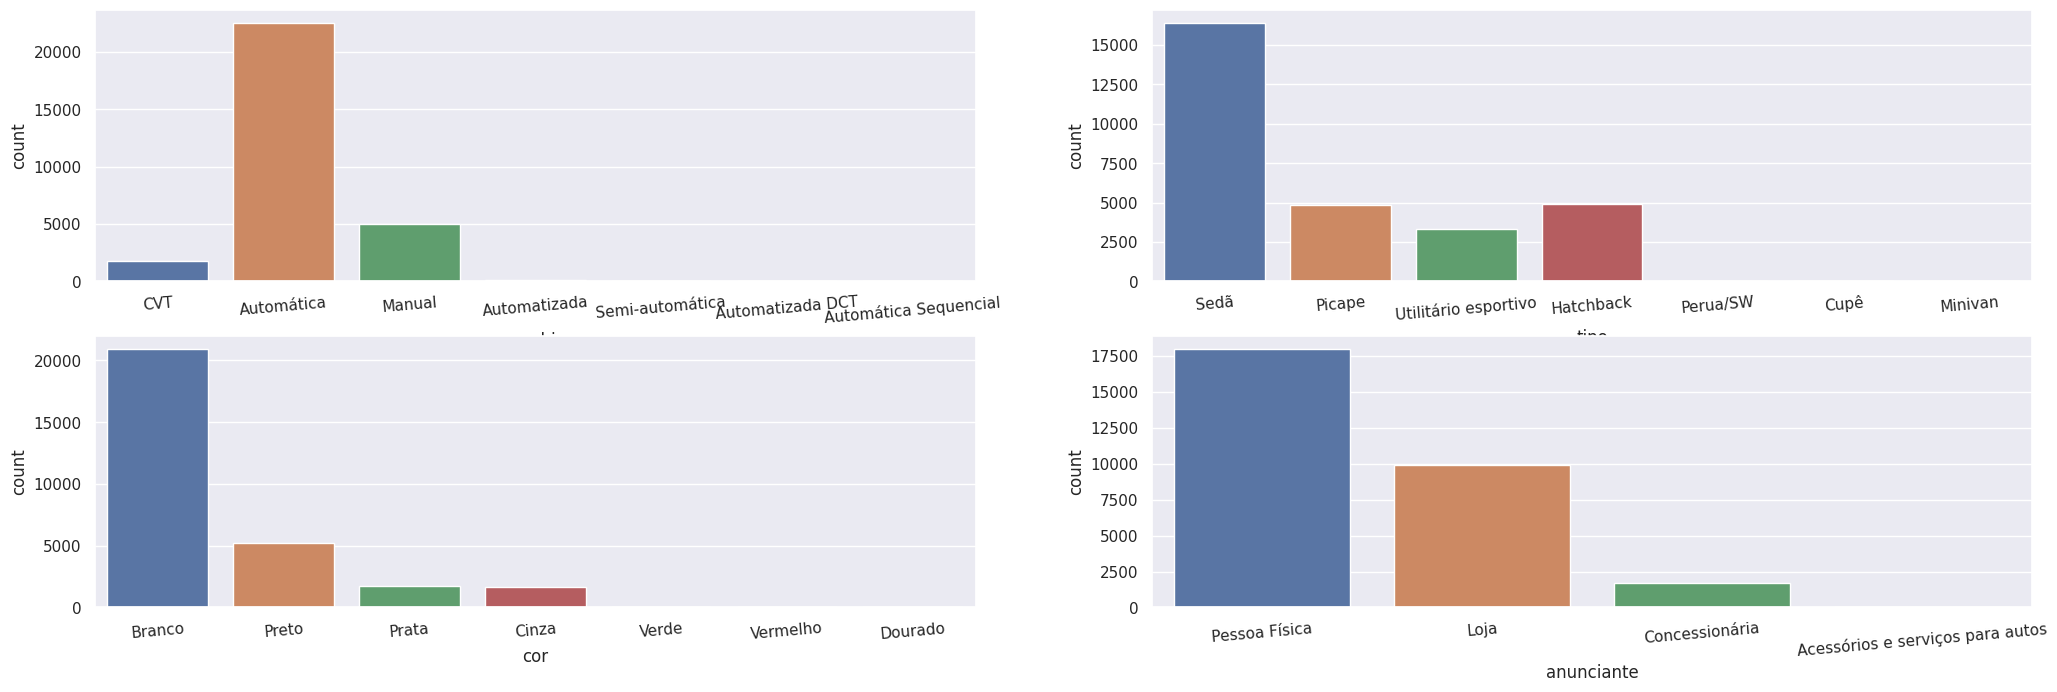

In [238]:
for index, feature in enumerate(features, start=1):
    plt.subplot(3, 2, index)
    sns.countplot(x=feature, data=df4)
    plt.xticks(rotation=5)

#### Variáveis Binárias

In [221]:
list_features = ['blindado', 'tipo_vendedor', 'delivery', 'troca', 'aceita_troca', 'unico_dono',
                 'revisoes_concessionaria', 'ipva', 'licenciado', 'garantia_fabrica', 'revisoes_agenda', 'turbo']

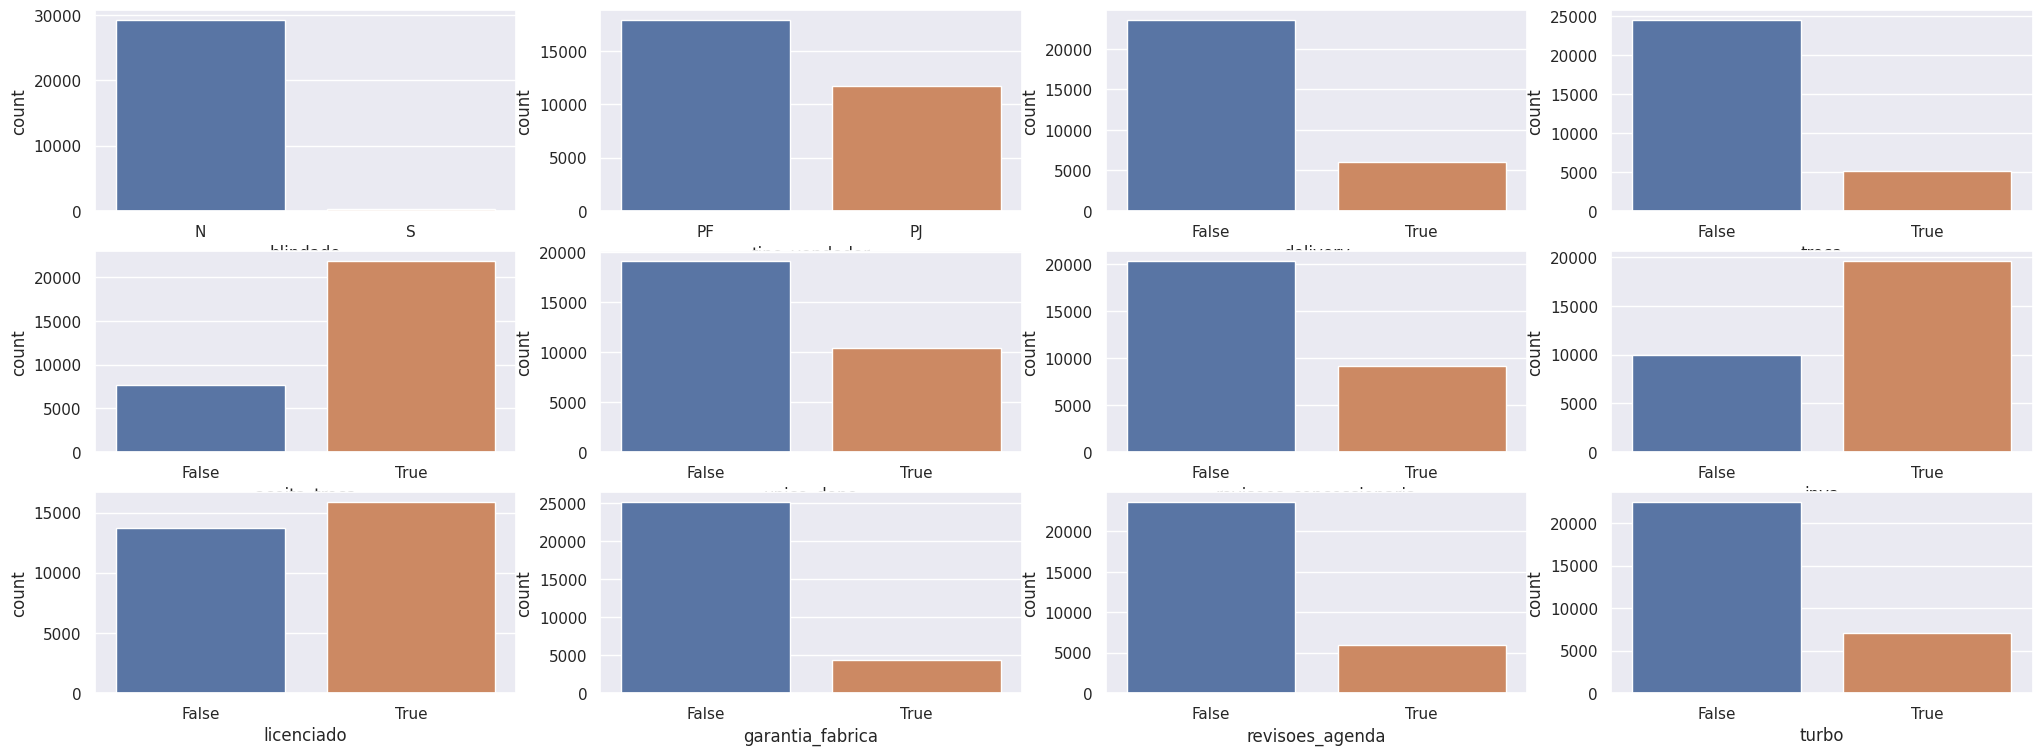

In [222]:
for index, feature in enumerate(list_features, start=1):
    plt.subplot(4, 4, index)
    sns.countplot(x=feature, data=df4)

## 4.2 Análise Bivariada

### H1. Carros com motores flex são mais caros.
**FALSA.** Carros com MOTORES FLEX são MAIS BARATOS que os outros.

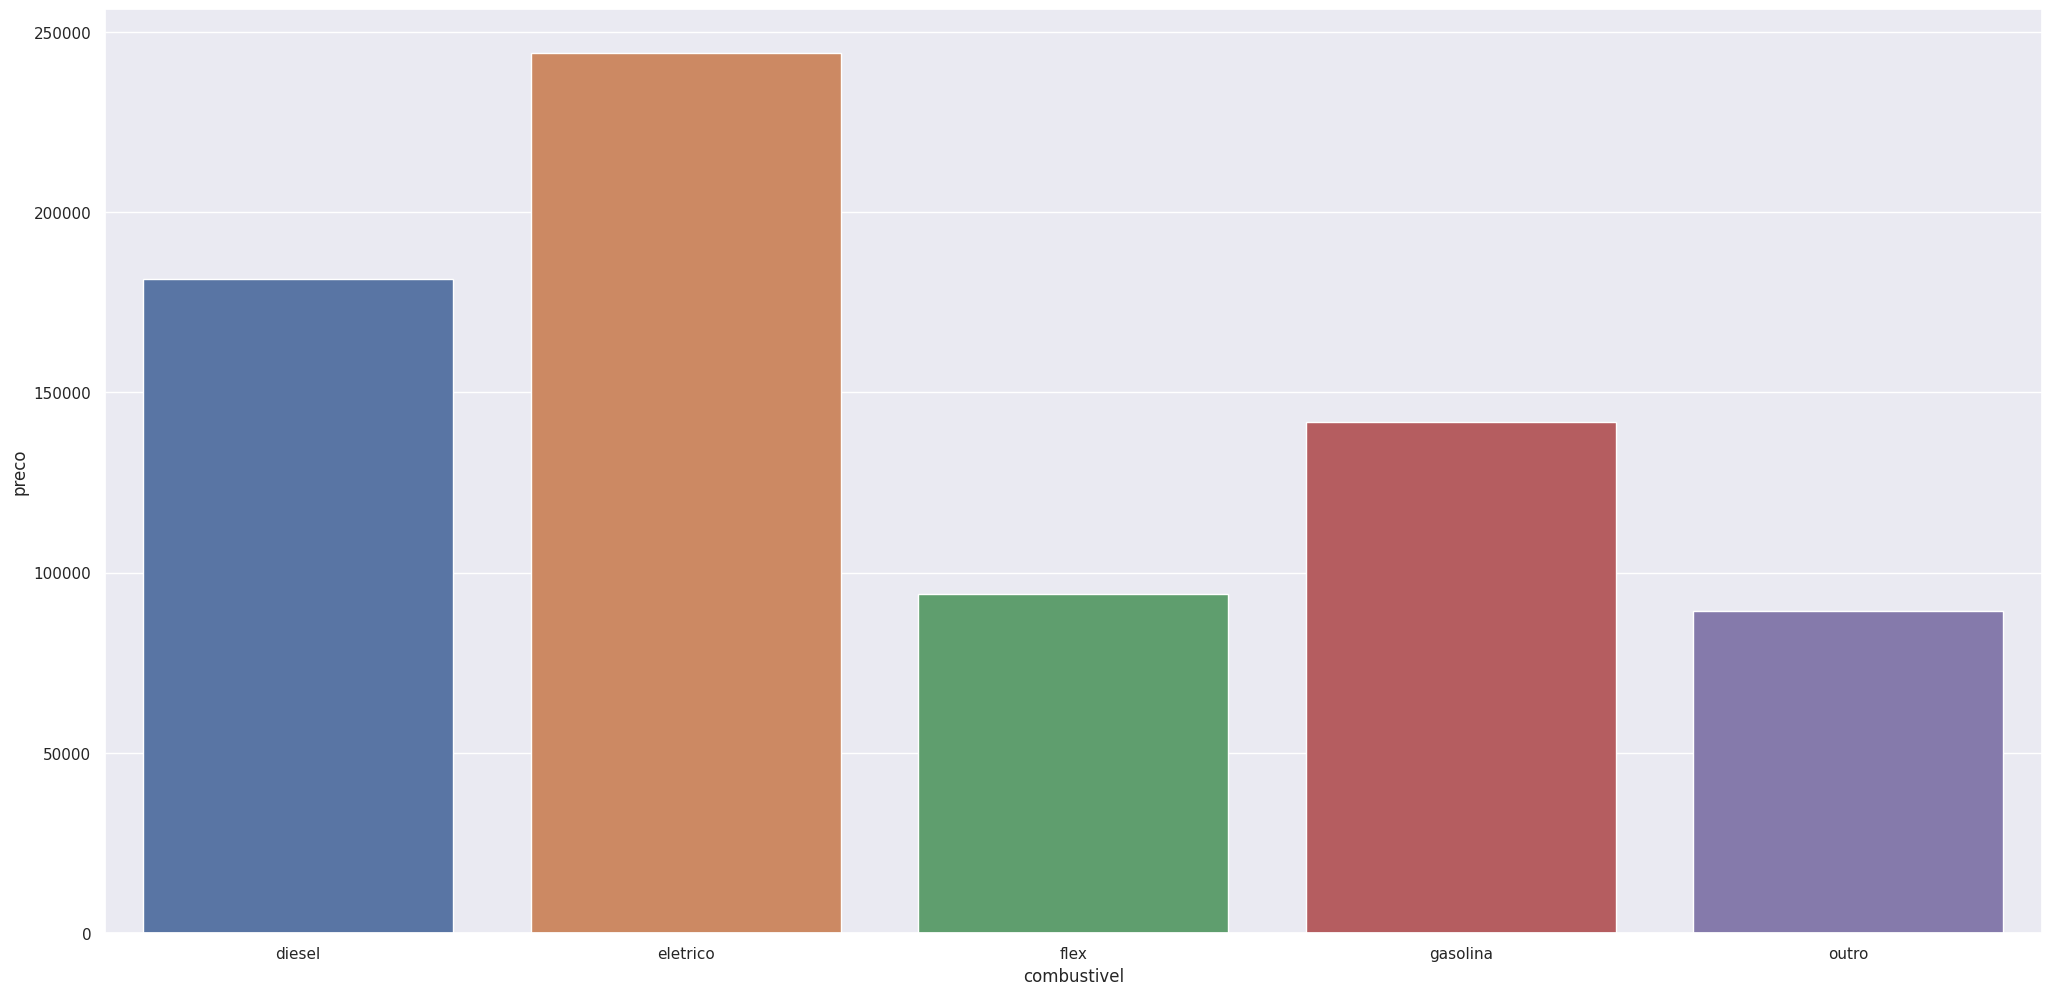

In [251]:
aux1 = df4[['combustivel', 'preco']].groupby('combustivel').median().reset_index()
sns.barplot(aux1, x='combustivel', y='preco');

### H2. Carros sem alterações (blindagem) são mais caros.
**FALSA.** Carros SEM BLINDAGEM são MAIS BARATOS.

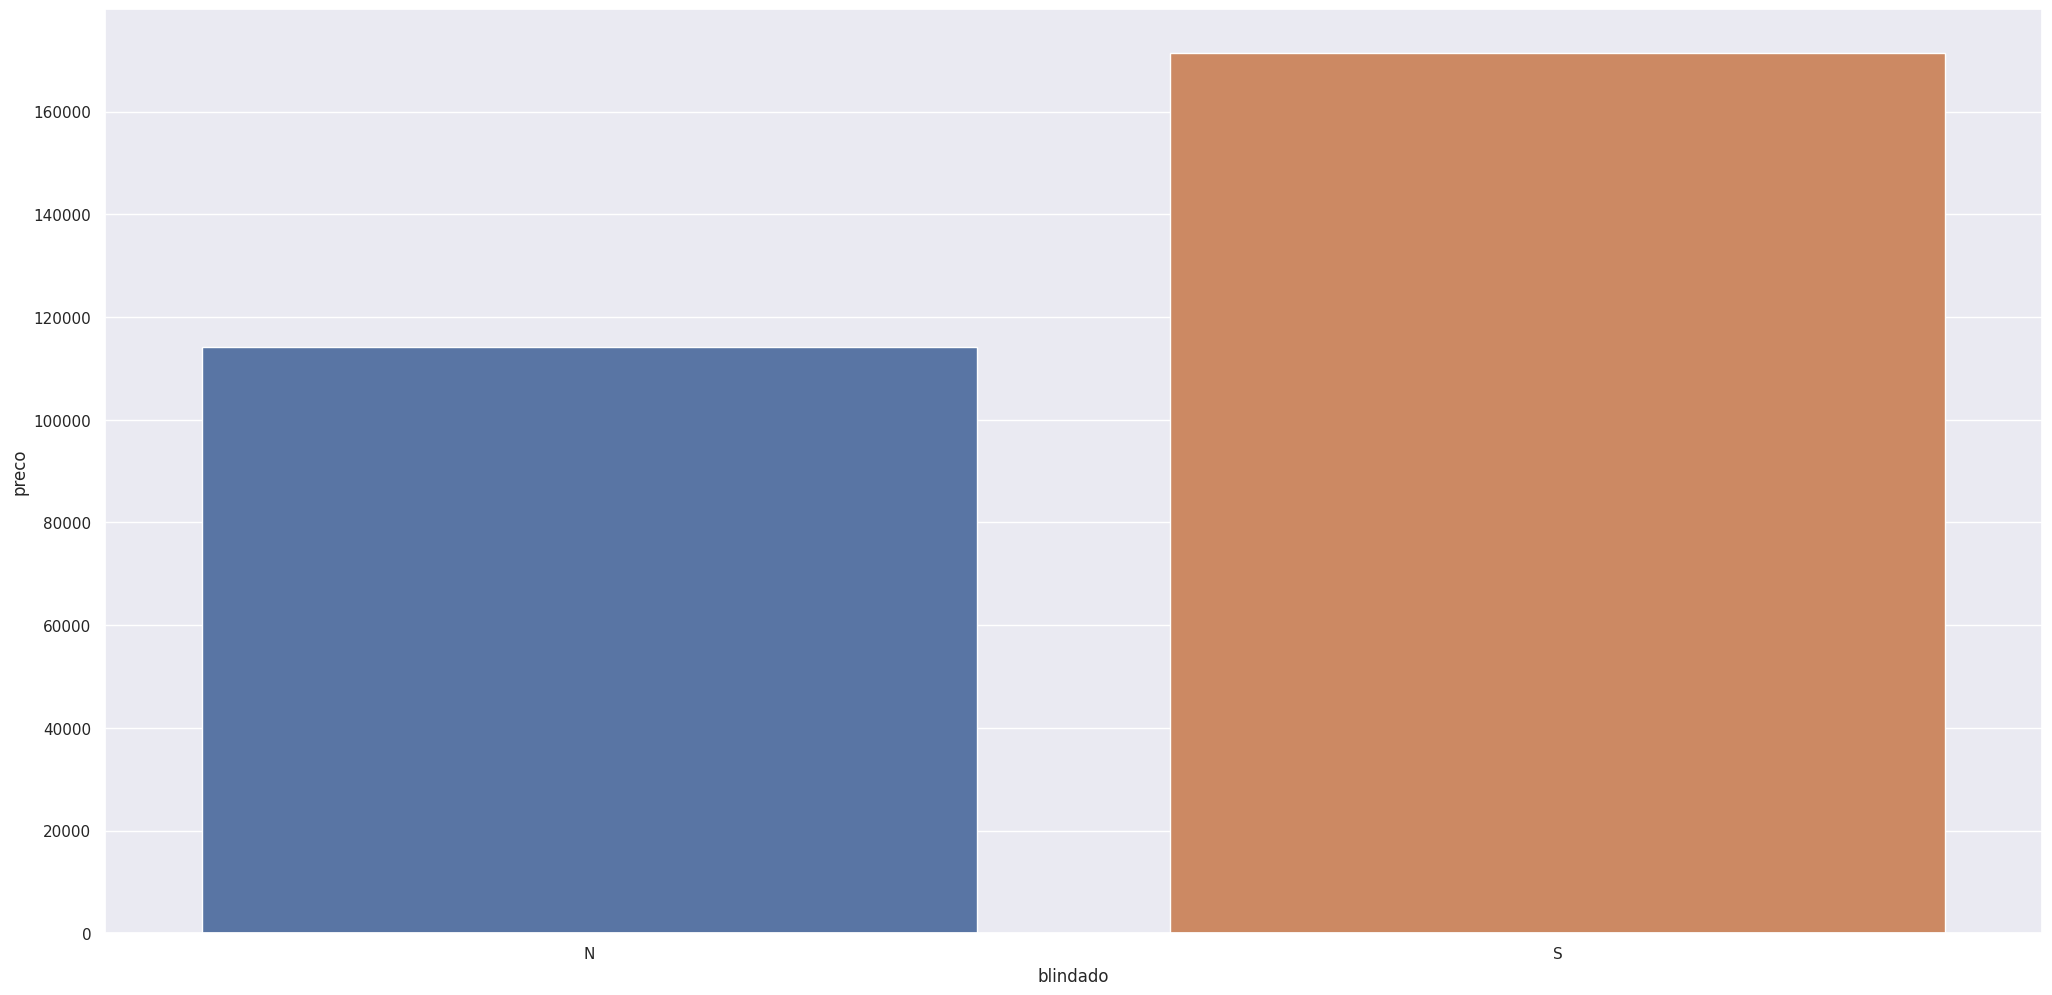

In [255]:
aux1 = df4[['blindado', 'preco']].groupby('blindado').median().reset_index()
sns.barplot(aux1, x='blindado', y='preco');

### H3. Carros com ano de fabricação mais recentes (>2015) são mais caros.
**VERDADEIRA.** Carros com ANO DE FABRICACÃO RECENTE (2011 em diante) são MAIS CAROS.

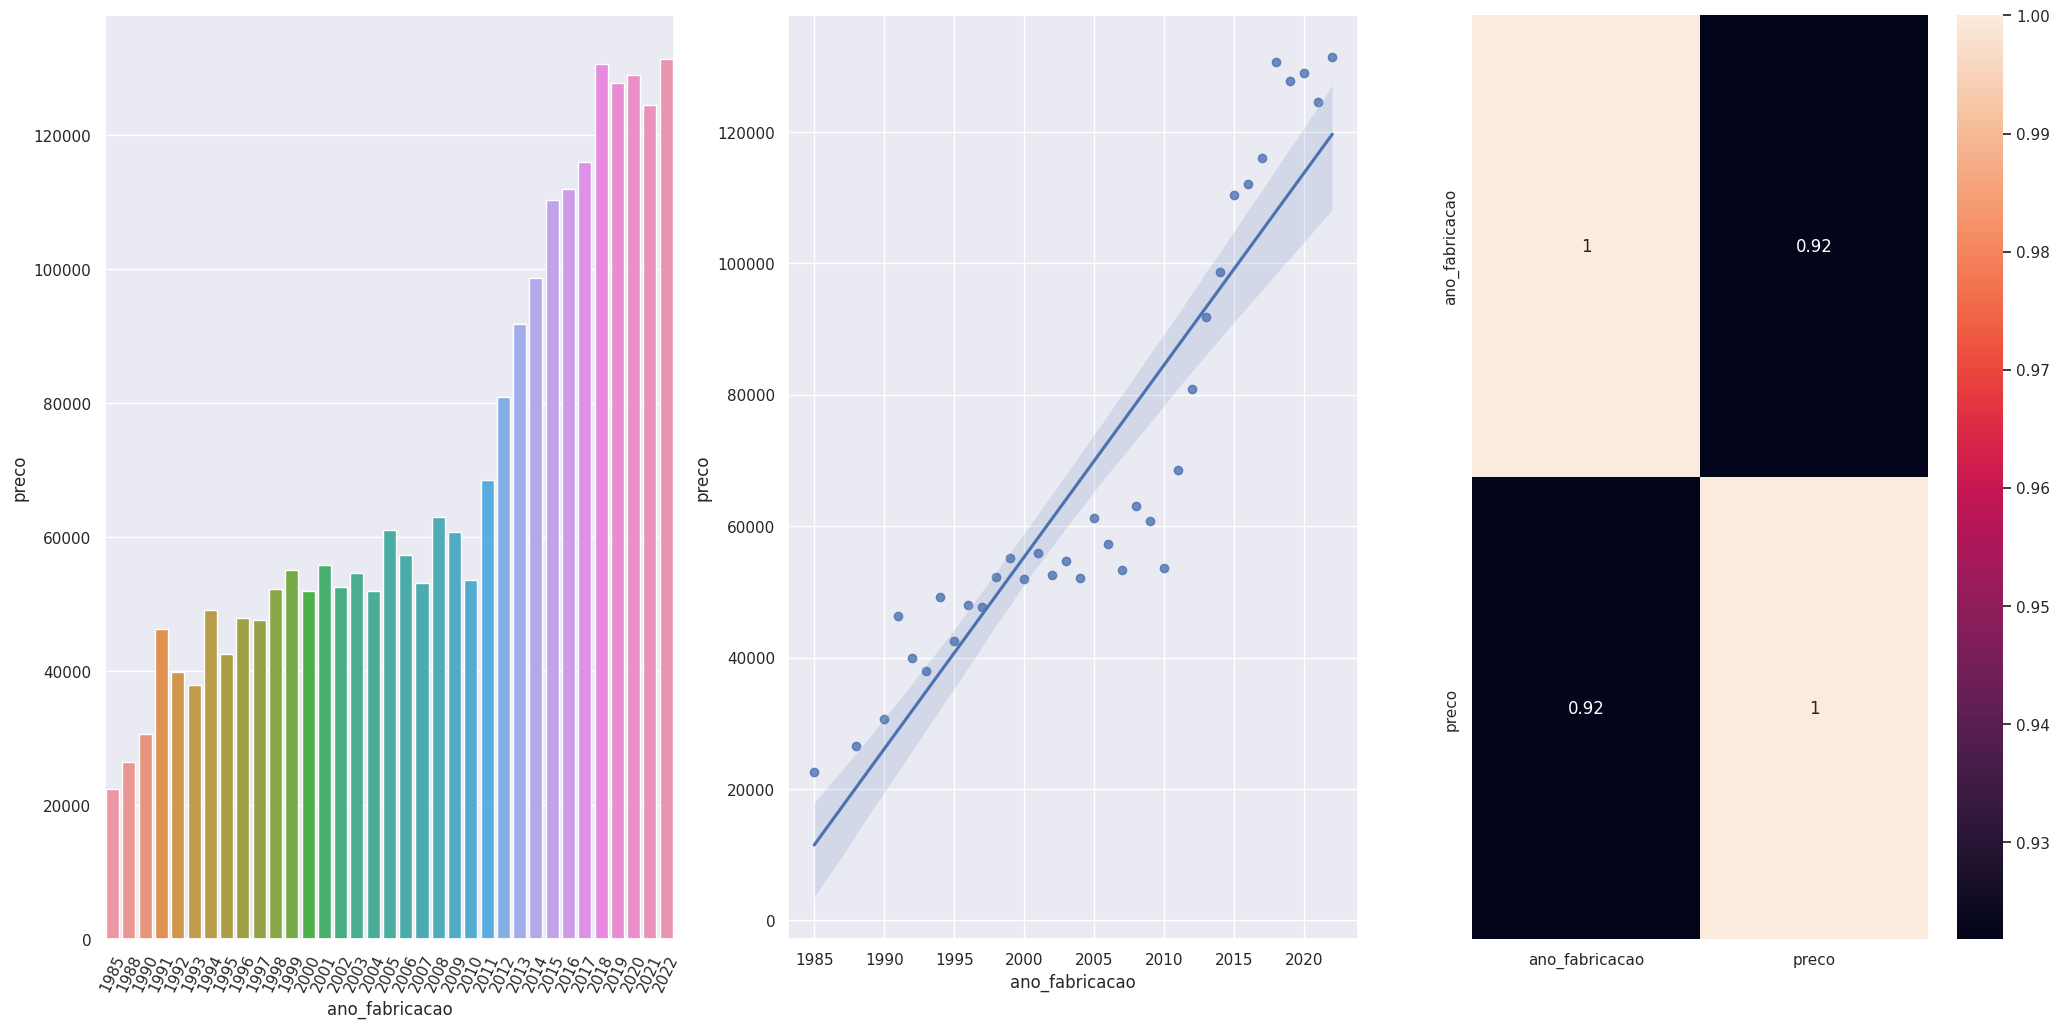

In [280]:
aux1 = df4[['ano_fabricacao', 'preco']].groupby('ano_fabricacao').median().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(aux1, x='ano_fabricacao', y='preco')
plt.xticks(rotation=65)

plt.subplot(1, 3, 2)
sns.regplot(x='ano_fabricacao', y='preco', data=aux1)

plt.subplot(1, 3 , 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Carros com modelos mais recentes (>2015) são mais caros.
**VERDADEIRA.** Carros com modelos MAIS RECENTES (>2014) são MAIS CAROS.

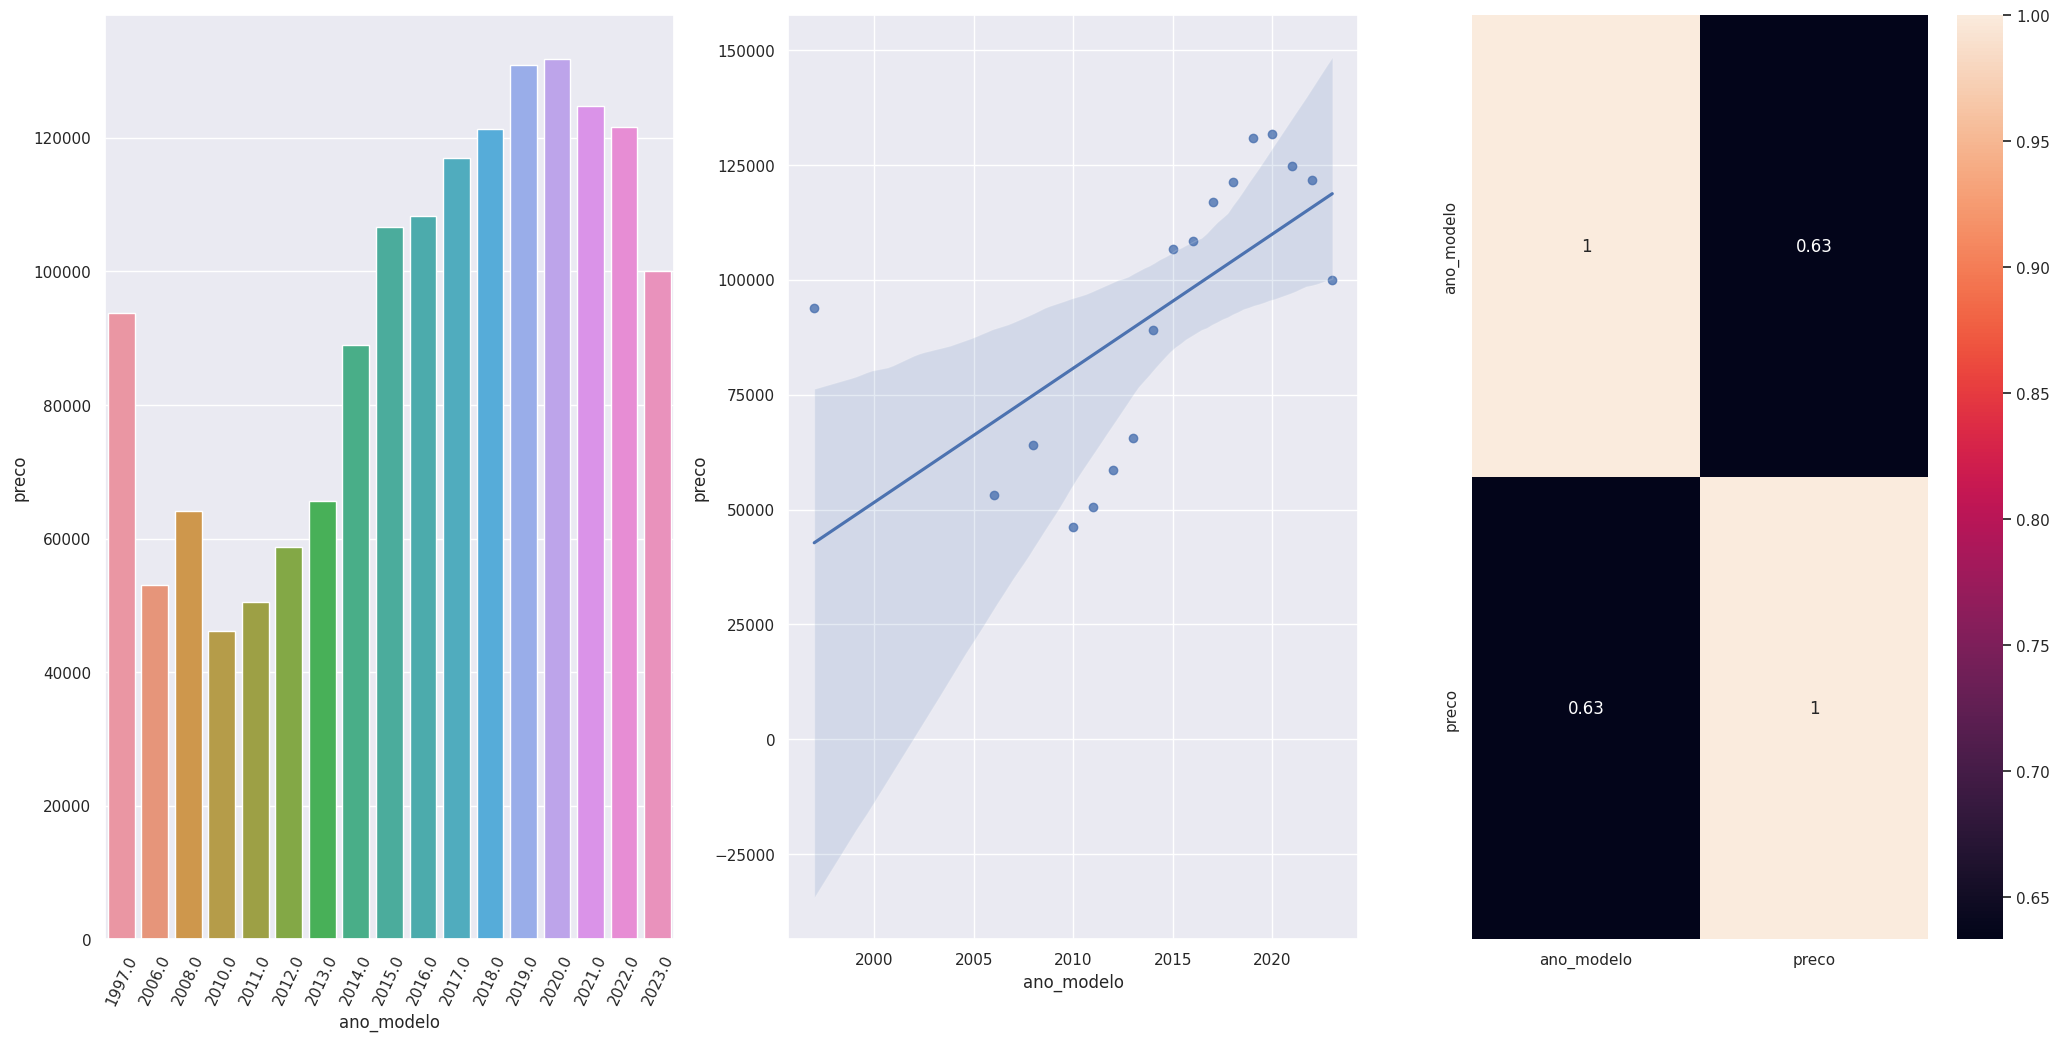

In [281]:
aux1 = df4[['ano_modelo', 'preco']].groupby('ano_modelo').median().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(aux1, x='ano_modelo', y='preco')
plt.xticks(rotation=65)

plt.subplot(1, 3, 2)
sns.regplot(x='ano_modelo', y='preco', data=aux1)

plt.subplot(1, 3 , 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H5. Carros brancos são mais caros.
**FALSA.** Carros BRANCOS não são MAIS CAROS. Carros CINZA e PRETOS são mais caros.

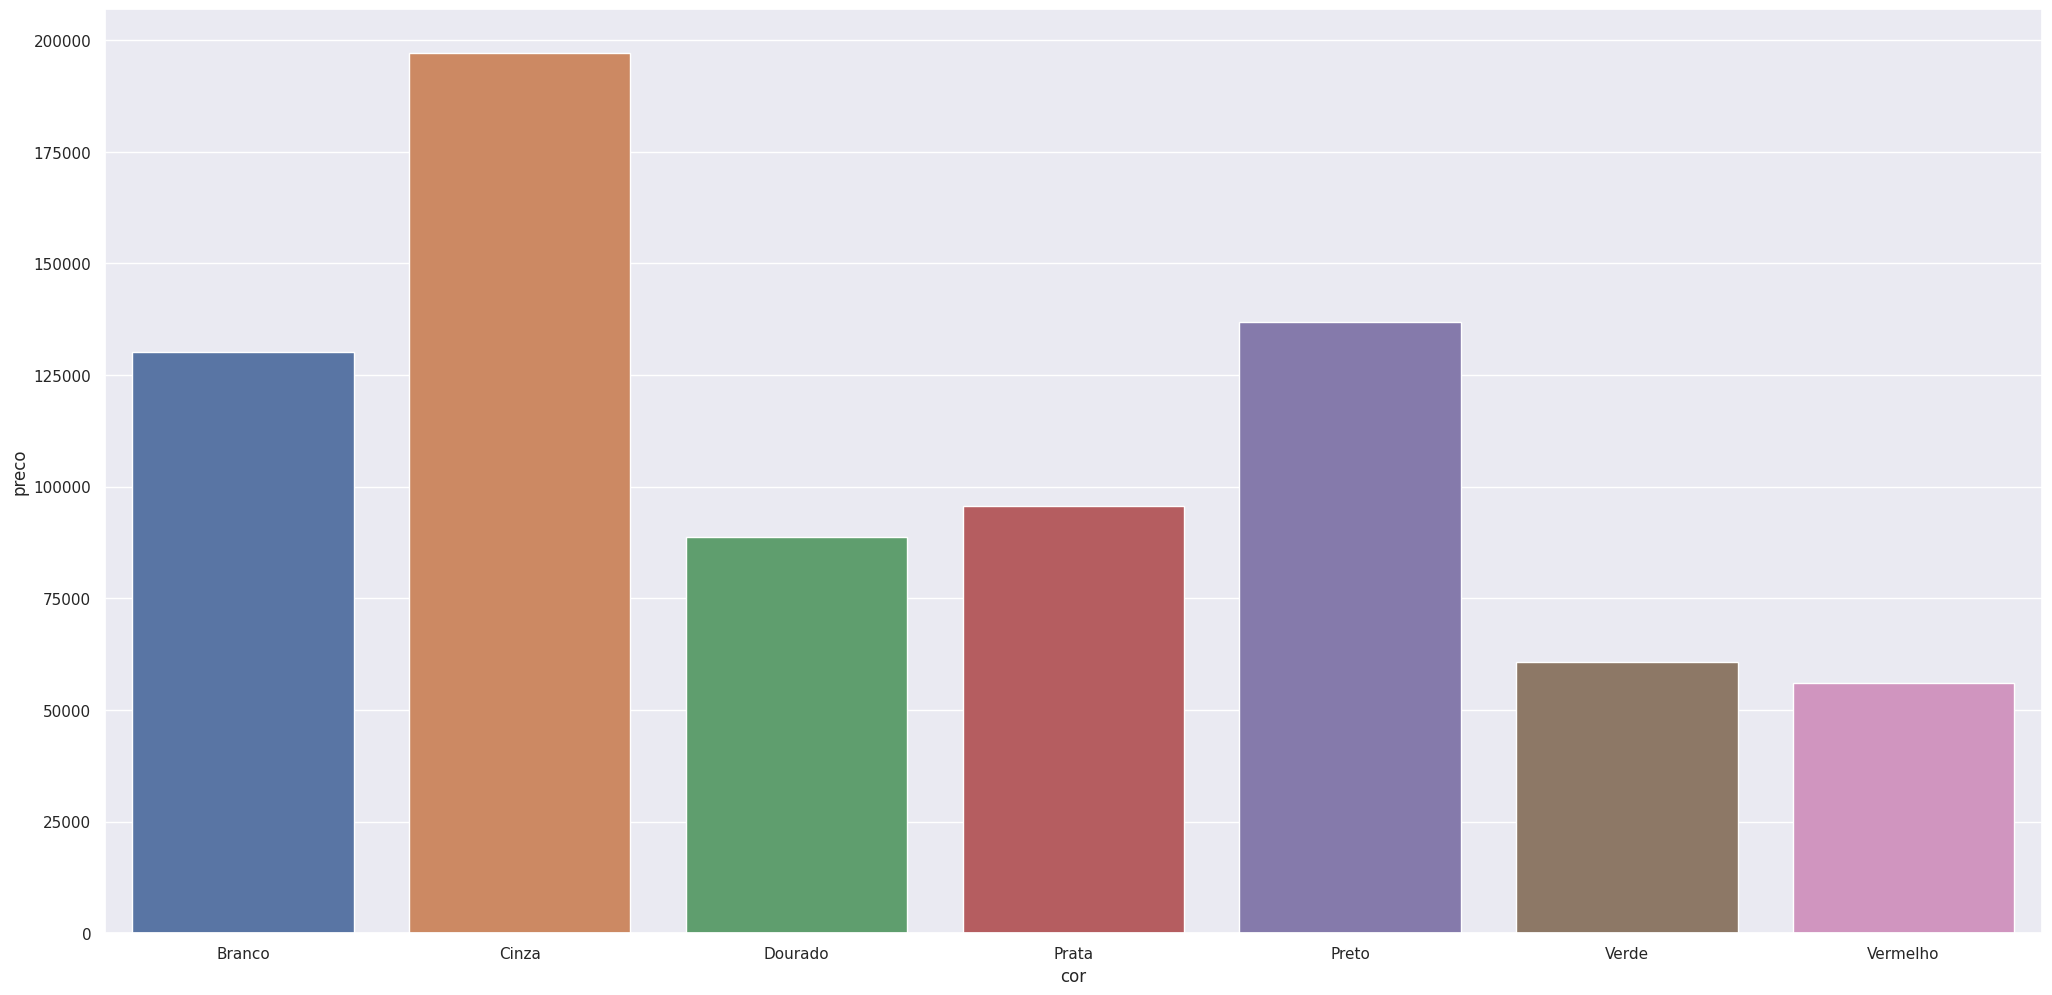

In [262]:
aux1 = df4[['cor', 'preco']].groupby('cor').mean().reset_index()
sns.barplot(aux1, x='cor', y='preco');

### H6. O preço dos veículos é maior no Sudeste.
**FALSA.** O preço dos carros NÃO É MAIOR no SUDESTE. Os maiores estados são SERGIPE e PIAUI.

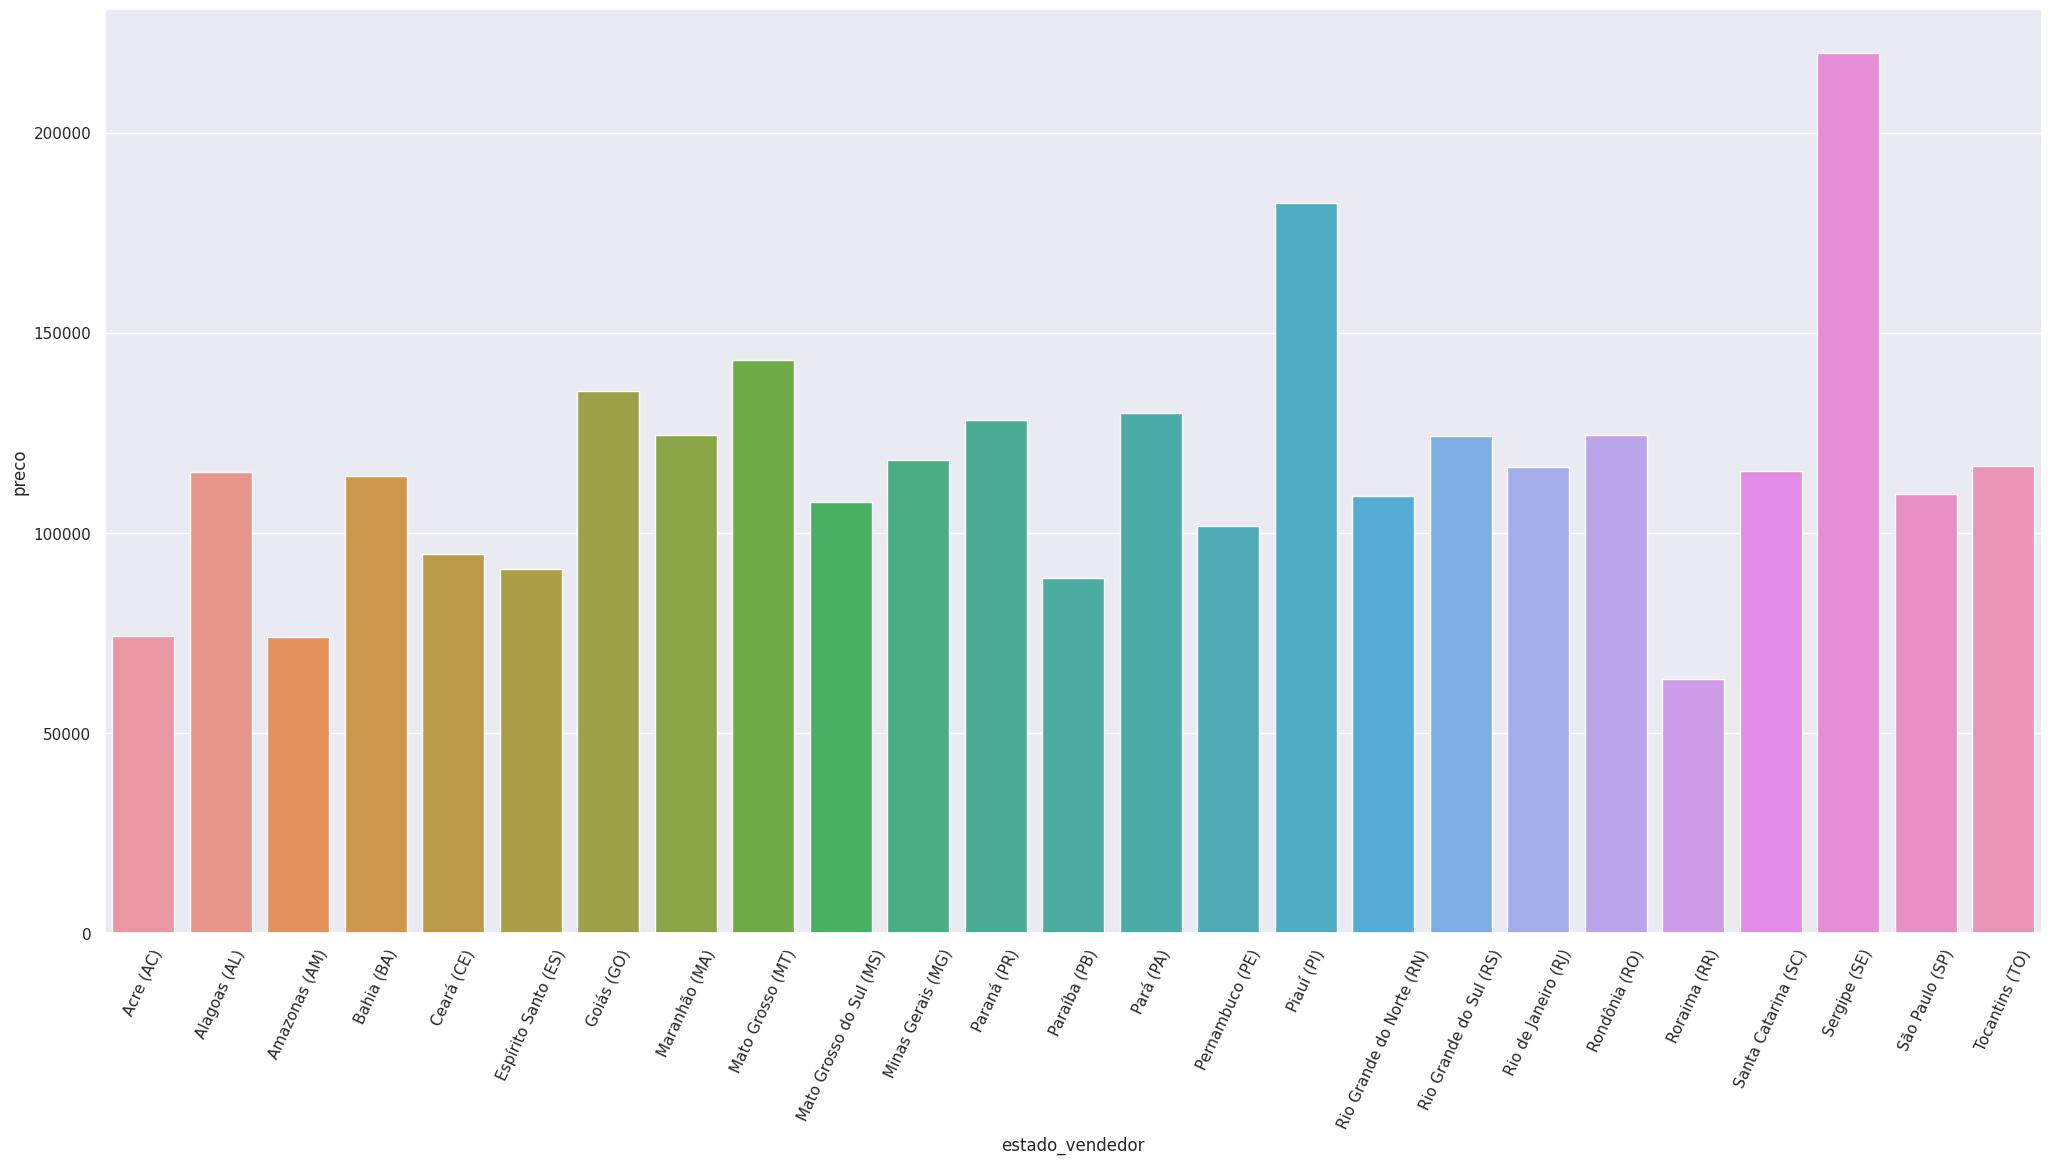

In [270]:
aux1 = df4[['estado_vendedor', 'preco']].groupby('estado_vendedor').median().reset_index()
sns.barplot(aux1, x='estado_vendedor', y='preco')
plt.xticks(rotation=65);

### H7. Caros vendidos por lojas são mais caros.
**FALSA.** Caros vendidos por LOJAS não são MAIS CAROS. Caros vendidos por PESSOAS FÍSICAS são MAIS CAROS.

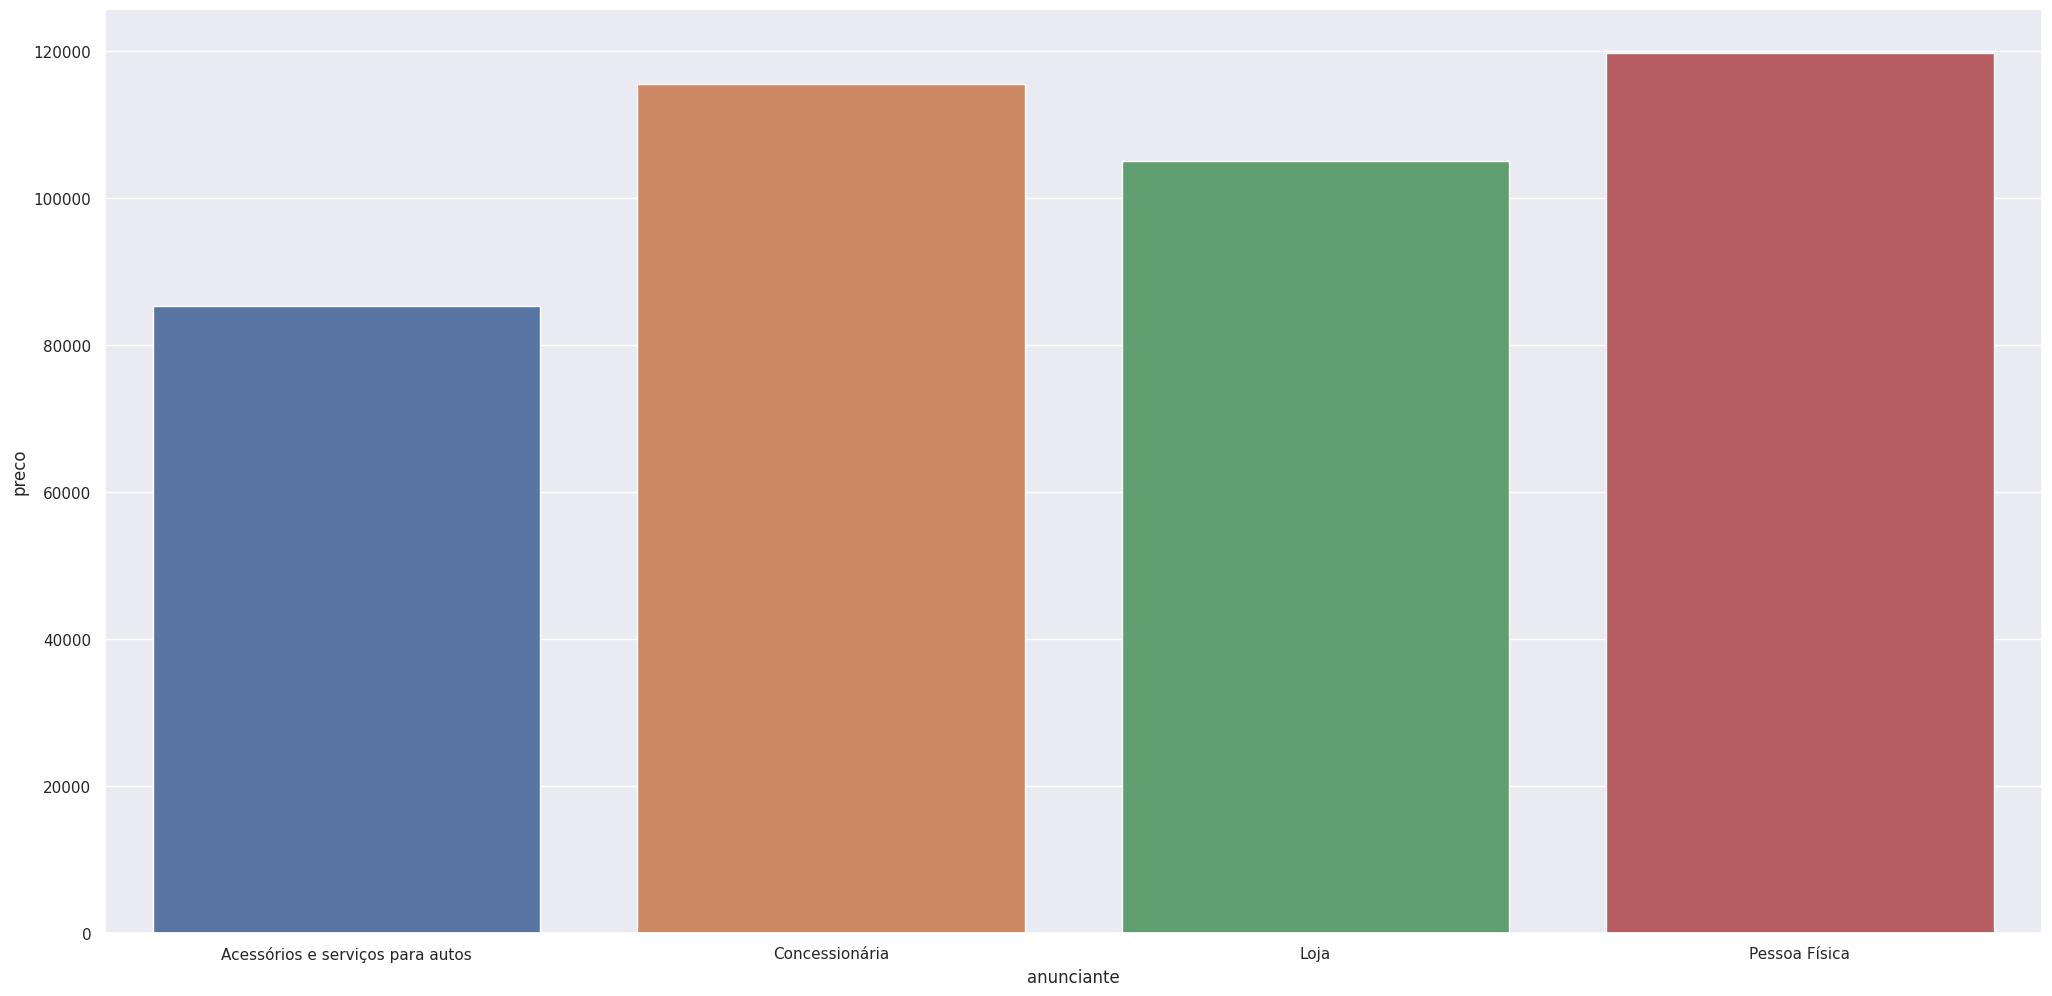

In [276]:
aux1 = df4[['anunciante', 'preco']].groupby('anunciante').median().reset_index()
sns.barplot(aux1, x='anunciante', y='preco');

### H8. Carros com donos únicos são mais caros.
**VERDADEIRA.** Carros com ÚNICOS DONOS são MAIS CAROS.

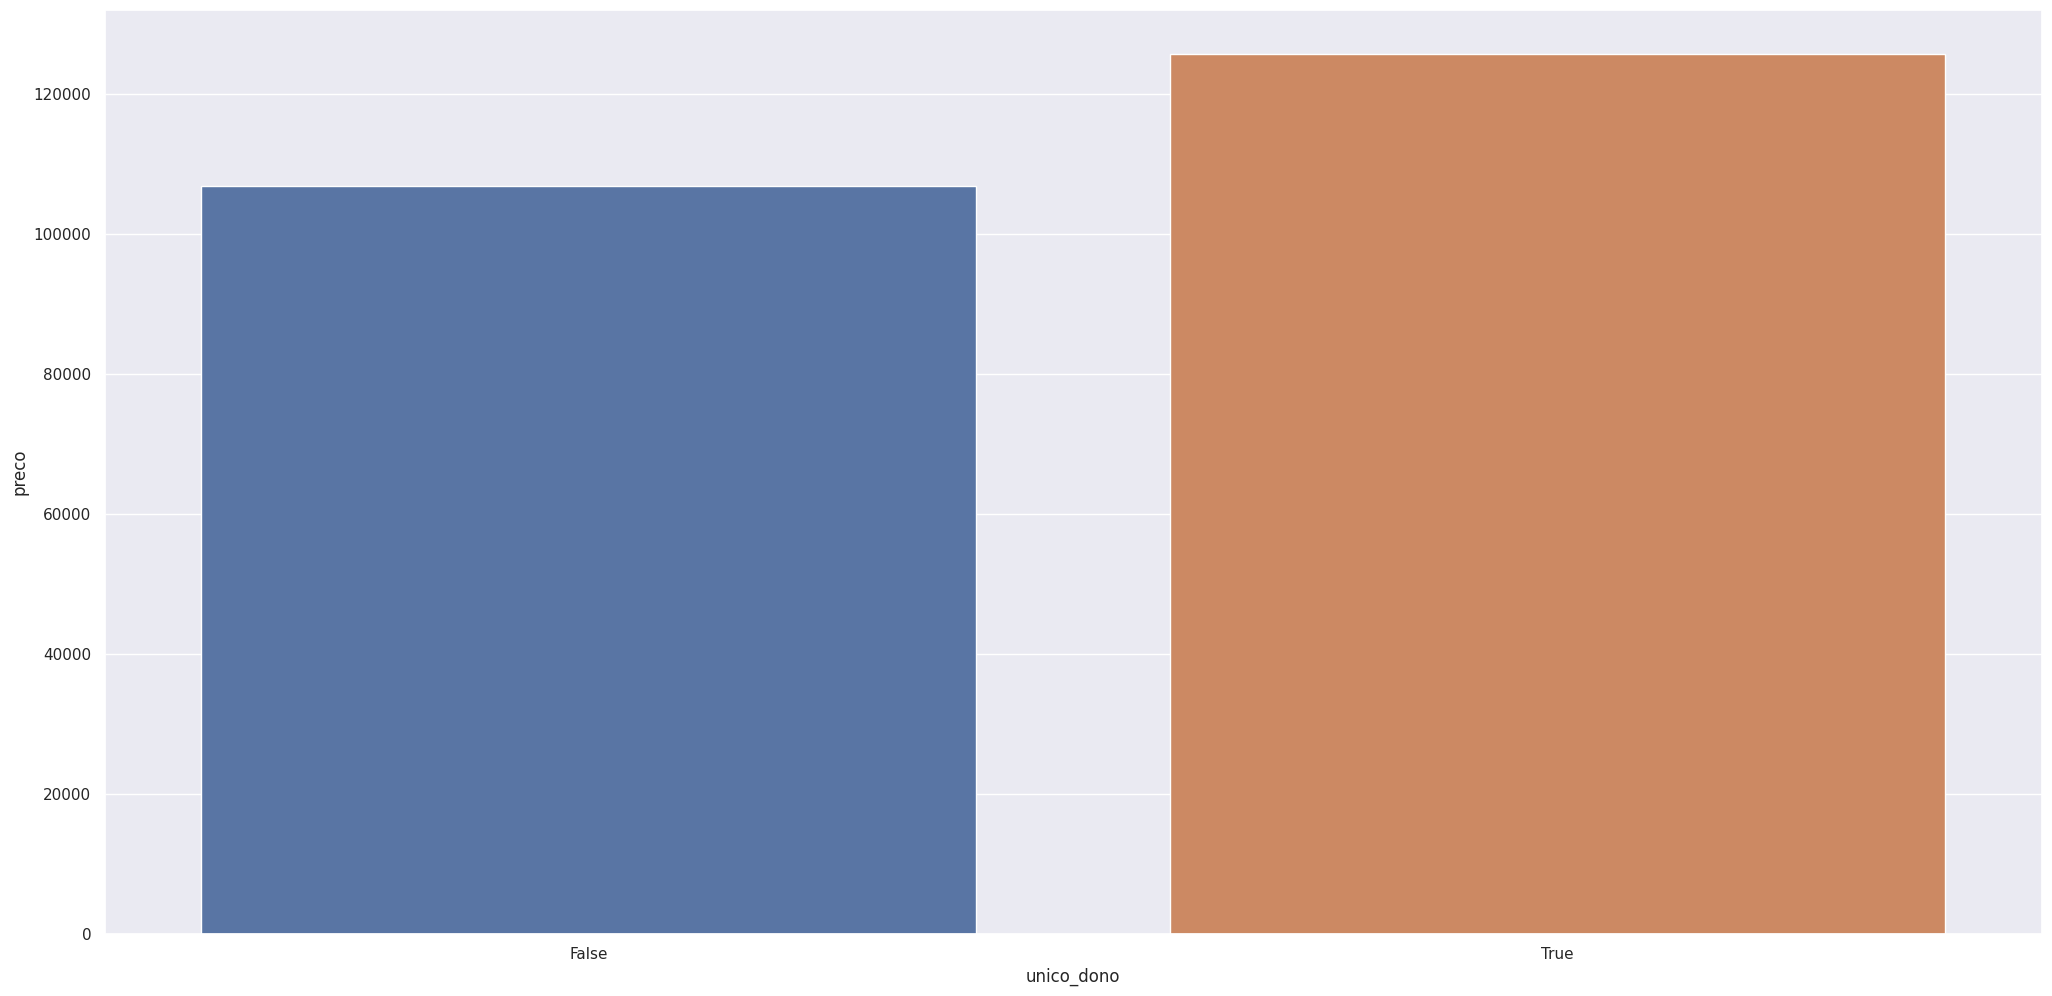

In [278]:
aux1 = df4[['unico_dono', 'preco']].groupby('unico_dono').median().reset_index()
sns.barplot(aux1, x='unico_dono', y='preco');

### H9. Carros com mais quilometragem são mais baratos.
**VERDADEIRA.** Carros com MAIS QUILOMETRAGEM são MAIS CAROS.

/tmp/ipykernel_21255/514164808.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


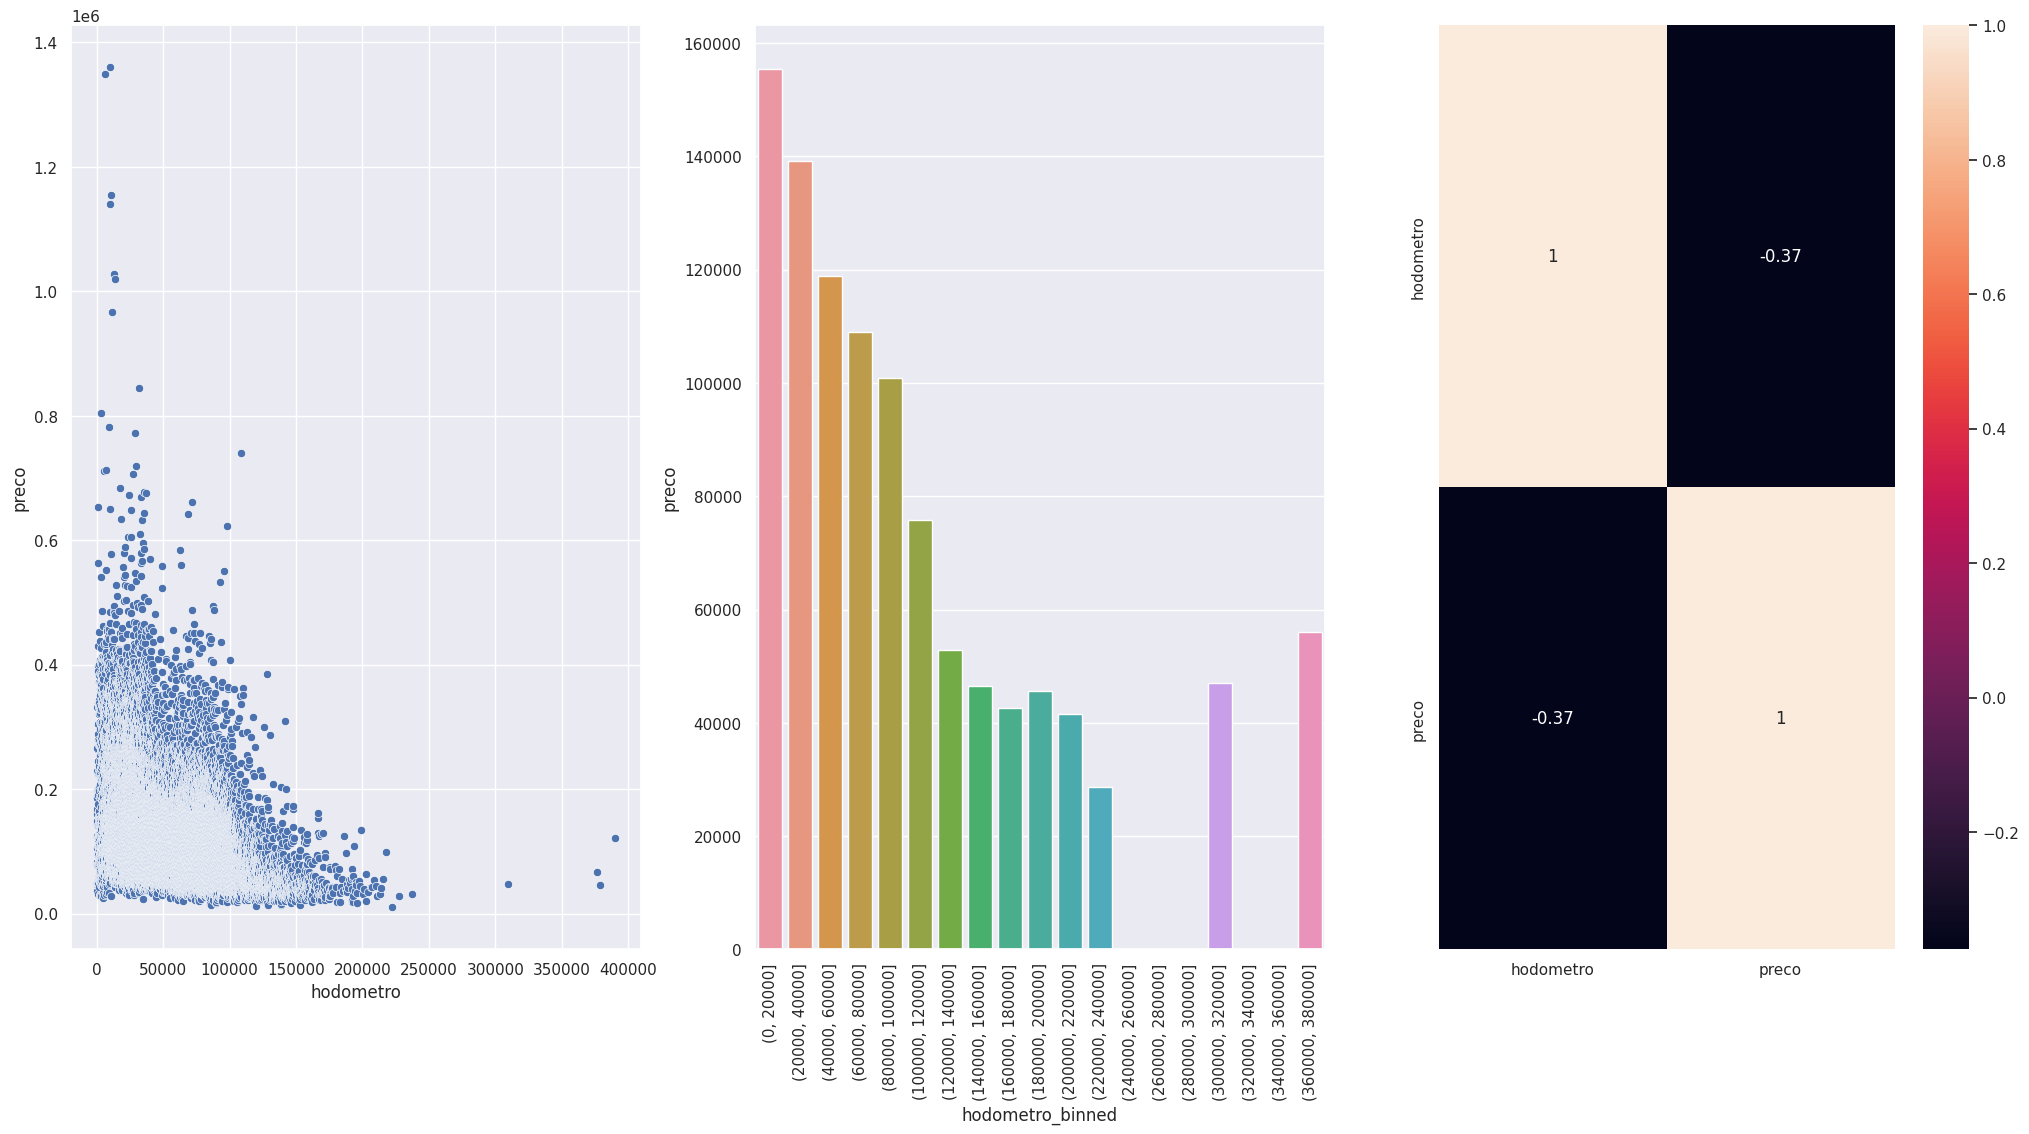

In [294]:
aux1 = df4[['hodometro', 'preco']].groupby('hodometro').mean().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='hodometro', y='preco', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 400000, 20000))
aux1['hodometro_binned'] = pd.cut(aux1['hodometro'], bins=bins)
aux2 = aux1[['hodometro_binned', 'preco']].groupby('hodometro_binned').median().reset_index()
plt.xticks(rotation=90)

sns.barplot(data=aux2, x='hodometro_binned', y='preco')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Carros com documentação vencida são mais baratos.
**VERDADEIRA.** Carros com DOCUMENTAÇÃO VENCIDA são MAIS BARATOS.

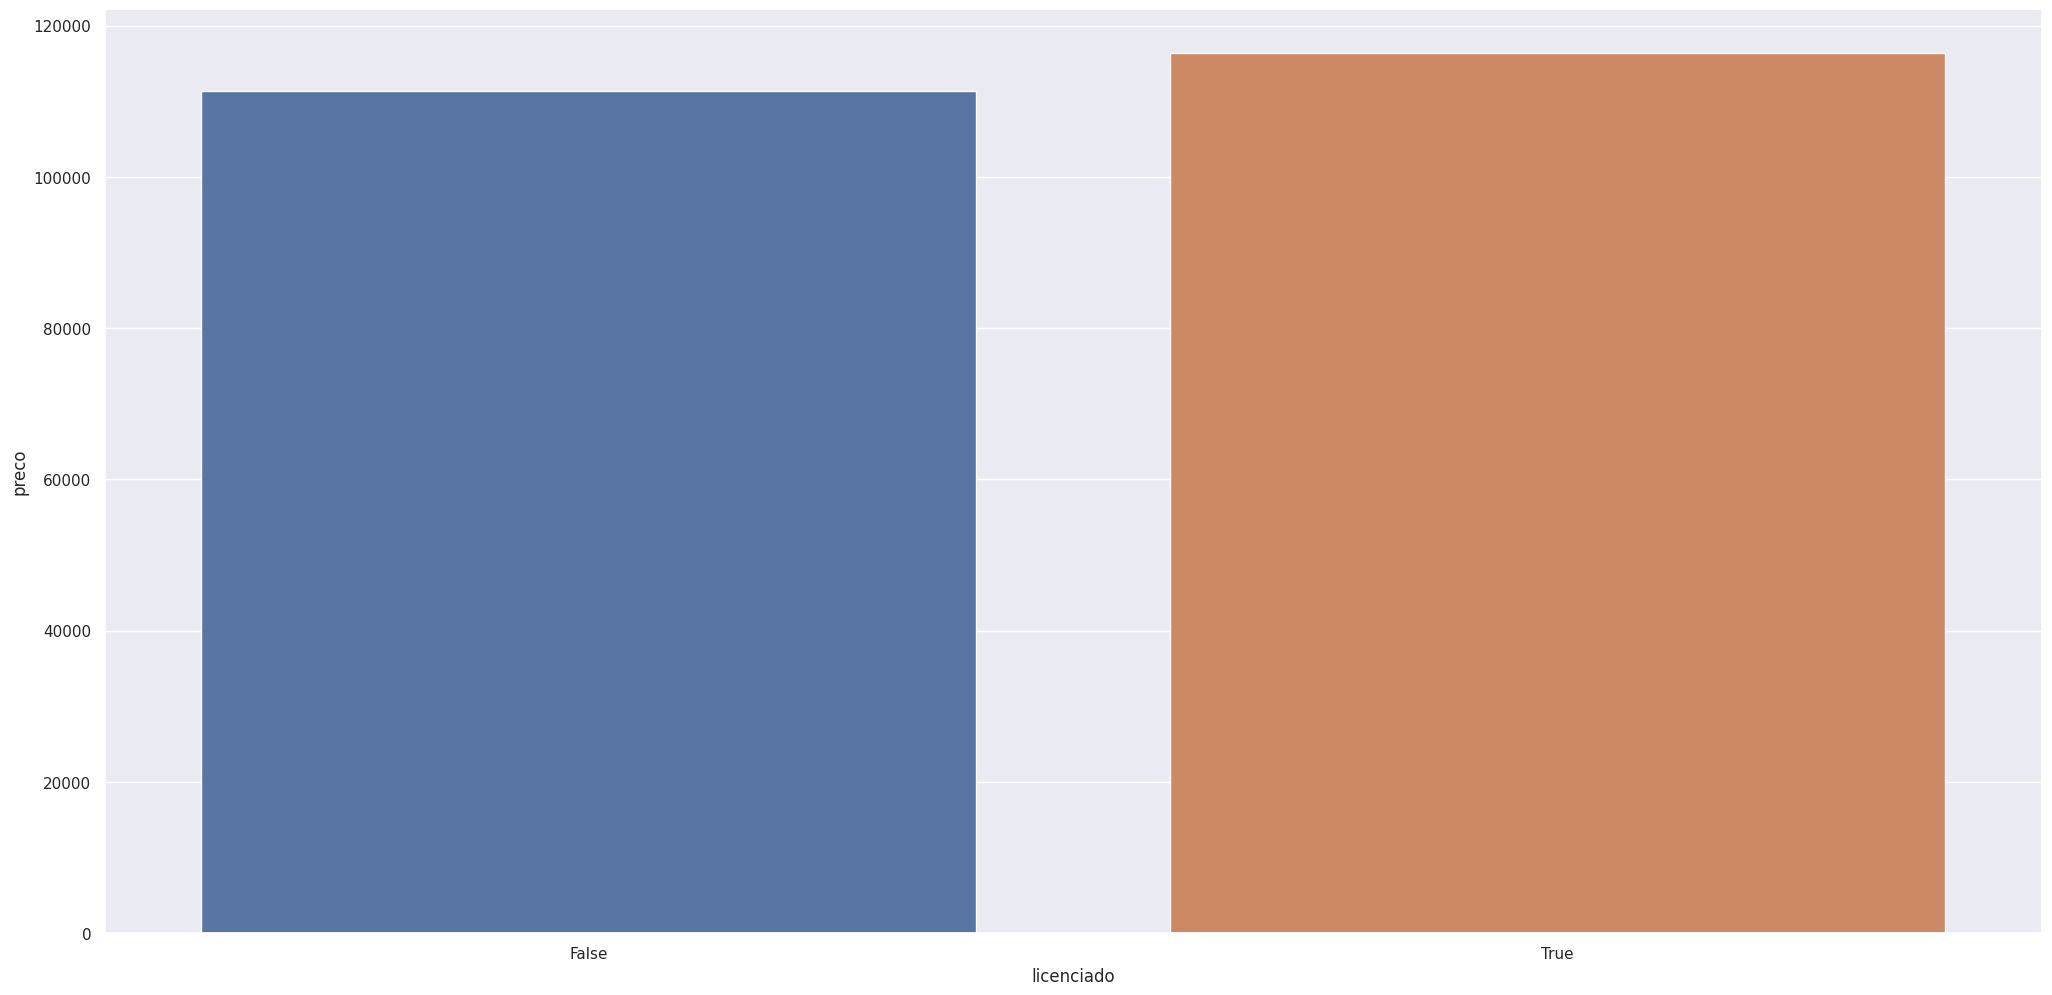

In [295]:
aux1 = df4[['licenciado', 'preco']].groupby('licenciado').median().reset_index()
sns.barplot(aux1, x='licenciado', y='preco');

## 4.3 Análise Multivariada

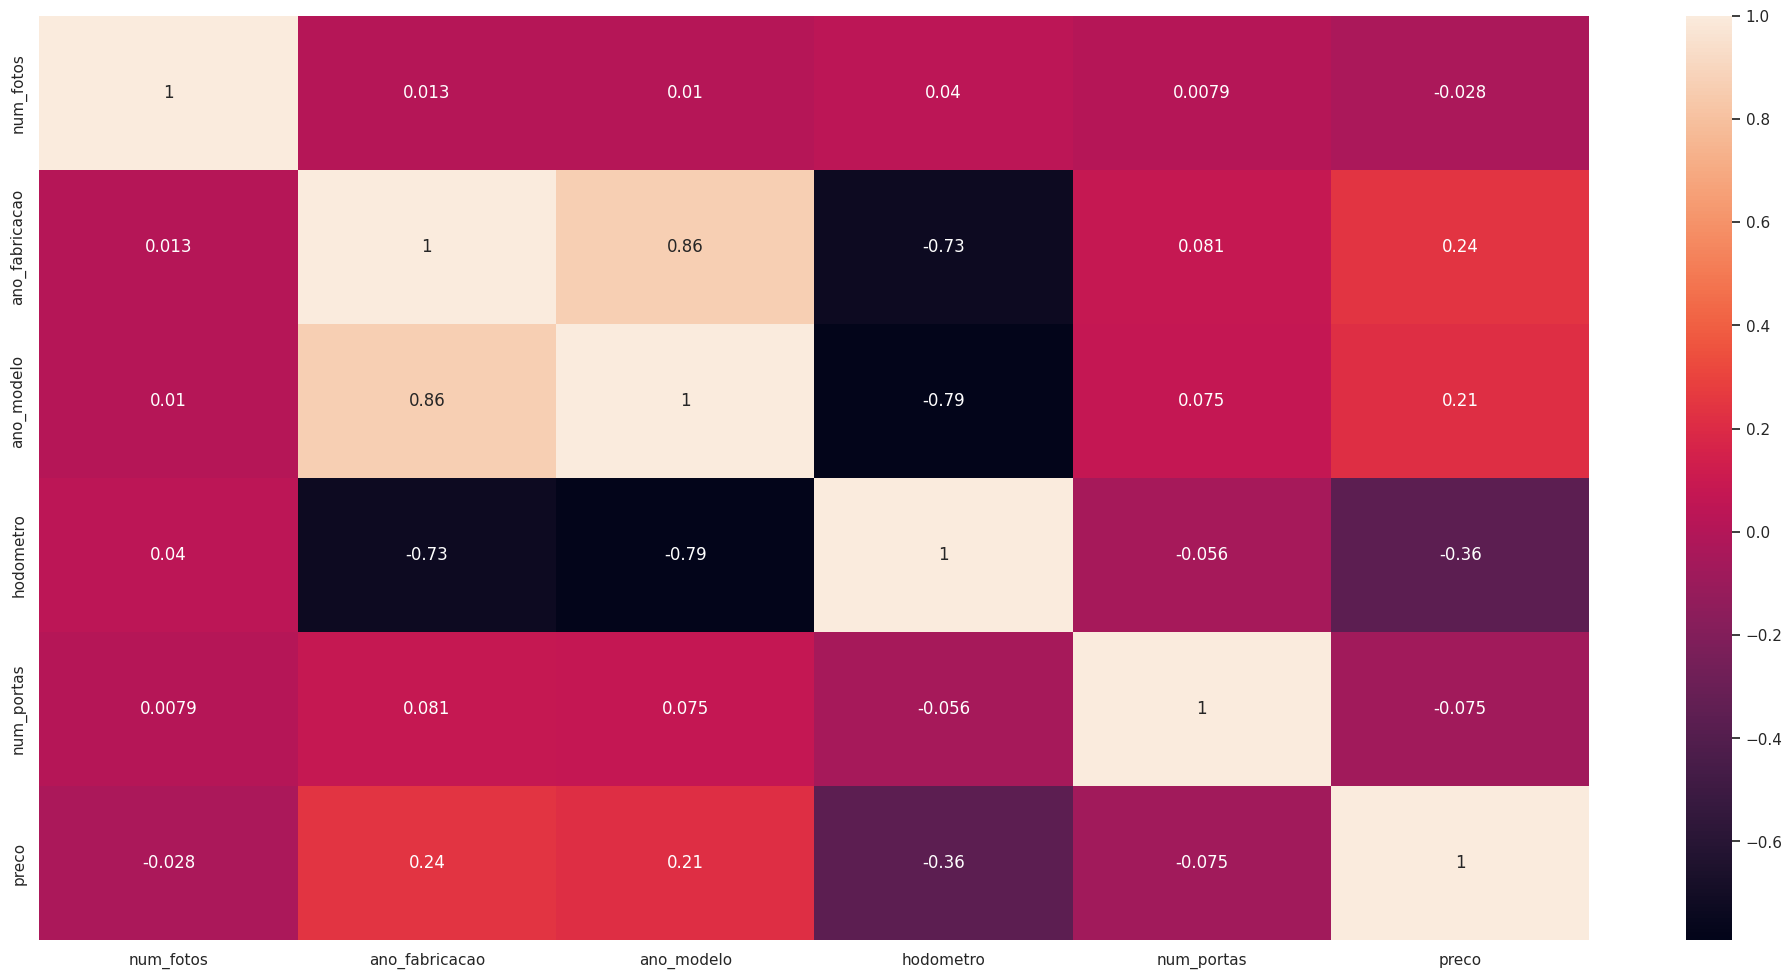

In [296]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0 DATA PREPARATION

In [5]:
df5 = pd.read_csv('../data/interim/dataset_selected.csv')

## 5.1 Separação de Treino e Teste

In [72]:
X = df5[df5.columns.drop(['id', 'preco', 'versao', 'cidade_vendedor', 'estado_vendedor', 'marca', 'modelo'])]

# Transformacao logaritma na feature target
y = np.log1p(df5['preco'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

## 5.2 Preparação dos dados de treino

In [60]:
# numero de fotos
mms_fotos = MinMaxScaler()
X_train['num_fotos'] = mms_fotos.fit_transform(X_train[['num_fotos']].values)

#identificacao, cor, endereco, cilindradas, combustivel
encoderc = CountFrequencyEncoder(encoding_method='frequency',
                                variables=['endereco', 'combustivel'],
                                ignore_format=True,
                                unseen='encode')

encodert = TargetEncoder(cols=['identificacao', 'cor', 'cilindradas'])

# fit the encoders
encoderc.fit(X_train)
encodert.fit(X_train, y_train)

# transform
X_train = encoderc.transform(X_train)
X_train = encodert.transform(X_train)

# ano_fabricacao
mms_fabricacao = MinMaxScaler()
X_train['ano_fabricacao'] = mms_fabricacao.fit_transform(X_train[['ano_fabricacao']].values)

# ano_modelo
mms_modelo = MinMaxScaler()
X_train['ano_modelo'] = mms_modelo.fit_transform(X_train[['ano_modelo']].values)

# hodometro
mms_hodometro = MinMaxScaler()
X_train['hodometro'] = mms_hodometro.fit_transform(X_train[['hodometro']].values)

# cambio
le_cambio = LabelEncoder()
X_train['cambio'] = le_cambio.fit_transform(X_train['cambio'])

# numero de portas
mms_portas = MinMaxScaler()
X_train['num_portas'] = mms_portas.fit_transform(X_train[['num_portas']].values)

# tipo
le_tipo = LabelEncoder()
X_train['tipo'] = le_tipo.fit_transform(X_train[['tipo']])

# blindado
le_blindado = LabelEncoder()
X_train['blindado'] = le_blindado.fit_transform(X_train[['blindado']].values)

# tipo_vendedor
le_vendedor = LabelEncoder()
X_train['tipo_vendedor'] = le_vendedor.fit_transform(X_train['tipo_vendedor'])

# anunciante
le_anunciante = LabelEncoder()
X_train['anunciante'] = le_anunciante.fit_transform(X_train['anunciante'])

# entrega_delivery
X_train.delivery = X_train.delivery.replace({True: 1, False:0})

# troca
X_train.troca = X_train.troca.replace({True: 1, False:0})

# aceita troca
X_train.aceita_troca = X_train.aceita_troca.replace({True: 1, False:0})

# unico dono
X_train.unico_dono = X_train.unico_dono.replace({True: 1, False:0})

# revisoes concessionaria
X_train.revisoes_concessionaria = X_train.revisoes_concessionaria.replace({True: 1, False:0})

# ipva
X_train.ipva = X_train.ipva.replace({True: 1, False:0})

# licenciado
X_train.licenciado = X_train.licenciado.replace({True: 1, False:0})

# garantia_fabrica
X_train.garantia_fabrica = X_train.garantia_fabrica.replace({True: 1, False:0})

# revisoes_agenda
X_train.revisoes_agenda = X_train.revisoes_agenda.replace({True: 1, False:0})

# turbo
X_train.turbo = X_train.turbo.replace({True: 1, False:0})

/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 5.4 Preparação dos dados de teste

In [61]:
# numero de fotos
X_test['num_fotos'] = mms_fotos.transform(X_test[['num_fotos']].values)

#identificacao, cor, endereco, cilindradas, combustivel
# transform
X_test = encoderc.transform(X_test)

X_test = encodert.transform(X_test)

# ano_fabricacao
X_test['ano_fabricacao'] = mms_fabricacao.transform(X_test[['ano_fabricacao']].values)

# ano_modelo
X_test['ano_modelo'] = mms_modelo.transform(X_test[['ano_modelo']].values)

# hodometro
X_test['hodometro'] = mms_hodometro.transform(X_test[['hodometro']].values)

# cambio
X_test['cambio'] = le_cambio.transform(X_test['cambio'])

# numero de portas
X_test['num_portas'] = mms_portas.transform(X_test[['num_portas']].values)

# tipo
X_test['tipo'] = le_tipo.transform(X_test[['tipo']])

# blindado
X_test['blindado'] = le_blindado.transform(X_test[['blindado']].values)

# tipo_vendedor
X_test['tipo_vendedor'] = le_vendedor.transform(X_test['tipo_vendedor'])

# anunciante
X_test['anunciante'] = le_anunciante.transform(X_test['anunciante'])

# entrega_delivery
X_test.delivery = X_test.delivery.replace({True: 1, False:0})

# troca
X_test.troca = X_test.troca.replace({True: 1, False:0})

# aceita troca
X_test.aceita_troca = X_test.aceita_troca.replace({True: 1, False:0})

# unico dono
X_test.unico_dono = X_test.unico_dono.replace({True: 1, False:0})

# revisoes concessionaria
X_test.revisoes_concessionaria = X_test.revisoes_concessionaria.replace({True: 1, False:0})

# ipva
X_test.ipva = X_test.ipva.replace({True: 1, False:0})

# licenciado
X_test.licenciado = X_test.licenciado.replace({True: 1, False:0})

# garantia_fabrica
X_test.garantia_fabrica = X_test.garantia_fabrica.replace({True: 1, False:0})

# revisoes_agenda
X_test.revisoes_agenda = X_test.revisoes_agenda.replace({True: 1, False:0})

# turbo
X_test.turbo = X_test.turbo.replace({True: 1, False:0})

/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 6.0 FEATURE SELECTION

## 6.1 Boruta as Feature Selector

In [11]:
# training and test dataset for Boruta
X_train_b = X_train.values
y_train_b = y_train.values.ravel()


# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=7).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	18


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	18


## 6.2 Best Features from Boruta

In [12]:
cols_selected_b = boruta.support_.tolist()

# best features
cols_selected_boruta = X_train.iloc[:, cols_selected_b].columns.to_list()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train.columns, cols_selected_boruta)

In [13]:
print(f'Features selecionados pelo algoritmo: {cols_selected_boruta}\n')

print(f'Features descartadas: {cols_not_selected_boruta}')

Features selecionados pelo algoritmo: ['ano_fabricacao', 'ano_modelo', 'hodometro', 'tipo', 'identificacao', 'cilindradas', 'combustivel']

Features descartadas: ['aceita_troca' 'anunciante' 'blindado' 'cambio' 'cor' 'delivery'
 'endereco' 'garantia_fabrica' 'ipva' 'licenciado' 'num_fotos'
 'num_portas' 'revisoes_agenda' 'revisoes_concessionaria' 'tipo_vendedor'
 'troca' 'turbo' 'unico_dono']


In [206]:
boruta_features = ['ano_fabricacao', 'ano_modelo', 'hodometro', 'tipo', 'identificacao', 'cilindradas', 'combustivel']

## 6.3 Feature importances with Random Forest

### 6.3.1 Impurity

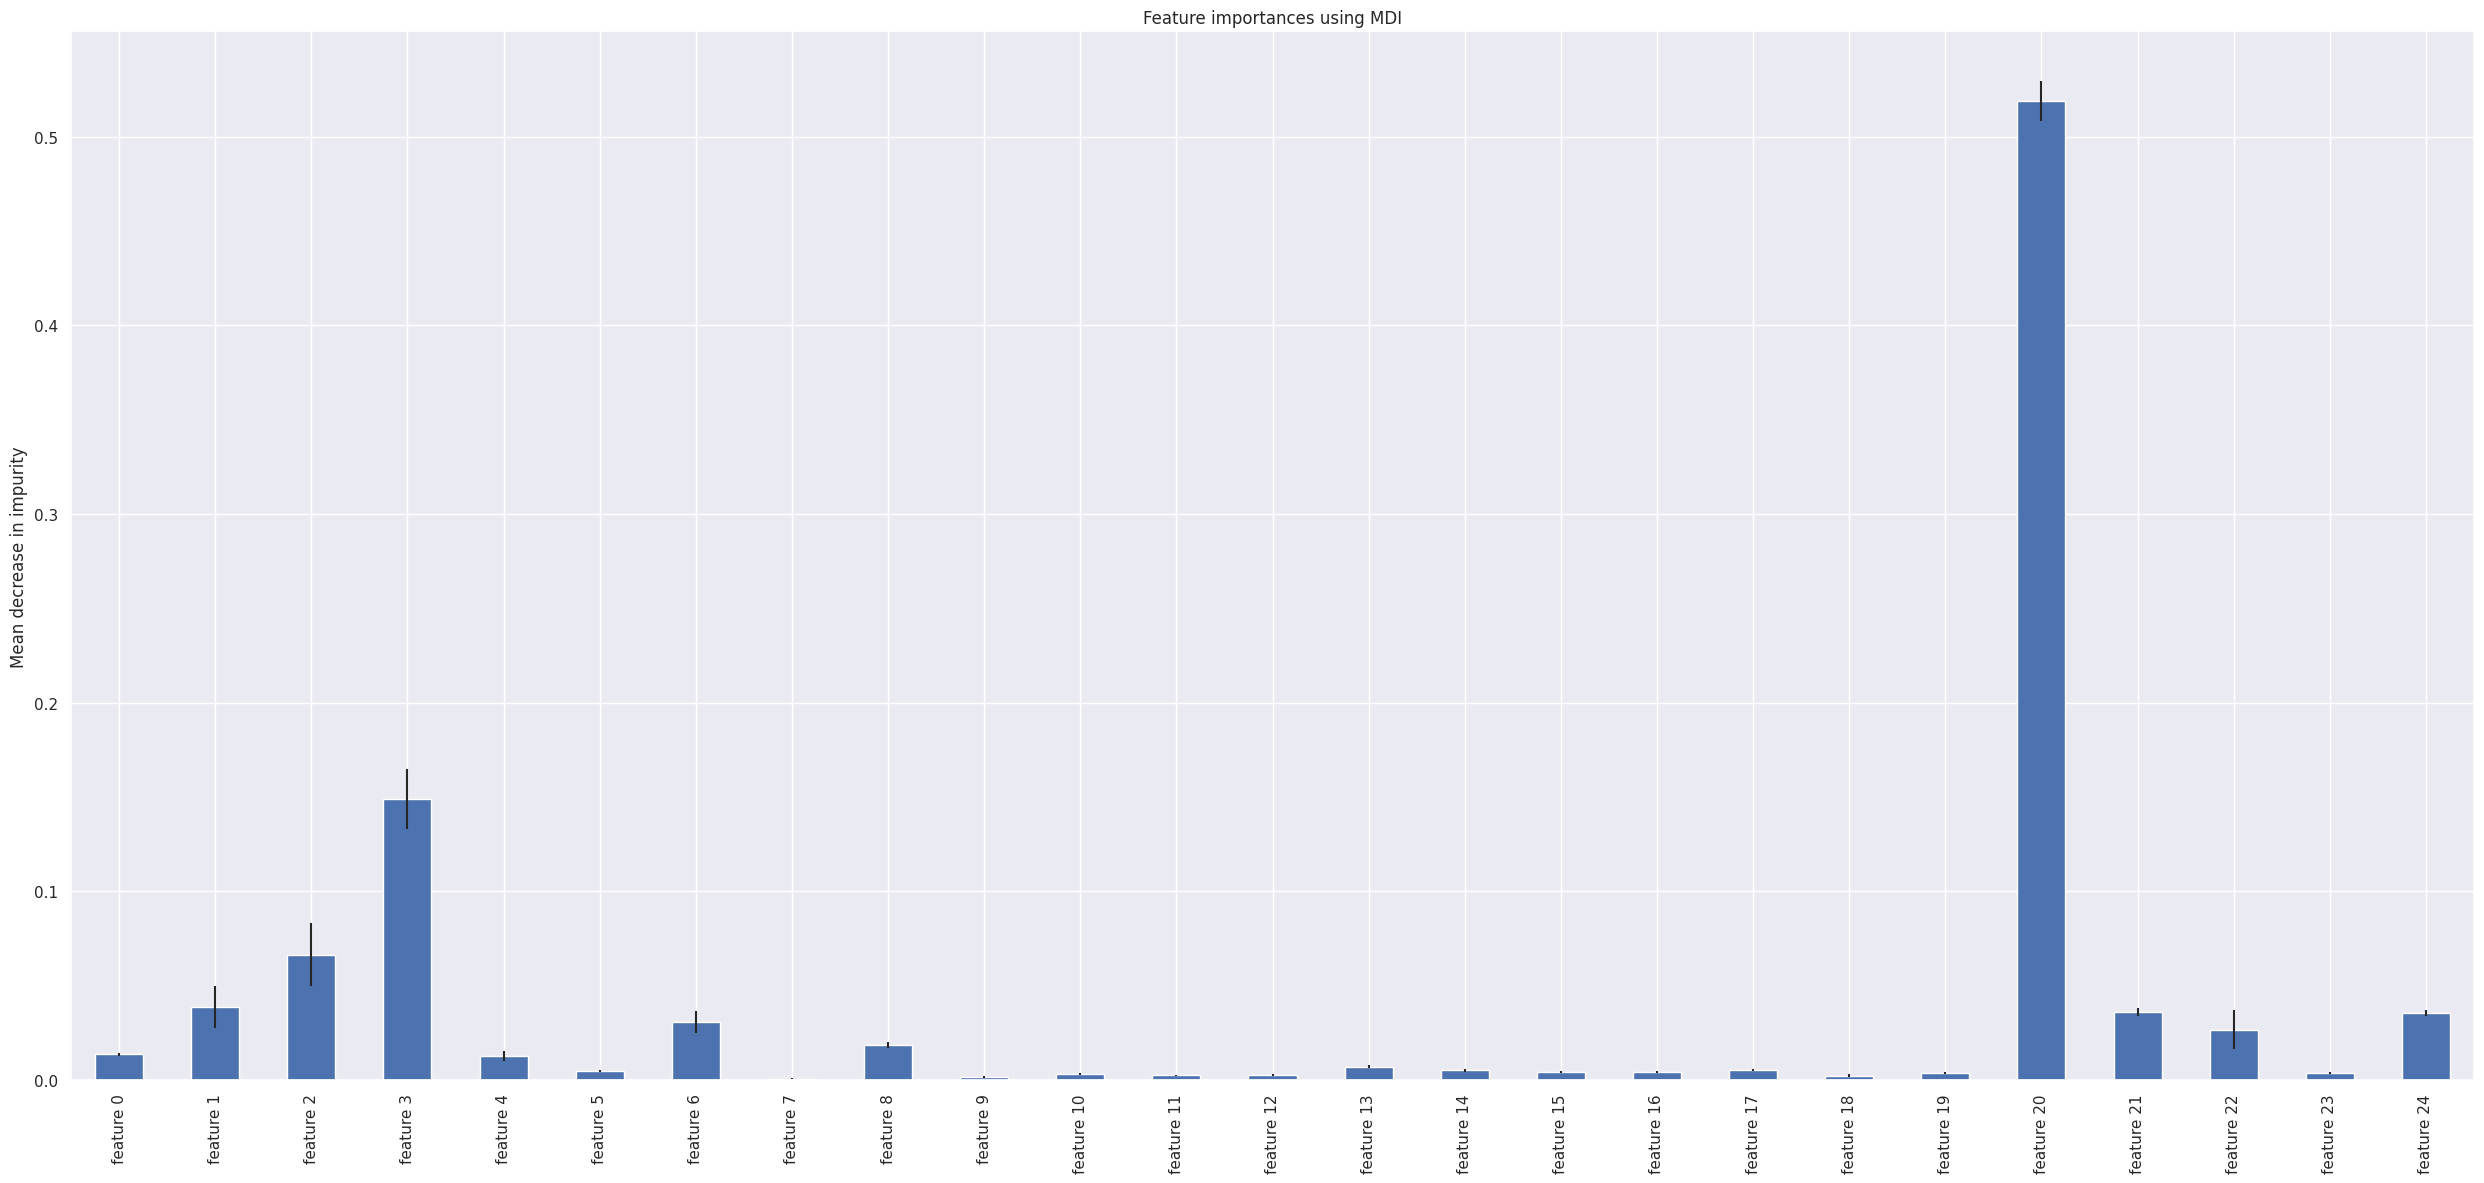

In [14]:
from sklearn.inspection import permutation_importance

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestRegressor(random_state=7).fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
# Print the feature ranking
print('Features ranking:')
df = pd.DataFrame()

for i, j in zip(X_train, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Features ranking:
                   feature  importance
0            identificacao      0.5187
0                hodometro      0.1491
0               ano_modelo      0.0665
0           ano_fabricacao      0.0387
0              cilindradas      0.0362
0                 endereco      0.0357
0                     tipo      0.0307
0              combustivel      0.0268
0                      cor      0.0187
0                num_fotos      0.0137
0                   cambio      0.0129
0             aceita_troca      0.0072
0               licenciado      0.0053
0               unico_dono      0.0052
0               num_portas      0.0049
0                     ipva      0.0043
0  revisoes_concessionaria      0.0042
0                    turbo      0.0039
0          revisoes_agenda      0.0037
0               anunciante      0.0035
0                    troca      0.0028
0                 delivery      0.0026
0         garantia_fabrica      0.0023
0            tipo_vendedor      0.0017
0      

### 6.3.2 Feature Permutation

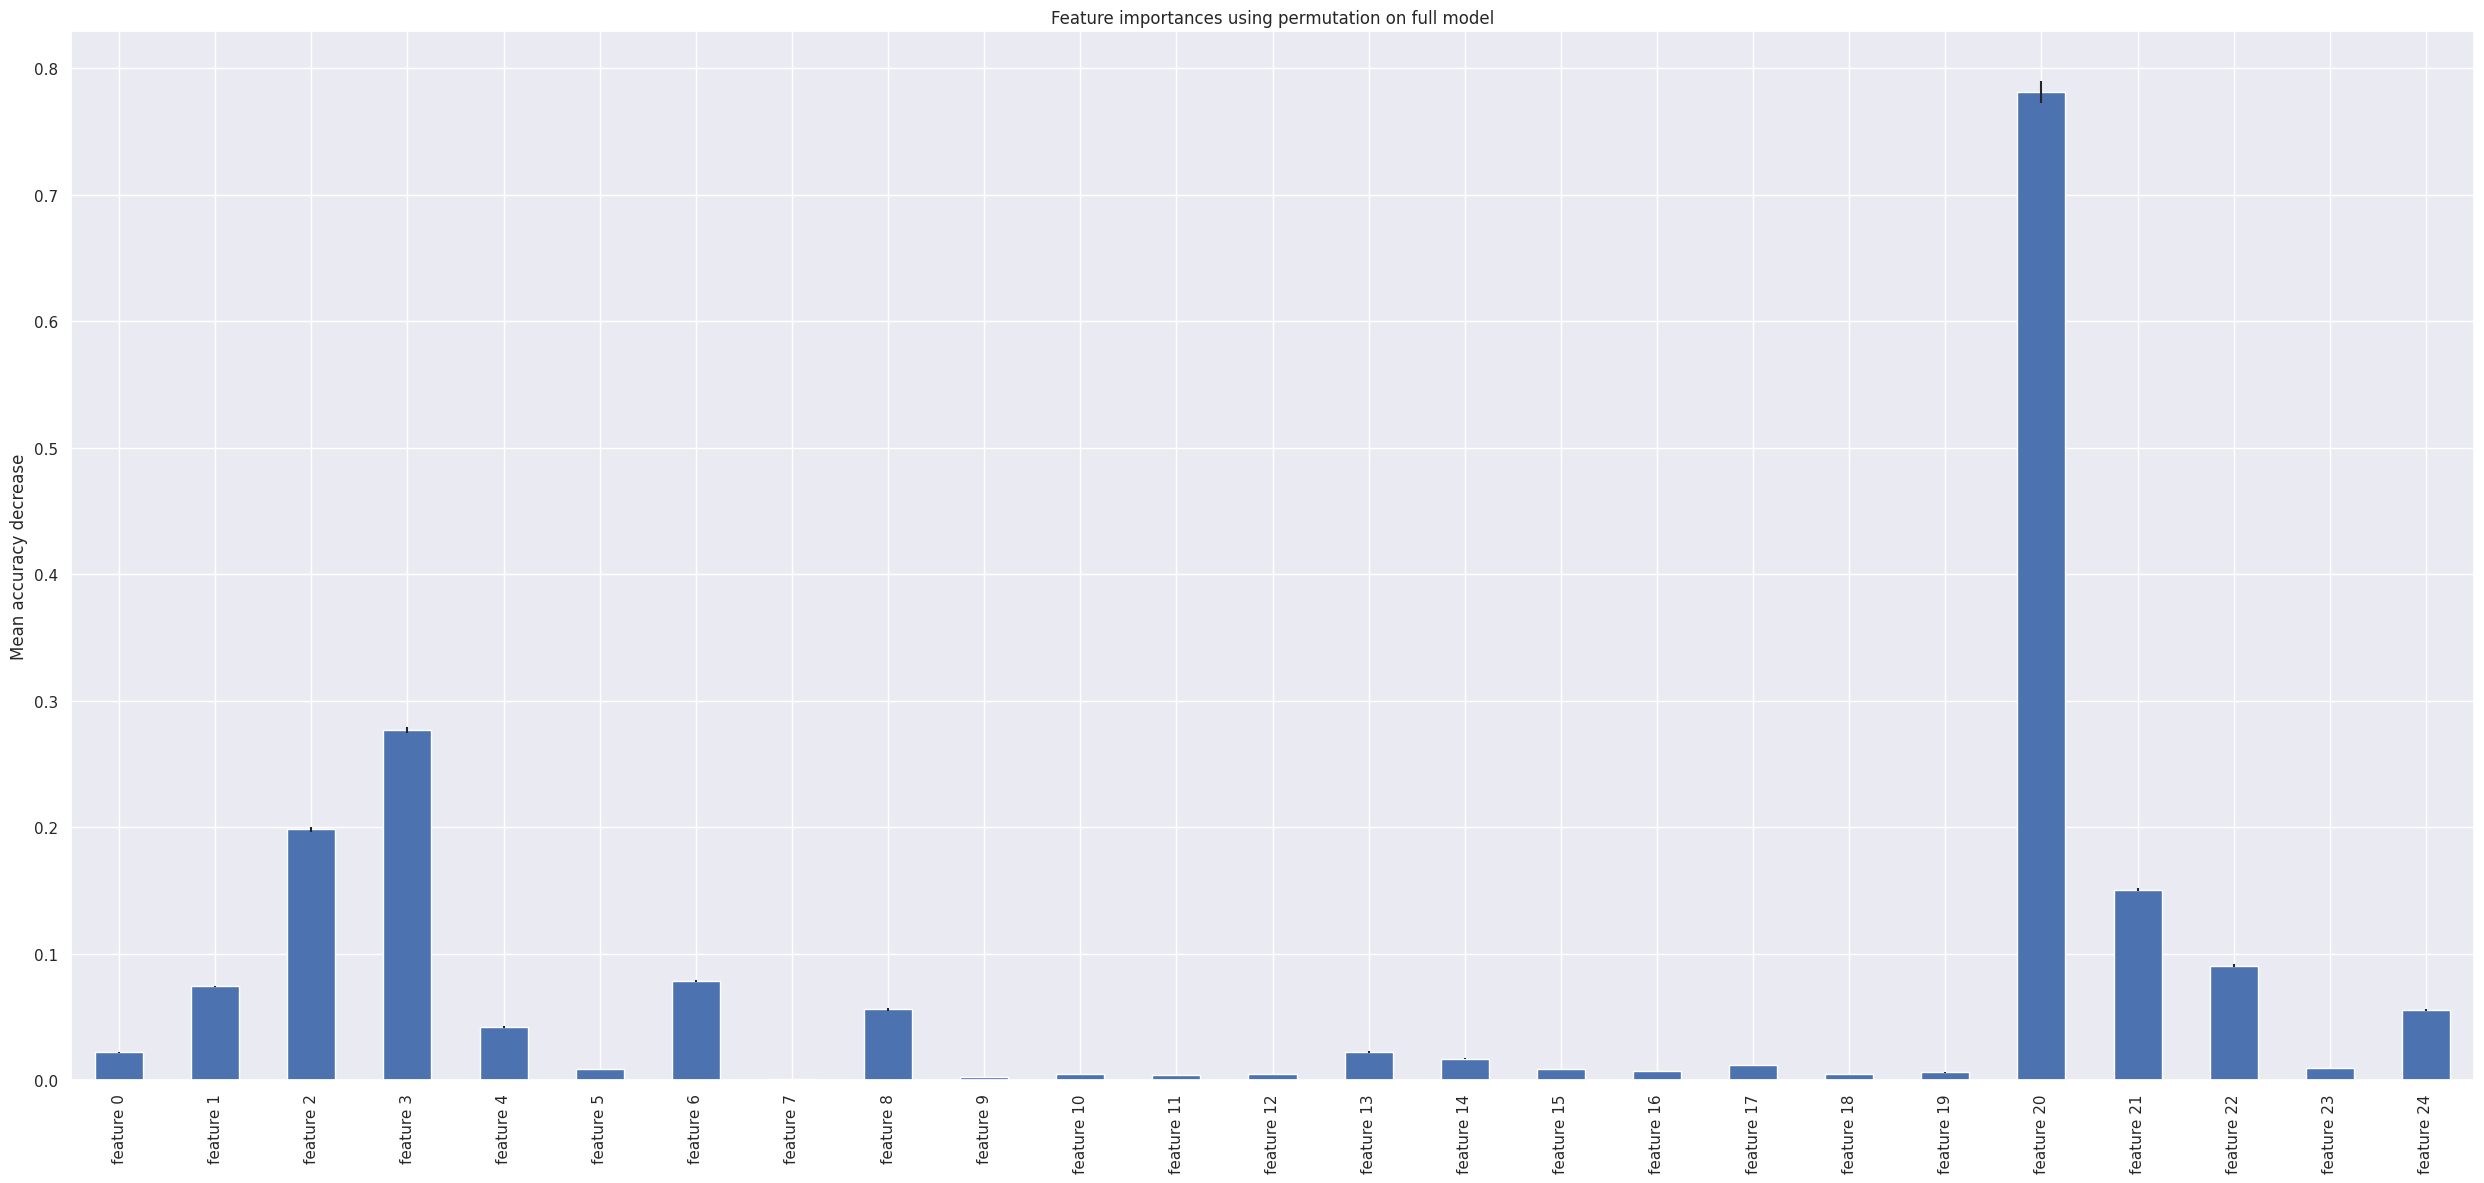

In [16]:
result = permutation_importance(
    forest, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [17]:
# Print the feature ranking
print('Features ranking:')
df = pd.DataFrame()

for i, j in zip(X_train, result.importances_mean):
    aux = pd.DataFrame({'feature':i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Features ranking:
                   feature  importance
0            identificacao      0.7808
0                hodometro      0.2767
0               ano_modelo      0.1982
0              cilindradas      0.1507
0              combustivel      0.0905
0                     tipo      0.0782
0           ano_fabricacao      0.0742
0                      cor      0.0562
0                 endereco      0.0554
0                   cambio      0.0422
0                num_fotos      0.0222
0             aceita_troca      0.0221
0               unico_dono      0.0170
0               licenciado      0.0119
0                    turbo      0.0099
0               num_portas      0.0087
0  revisoes_concessionaria      0.0086
0                     ipva      0.0071
0          revisoes_agenda      0.0061
0         garantia_fabrica      0.0049
0                    troca      0.0046
0               anunciante      0.0046
0                 delivery      0.0040
0            tipo_vendedor      0.0022
0      

In [62]:
cols_selected = ['identificacao', 'hodometro', 'ano_modelo',
                 'cilindradas', 'endereco', 'tipo', 'combustivel', 'cor', 'cambio']

# 7.0 MACHINE LEARNING

In [63]:
# X_train = X_train[cols_selected]
# X_test = X_test[cols_selected]

## 7.1 Average Model

In [36]:
aux1 = df5[['marca', 'modelo']]
aux1['identificacao'] = aux1['marca'] + ' ' + aux1['modelo']
aux1['preco'] = y

X_mean_train, X_mean_test = train_test_split(aux1, test_size=0.25, random_state=7)

aux2 = X_mean_train[['identificacao',
             'preco']].groupby('identificacao').mean().reset_index().rename(columns={'preco': 'predictions'})

# merge
X_mean_test = pd.merge(X_mean_test, aux2, how='left', on='identificacao')

# Preenchendo valores faltantes para carros nao encontrados
X_mean_test['predictions'].fillna(aux2['predictions'].mean(), inplace=True)

# performance
baseline_result = ml_error('Average Model', np.expm1(X_mean_test['preco']), np.expm1(X_mean_test['predictions']))
baseline_result

/tmp/ipykernel_7357/2587287083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['identificacao'] = aux1['marca'] + ' ' + aux1['modelo']
/tmp/ipykernel_7357/2587287083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['preco'] = y


,Model Name,MAE,MAPE,RMSE
0,Average Model,37392.6966,0.3119,55391.4515


## 7.2 Linear Regression Model

In [64]:
# # model
# lr = LinearRegression().fit(X_train, y_train)

# # prediction
# yhat_lr = lr.predict(X_test)

# # performace
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,33040.8108,0.2654,51738.6462


### 7.2.1 Cross Validation

In [166]:
lr = LinearRegression()
lr_result_cv = cross_validation(X_train, y_train, 'Linear Regression', lr)

## 7.3 Linear Regression Regularized Model - Lasso

In [82]:
# # model
# lrr = Lasso(alpha=0.005).fit(X_train, y_train)

# # prediction
# yhat_lrr = lrr.predict(X_test)

# # performace
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1 Cross Validation

In [167]:
lrr = Lasso(alpha=0.005)
lrr_result_cv = cross_validation(X_train, y_train, 'Linear Regression - Lasso', lrr)

## 7.4 Random Forest Regressor

In [66]:
# # model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7).fit(X_train, y_train)

# # prediction
# yhat_rf = rf.predict(X_test)

# # performace
# rf_result = ml_error('Random Forest Regression - Lasso', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression - Lasso,27199.8754,0.2220,41558.8720


### 7.4.1 Cross Validation

In [168]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7)
rf_result_cv = cross_validation(X_train, y_train, 'Random Forest Regression', rf)

## 7.5 XGBoost Regressor

In [67]:
# # model
# model_xgb = xgb.XGBRegressor(n_estimators=100,
#                              random_state=7).fit(X_train, y_train)

# # prediction
# yhat_xgb = model_xgb.predict(X_test)

# # performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,26667.5575,0.2167,41073.5063


### 7.5.1 Cross Validation

In [169]:
model_xgb = xgb.XGBRegressor(n_estimators=100,random_state=7)
xgb_result_cv = cross_validation(X_train, y_train, 'XGBoost Regression', model_xgb)

## 7.6 LightGBM Regressor

In [68]:
# # model
# model_lgbm = lgbm.LGBMRegressor(n_estimators=300).fit(X_train, y_train)

# # prediction
# yhat_lgbm = model_lgbm.predict(X_test)

# # performance
# lgbm_result = ml_error('LightGBM Regressor', np.expm1(y_test), np.expm1(yhat_lgbm))
# lgbm_result

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 22188, number of used features: 9
[LightGBM] [Info] Start training from score 11.637541


,Model Name,MAE,MAPE,RMSE
0,LightGBM Regressor,26458.1349,0.2145,40735.2350


### 7.6.1 Cross Validation

In [178]:
model_lgbm = lgbm.LGBMRegressor(n_estimators=300, verbose=-1)
lgbm_result_cv = cross_validation(X_train, y_train, 'LightGBM Regression', model_lgbm)

## 7.7 CatBoost Regressor

In [69]:
# # model
# model_cat = CatBoostRegressor(verbose=False).fit(X_train, y_train)

# # prediction
# yhat_cat = model_cat.predict(X_test)

# # performance
# cat_result = ml_error('CatBoost Regressor', np.expm1(y_test), np.expm1(yhat_cat))
# cat_result

,Model Name,MAE,MAPE,RMSE
0,CatBoost Regressor,26336.7432,0.2130,40615.5574


### Cross Validation

In [179]:
model_cat = CatBoostRegressor(verbose=False)
cat_result_cv = cross_validation(X_train, y_train, 'CatBoost Regression', model_cat)

## 7.8 Compare Model's Performace

In [70]:
modelling_result_cv = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result, cat_result])
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,CatBoost Regressor,26336.7432,0.2130,40615.5574
0,LightGBM Regressor,26458.1349,0.2145,40735.2350
0,XGBoost Regressor,26667.5575,0.2167,41073.5063
0,Random Forest Regression - Lasso,27199.8754,0.2220,41558.8720
0,Linear Regression,33040.8108,0.2654,51738.6462
0,Linear Regression - Lasso,33636.3573,0.2715,52852.9338
0,Average Model,37392.6966,0.3119,55391.4515


## Cross Validation

In [180]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,
                                 rf_result_cv, xgb_result_cv, lgbm_result_cv, cat_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model name,MAE CV,MAPE CV,RMSE CV
0,CatBoost Regression,26904.06+/-880.31,0.22+/-0.0,43518.15+/-2859.96
0,LightGBM Regression,26973.5+/-963.31,0.22+/-0.0,43718.68+/-2883.11
0,XGBoost Regression,27509.45+/-912.79,0.22+/-0.0,44412.87+/-2786.13
0,Random Forest Regression,28068.35+/-812.92,0.23+/-0.01,45407.94+/-2703.4
0,Linear Regression,33412.15+/-818.5,0.27+/-0.0,53816.36+/-2918.6
0,Linear Regression - Lasso,34182.38+/-846.04,0.28+/-0.01,55313.34+/-3077.21


Com base no Cross-Validation, o modelo escolhido foi CatBoostRegressor, apresentando melhores resultados em todas as métricas.

# 8.0 HYPERPARAMETER FINE TUNING

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

# 10.0 DEPLOY MODEL